In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data to have mean 0.5 and std 0.5
])


# Load the Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.26MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.91MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



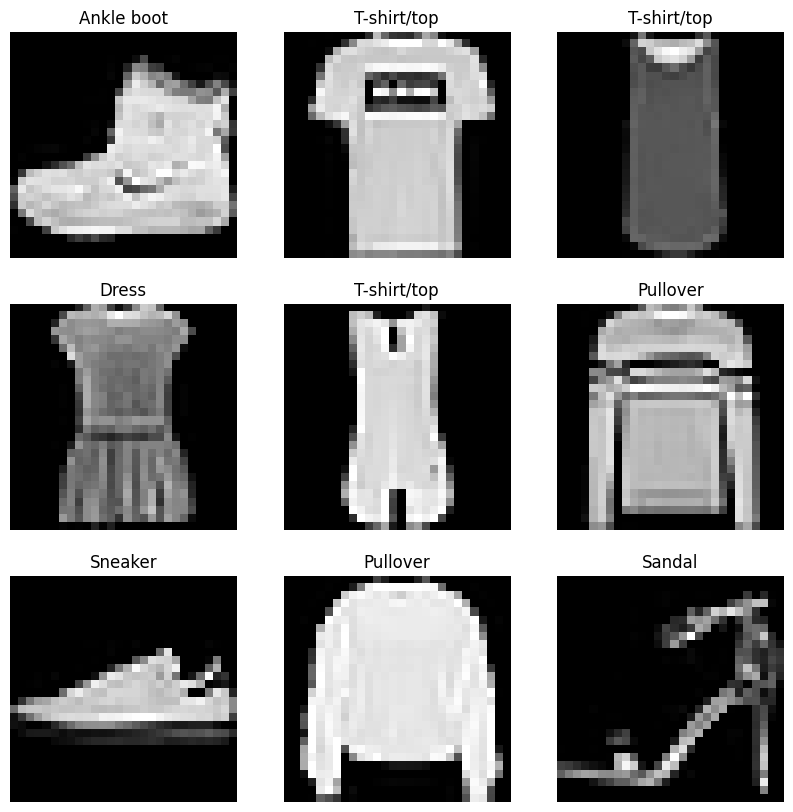

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_dataset[i][0].squeeze().numpy(), cmap='gray')
    plt.title(train_dataset.classes[train_dataset[i][1]])
    plt.axis('off')

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)
device

device(type='cuda')

In [ ]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [ ]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs

    outputs = discriminator(fake_images)
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [ ]:
num_epochs = 100
num_batches = len(train_loader)
latent_dim = 100
fixed_noise = torch.randn(9, latent_dim, 1, 1, device=device)

Epoch [0/100], Step [200/938], d_loss: 0.0155, g_loss: 5.5104, D(x): 1.00, D(G(z)): 0.01
Epoch [0/100], Step [400/938], d_loss: 0.0074, g_loss: 6.2652, D(x): 1.00, D(G(z)): 0.00
Epoch [0/100], Step [600/938], d_loss: 0.0015, g_loss: 7.6986, D(x): 1.00, D(G(z)): 0.00
Epoch [0/100], Step [800/938], d_loss: 0.0853, g_loss: 4.3269, D(x): 0.99, D(G(z)): 0.07


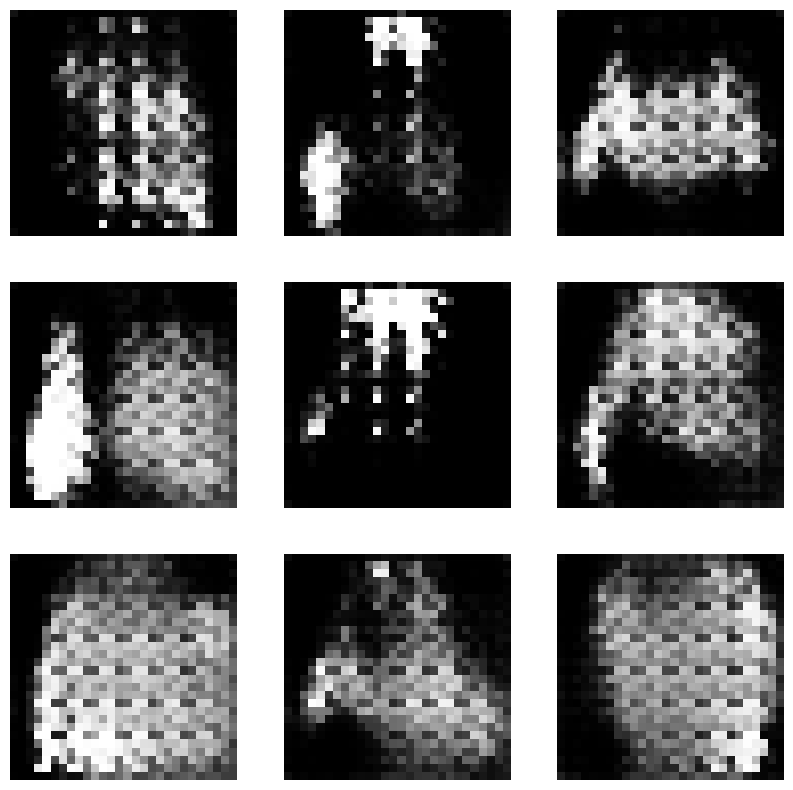

Epoch [1/100], Step [200/938], d_loss: 0.3402, g_loss: 2.7020, D(x): 0.89, D(G(z)): 0.17
Epoch [1/100], Step [400/938], d_loss: 0.2378, g_loss: 2.9237, D(x): 0.92, D(G(z)): 0.12
Epoch [1/100], Step [600/938], d_loss: 0.4126, g_loss: 2.8904, D(x): 0.81, D(G(z)): 0.14
Epoch [1/100], Step [800/938], d_loss: 0.2838, g_loss: 2.1684, D(x): 0.89, D(G(z)): 0.14


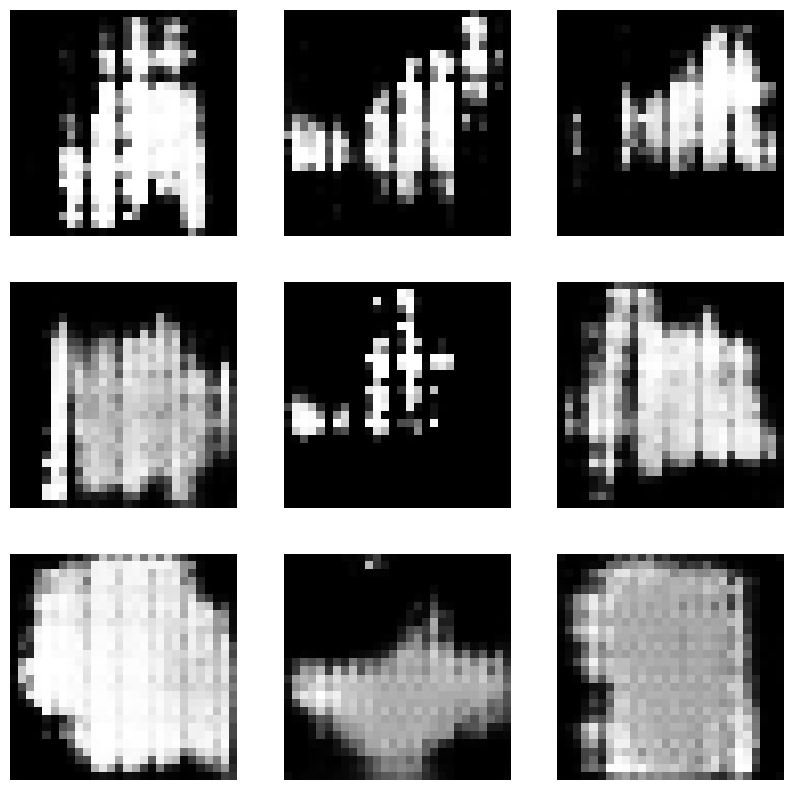

Epoch [2/100], Step [200/938], d_loss: 0.2321, g_loss: 2.3129, D(x): 0.95, D(G(z)): 0.15
Epoch [2/100], Step [400/938], d_loss: 0.3001, g_loss: 3.4108, D(x): 0.84, D(G(z)): 0.07
Epoch [2/100], Step [600/938], d_loss: 0.8384, g_loss: 1.4601, D(x): 0.71, D(G(z)): 0.31
Epoch [2/100], Step [800/938], d_loss: 0.3954, g_loss: 2.5021, D(x): 0.83, D(G(z)): 0.14


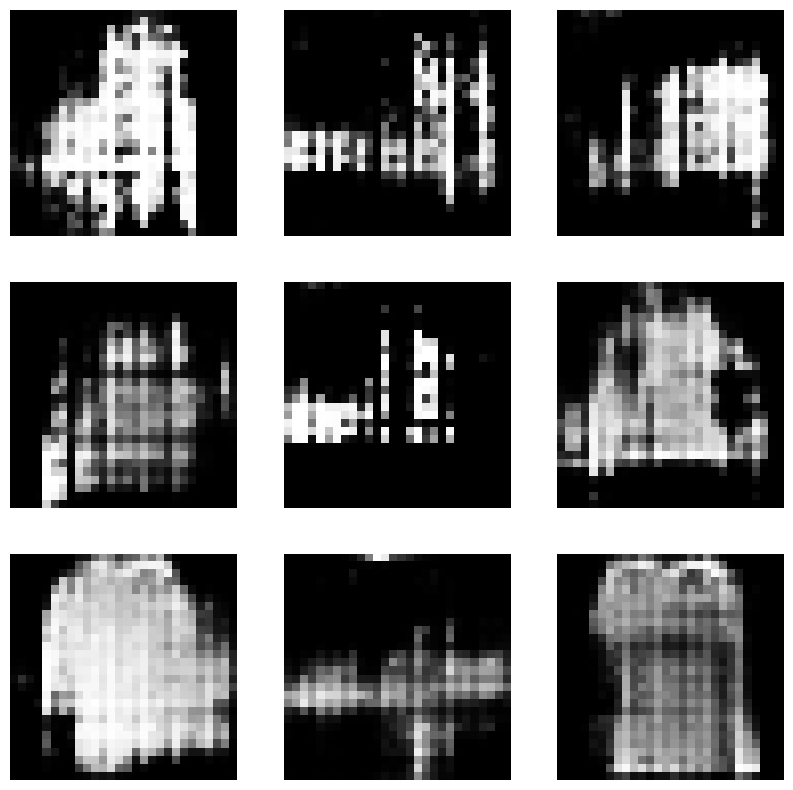

Epoch [3/100], Step [200/938], d_loss: 0.4229, g_loss: 1.8591, D(x): 0.90, D(G(z)): 0.24
Epoch [3/100], Step [400/938], d_loss: 0.7045, g_loss: 1.9161, D(x): 0.79, D(G(z)): 0.29
Epoch [3/100], Step [600/938], d_loss: 0.5651, g_loss: 2.2912, D(x): 0.76, D(G(z)): 0.18
Epoch [3/100], Step [800/938], d_loss: 0.6853, g_loss: 2.1239, D(x): 0.79, D(G(z)): 0.29


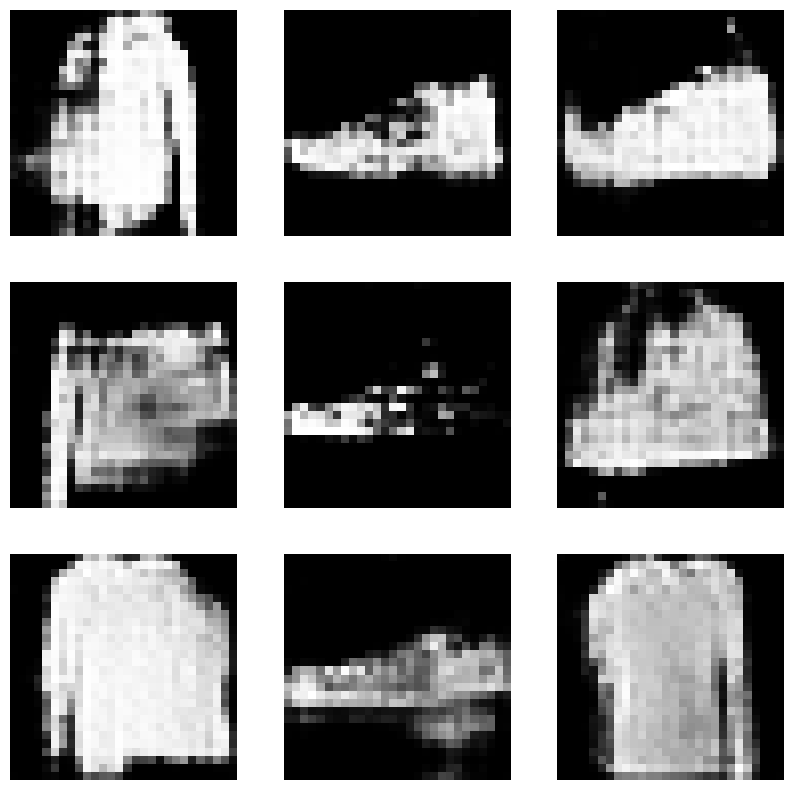

Epoch [4/100], Step [200/938], d_loss: 1.0525, g_loss: 2.0943, D(x): 0.51, D(G(z)): 0.17
Epoch [4/100], Step [400/938], d_loss: 0.5759, g_loss: 2.1384, D(x): 0.77, D(G(z)): 0.19
Epoch [4/100], Step [600/938], d_loss: 0.5211, g_loss: 2.8750, D(x): 0.83, D(G(z)): 0.23
Epoch [4/100], Step [800/938], d_loss: 0.6925, g_loss: 1.9241, D(x): 0.73, D(G(z)): 0.22


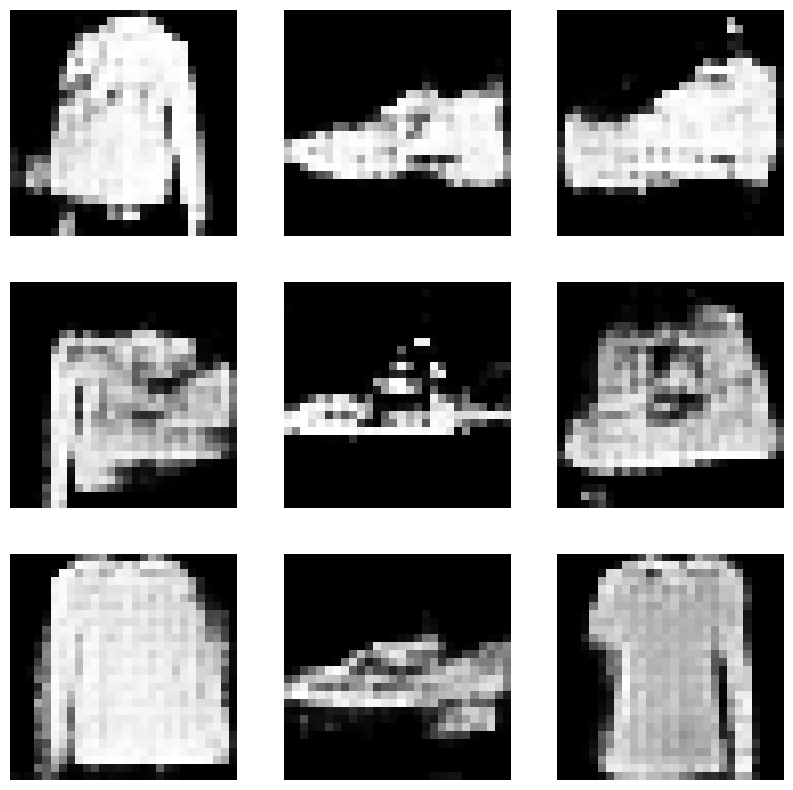

Epoch [5/100], Step [200/938], d_loss: 0.4716, g_loss: 2.2732, D(x): 0.76, D(G(z)): 0.13
Epoch [5/100], Step [400/938], d_loss: 1.3781, g_loss: 1.2069, D(x): 0.68, D(G(z)): 0.51
Epoch [5/100], Step [600/938], d_loss: 0.5933, g_loss: 1.0241, D(x): 0.90, D(G(z)): 0.33
Epoch [5/100], Step [800/938], d_loss: 0.8979, g_loss: 1.3549, D(x): 0.66, D(G(z)): 0.31


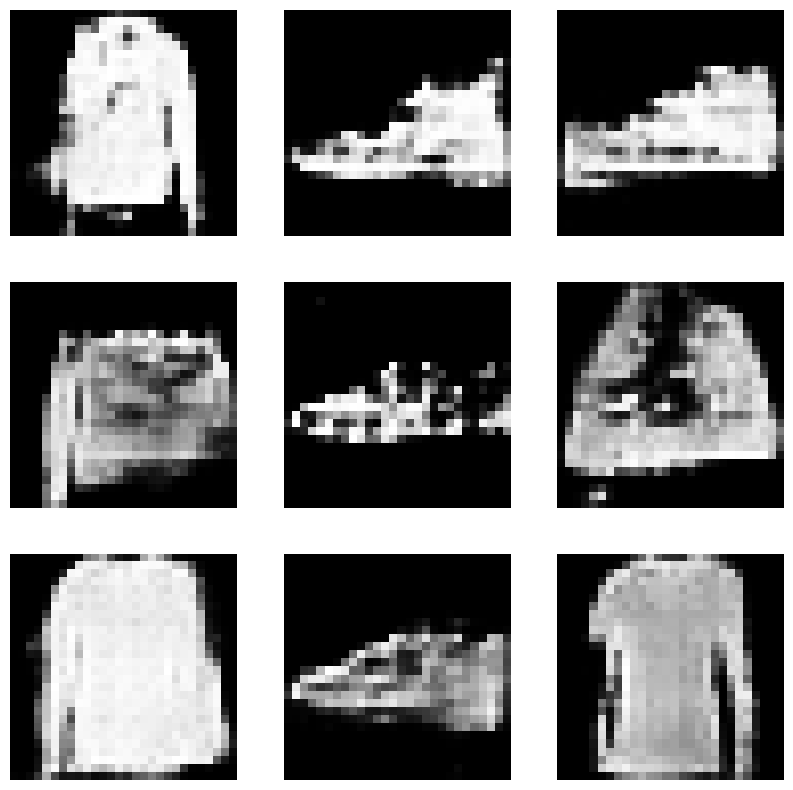

Epoch [6/100], Step [200/938], d_loss: 1.4817, g_loss: 1.6435, D(x): 0.46, D(G(z)): 0.36
Epoch [6/100], Step [400/938], d_loss: 1.0695, g_loss: 1.1862, D(x): 0.67, D(G(z)): 0.40
Epoch [6/100], Step [600/938], d_loss: 0.6162, g_loss: 1.3094, D(x): 0.81, D(G(z)): 0.29
Epoch [6/100], Step [800/938], d_loss: 1.0434, g_loss: 0.8152, D(x): 0.73, D(G(z)): 0.45


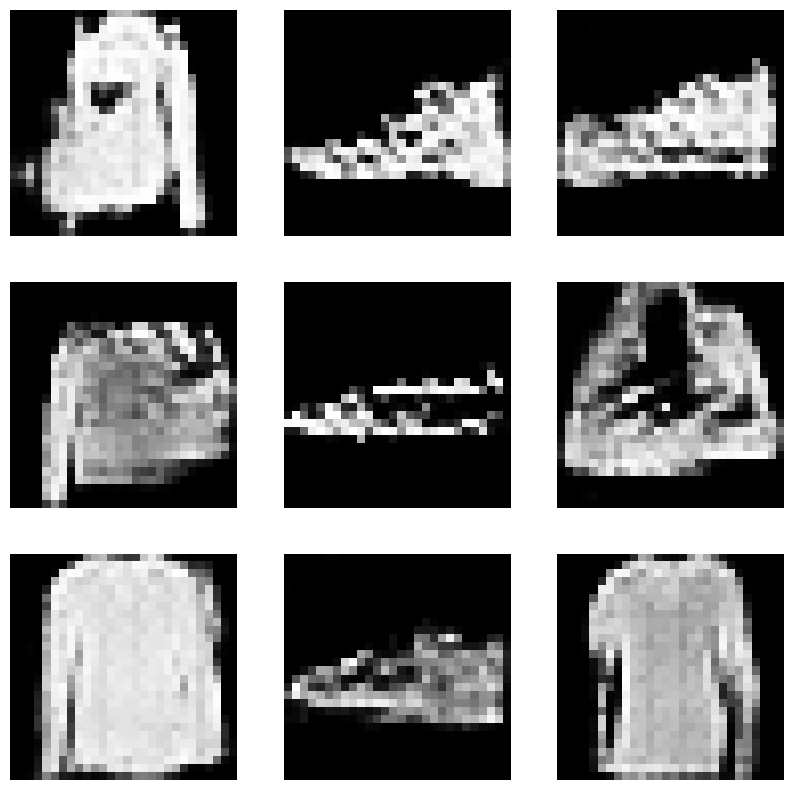

Epoch [7/100], Step [200/938], d_loss: 1.0954, g_loss: 1.2387, D(x): 0.55, D(G(z)): 0.30
Epoch [7/100], Step [400/938], d_loss: 0.9473, g_loss: 2.0412, D(x): 0.70, D(G(z)): 0.31
Epoch [7/100], Step [600/938], d_loss: 0.8793, g_loss: 1.9550, D(x): 0.65, D(G(z)): 0.24
Epoch [7/100], Step [800/938], d_loss: 0.8846, g_loss: 1.4951, D(x): 0.68, D(G(z)): 0.32


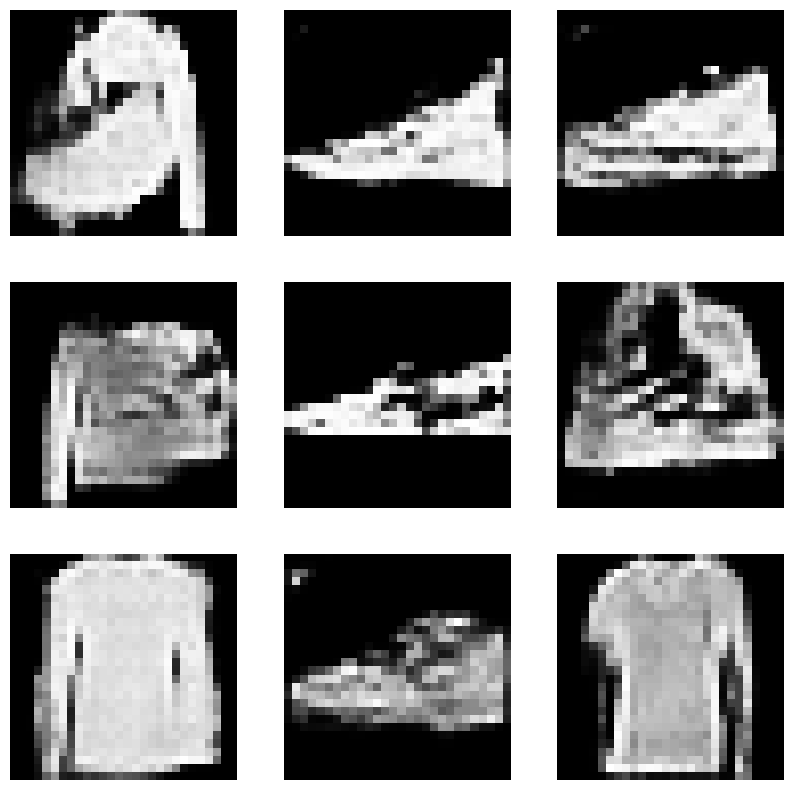

Epoch [8/100], Step [200/938], d_loss: 0.7368, g_loss: 1.5209, D(x): 0.73, D(G(z)): 0.29
Epoch [8/100], Step [400/938], d_loss: 0.9038, g_loss: 1.1227, D(x): 0.65, D(G(z)): 0.31
Epoch [8/100], Step [600/938], d_loss: 1.1142, g_loss: 1.3058, D(x): 0.69, D(G(z)): 0.43
Epoch [8/100], Step [800/938], d_loss: 0.7037, g_loss: 2.5139, D(x): 0.73, D(G(z)): 0.27


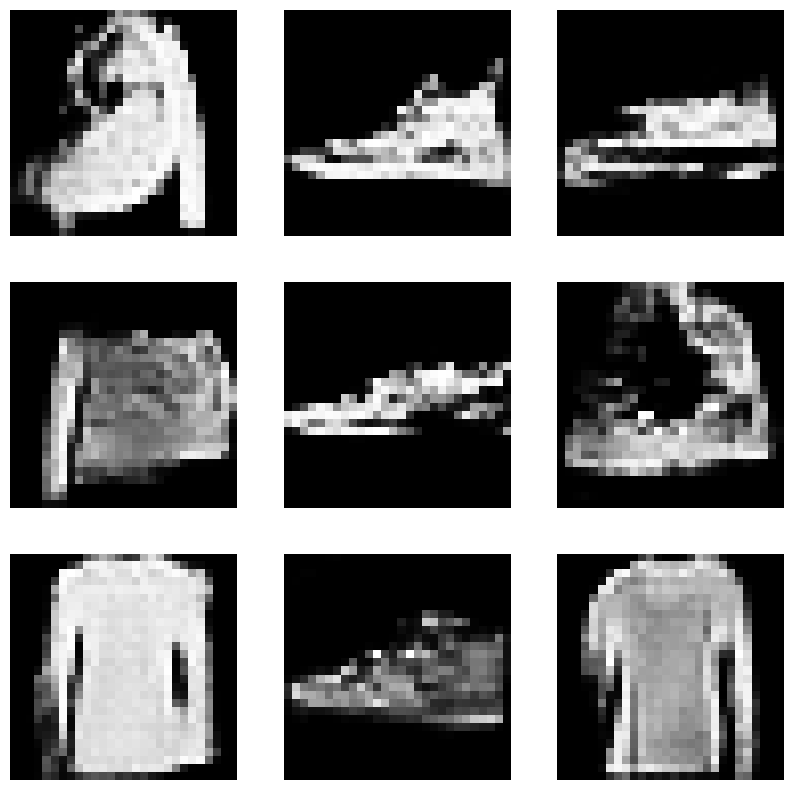

Epoch [9/100], Step [200/938], d_loss: 1.1730, g_loss: 0.9818, D(x): 0.68, D(G(z)): 0.46
Epoch [9/100], Step [400/938], d_loss: 1.0123, g_loss: 1.6165, D(x): 0.63, D(G(z)): 0.31
Epoch [9/100], Step [600/938], d_loss: 0.7935, g_loss: 1.5844, D(x): 0.75, D(G(z)): 0.33
Epoch [9/100], Step [800/938], d_loss: 0.7030, g_loss: 2.1130, D(x): 0.67, D(G(z)): 0.20


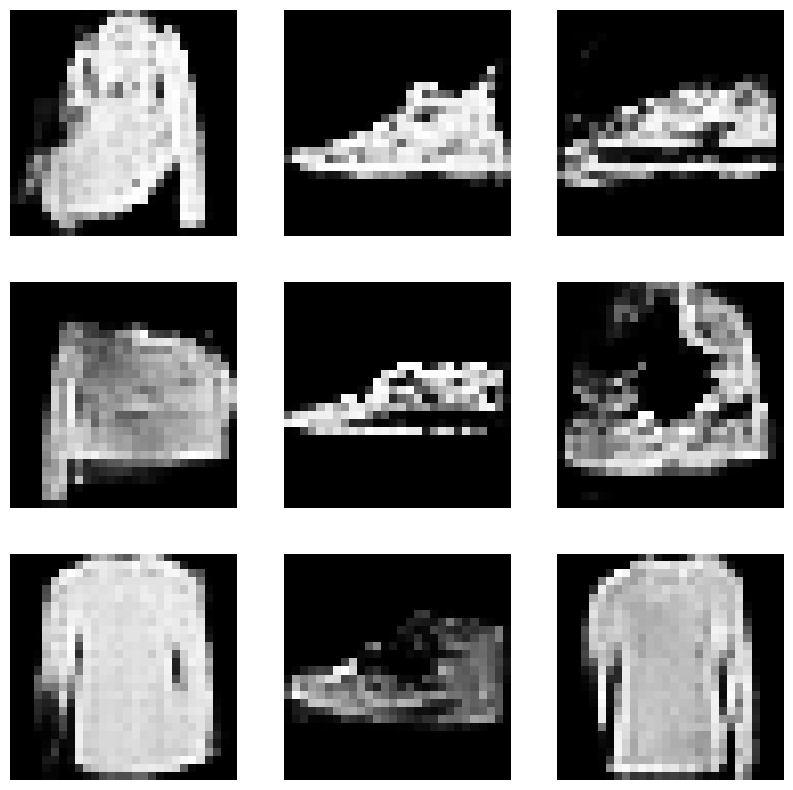

Epoch [10/100], Step [200/938], d_loss: 0.8770, g_loss: 1.5702, D(x): 0.72, D(G(z)): 0.36
Epoch [10/100], Step [400/938], d_loss: 0.7961, g_loss: 1.1091, D(x): 0.76, D(G(z)): 0.34
Epoch [10/100], Step [600/938], d_loss: 0.9125, g_loss: 1.7563, D(x): 0.68, D(G(z)): 0.35
Epoch [10/100], Step [800/938], d_loss: 0.8335, g_loss: 1.3078, D(x): 0.64, D(G(z)): 0.25


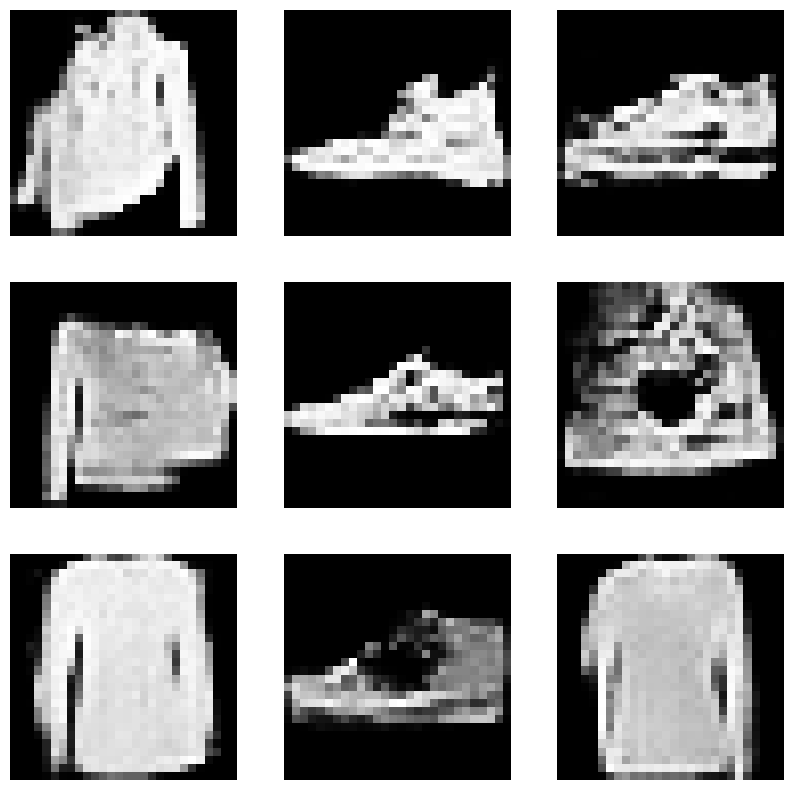

Epoch [11/100], Step [200/938], d_loss: 0.9965, g_loss: 1.7114, D(x): 0.57, D(G(z)): 0.26
Epoch [11/100], Step [400/938], d_loss: 0.8125, g_loss: 1.4731, D(x): 0.68, D(G(z)): 0.29
Epoch [11/100], Step [600/938], d_loss: 1.6511, g_loss: 1.7855, D(x): 0.35, D(G(z)): 0.27
Epoch [11/100], Step [800/938], d_loss: 1.2792, g_loss: 1.7036, D(x): 0.52, D(G(z)): 0.33


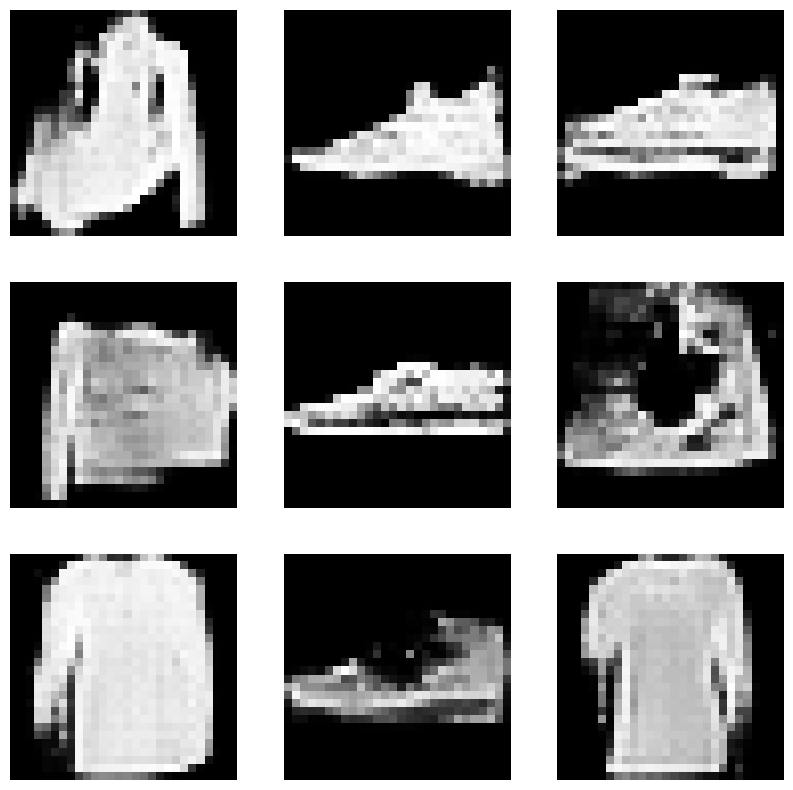

Epoch [12/100], Step [200/938], d_loss: 0.9416, g_loss: 1.3304, D(x): 0.72, D(G(z)): 0.40
Epoch [12/100], Step [400/938], d_loss: 1.0942, g_loss: 1.6038, D(x): 0.62, D(G(z)): 0.36
Epoch [12/100], Step [600/938], d_loss: 0.9413, g_loss: 1.2282, D(x): 0.73, D(G(z)): 0.39
Epoch [12/100], Step [800/938], d_loss: 0.9258, g_loss: 1.1999, D(x): 0.66, D(G(z)): 0.30


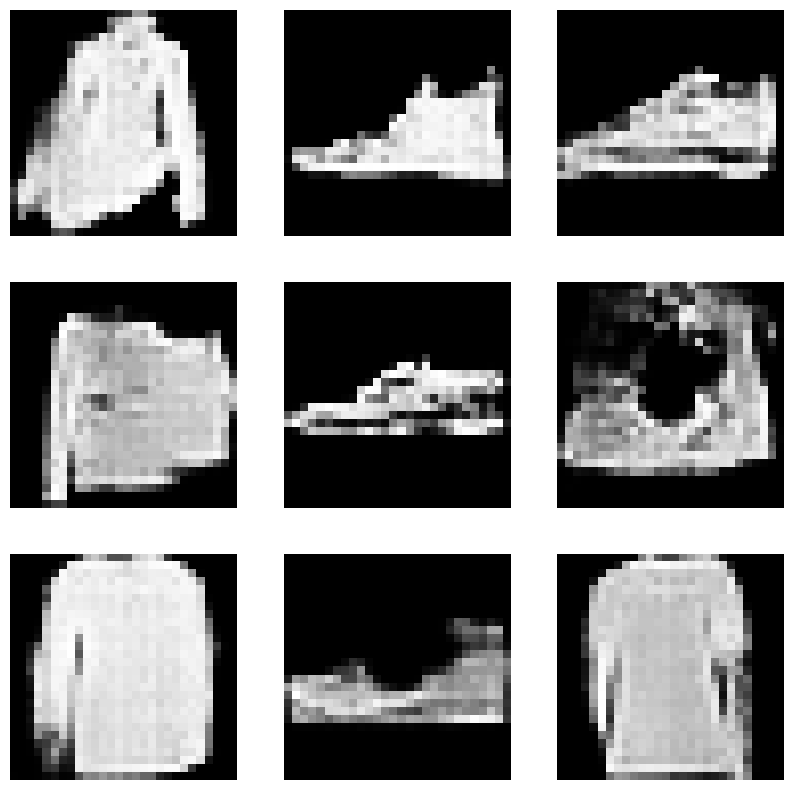

Epoch [13/100], Step [200/938], d_loss: 1.0214, g_loss: 1.8315, D(x): 0.59, D(G(z)): 0.30
Epoch [13/100], Step [400/938], d_loss: 1.0087, g_loss: 1.3322, D(x): 0.57, D(G(z)): 0.23
Epoch [13/100], Step [600/938], d_loss: 0.9236, g_loss: 1.7742, D(x): 0.68, D(G(z)): 0.35
Epoch [13/100], Step [800/938], d_loss: 0.8035, g_loss: 1.3263, D(x): 0.70, D(G(z)): 0.31


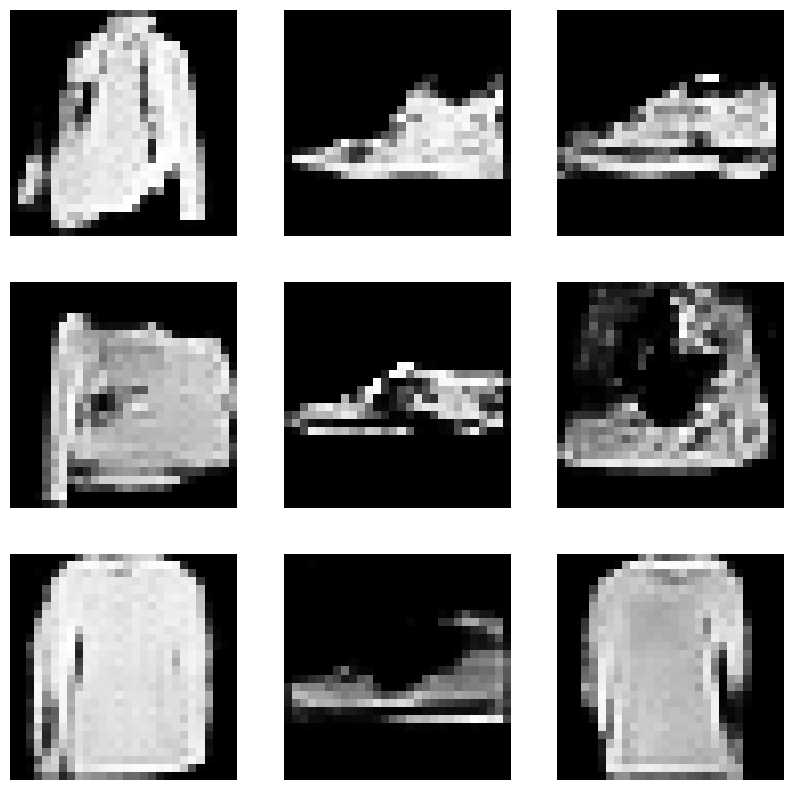

Epoch [14/100], Step [200/938], d_loss: 0.7862, g_loss: 1.0029, D(x): 0.80, D(G(z)): 0.37
Epoch [14/100], Step [400/938], d_loss: 0.8596, g_loss: 1.2317, D(x): 0.67, D(G(z)): 0.29
Epoch [14/100], Step [600/938], d_loss: 1.2910, g_loss: 0.6384, D(x): 0.58, D(G(z)): 0.43
Epoch [14/100], Step [800/938], d_loss: 0.9664, g_loss: 0.9274, D(x): 0.65, D(G(z)): 0.34


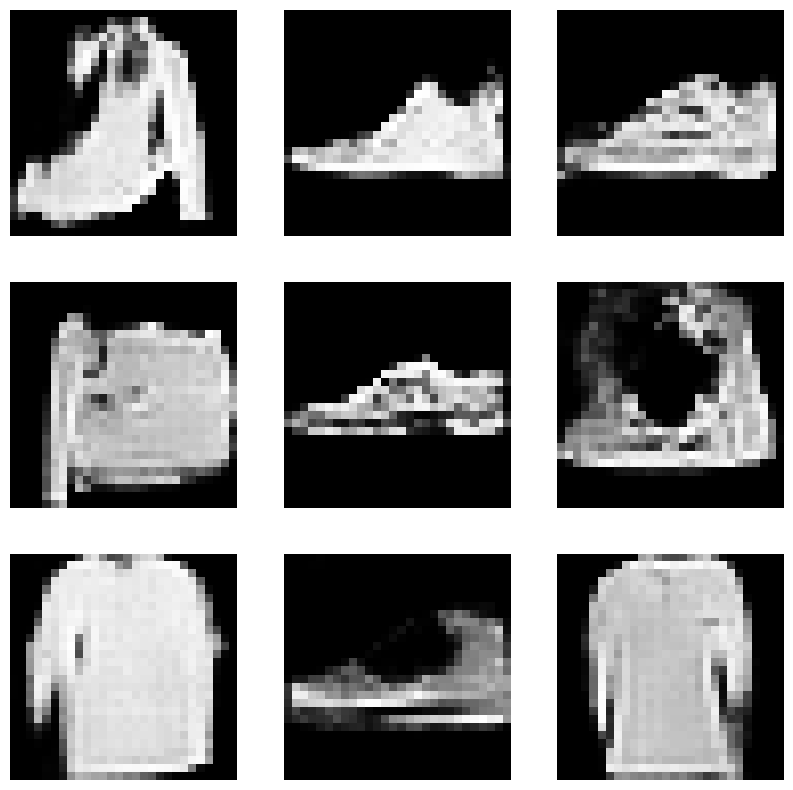

Epoch [15/100], Step [200/938], d_loss: 0.9722, g_loss: 1.3594, D(x): 0.68, D(G(z)): 0.34
Epoch [15/100], Step [400/938], d_loss: 1.1786, g_loss: 1.7098, D(x): 0.46, D(G(z)): 0.23
Epoch [15/100], Step [600/938], d_loss: 0.8194, g_loss: 1.4718, D(x): 0.64, D(G(z)): 0.24
Epoch [15/100], Step [800/938], d_loss: 1.2070, g_loss: 1.1378, D(x): 0.50, D(G(z)): 0.28


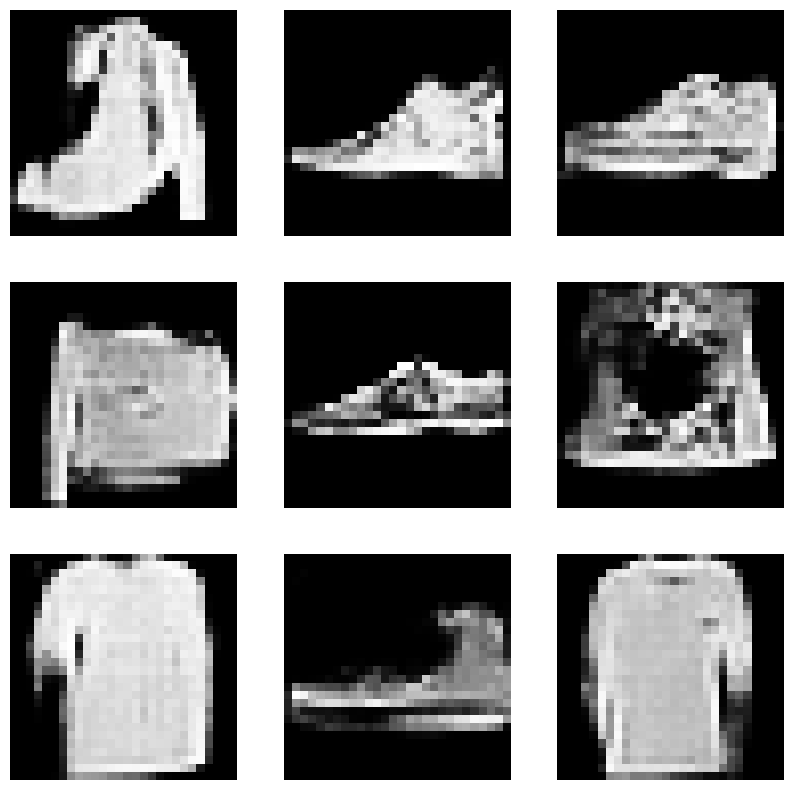

Epoch [16/100], Step [200/938], d_loss: 0.8941, g_loss: 1.2662, D(x): 0.67, D(G(z)): 0.31
Epoch [16/100], Step [400/938], d_loss: 0.9913, g_loss: 1.1712, D(x): 0.67, D(G(z)): 0.36
Epoch [16/100], Step [600/938], d_loss: 0.9743, g_loss: 1.4118, D(x): 0.68, D(G(z)): 0.38
Epoch [16/100], Step [800/938], d_loss: 1.1427, g_loss: 1.4569, D(x): 0.55, D(G(z)): 0.29


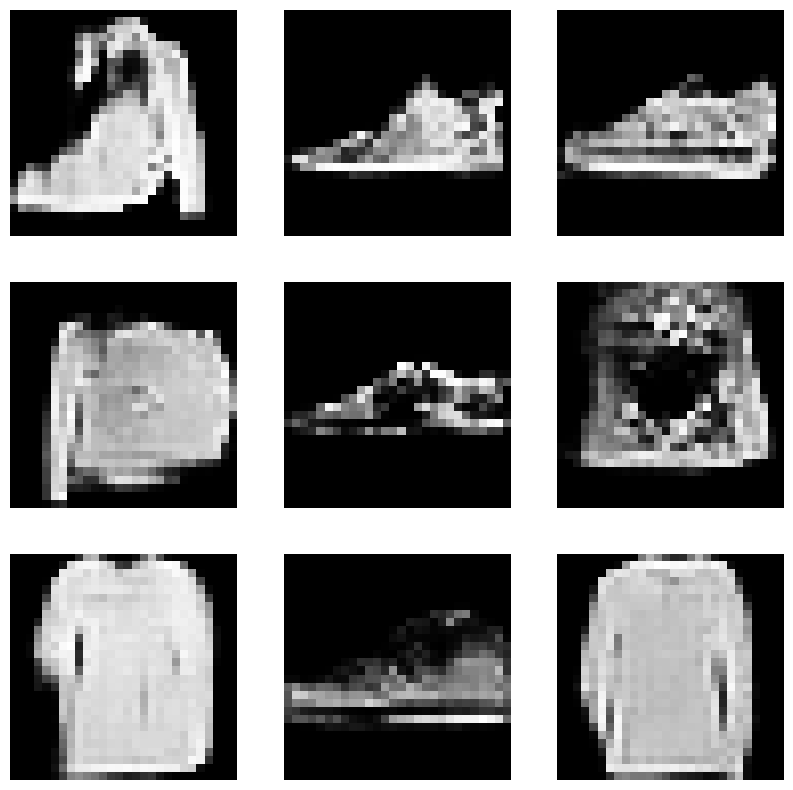

Epoch [17/100], Step [200/938], d_loss: 1.0038, g_loss: 1.4054, D(x): 0.62, D(G(z)): 0.32
Epoch [17/100], Step [400/938], d_loss: 1.0324, g_loss: 1.1146, D(x): 0.71, D(G(z)): 0.40
Epoch [17/100], Step [600/938], d_loss: 0.9926, g_loss: 1.3344, D(x): 0.59, D(G(z)): 0.25
Epoch [17/100], Step [800/938], d_loss: 0.8850, g_loss: 1.1858, D(x): 0.69, D(G(z)): 0.31


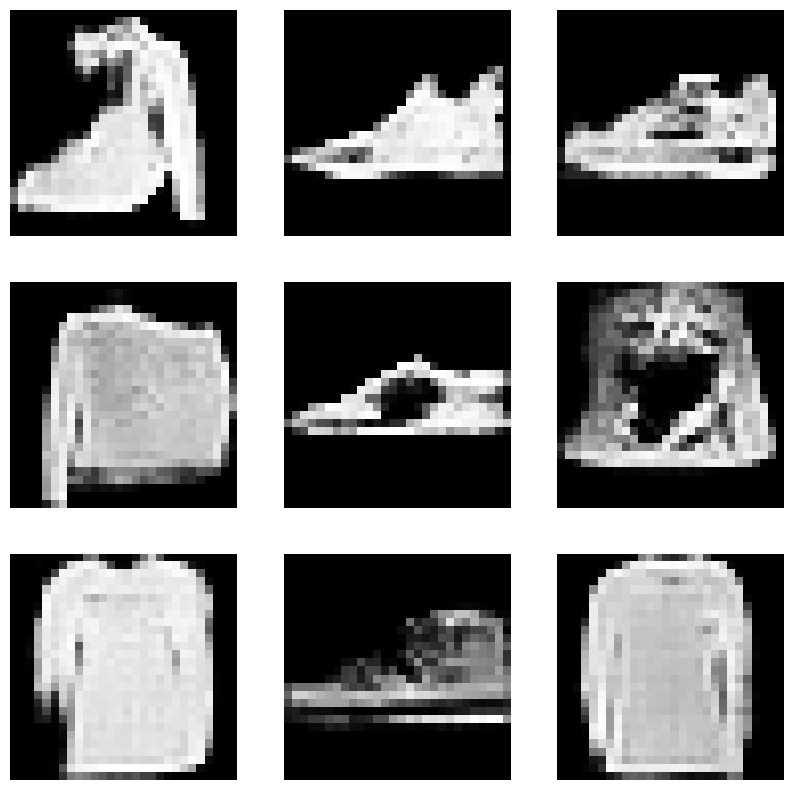

Epoch [18/100], Step [200/938], d_loss: 1.2931, g_loss: 1.9229, D(x): 0.50, D(G(z)): 0.32
Epoch [18/100], Step [400/938], d_loss: 0.9235, g_loss: 1.7877, D(x): 0.59, D(G(z)): 0.21
Epoch [18/100], Step [600/938], d_loss: 1.0747, g_loss: 1.4226, D(x): 0.61, D(G(z)): 0.33
Epoch [18/100], Step [800/938], d_loss: 1.0655, g_loss: 0.8781, D(x): 0.72, D(G(z)): 0.44


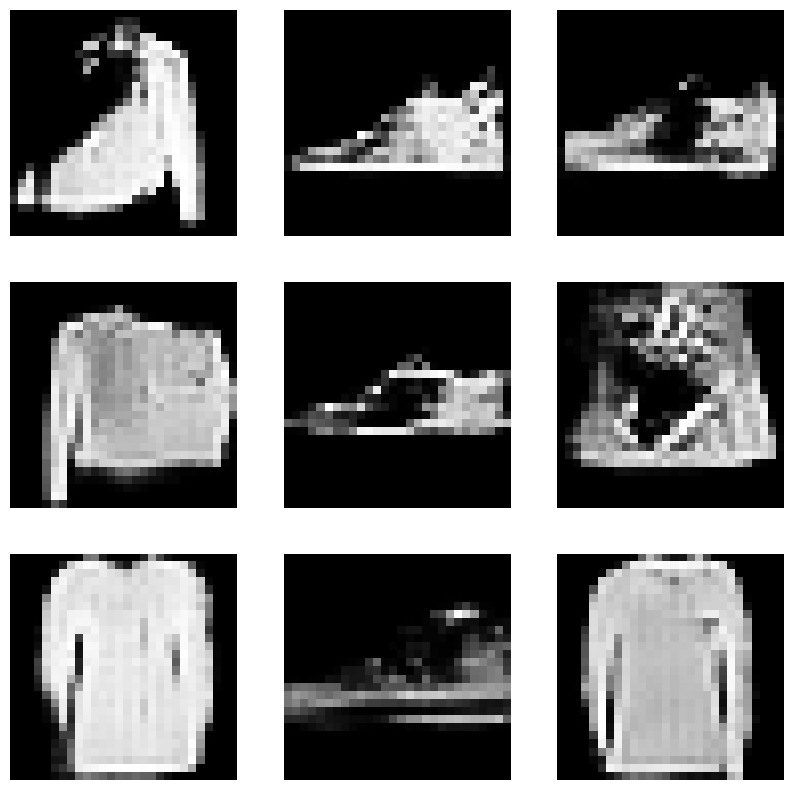

Epoch [19/100], Step [200/938], d_loss: 0.9983, g_loss: 1.0246, D(x): 0.68, D(G(z)): 0.38
Epoch [19/100], Step [400/938], d_loss: 0.9713, g_loss: 1.6170, D(x): 0.63, D(G(z)): 0.34
Epoch [19/100], Step [600/938], d_loss: 0.8502, g_loss: 1.4126, D(x): 0.65, D(G(z)): 0.27
Epoch [19/100], Step [800/938], d_loss: 0.7903, g_loss: 1.7773, D(x): 0.68, D(G(z)): 0.28


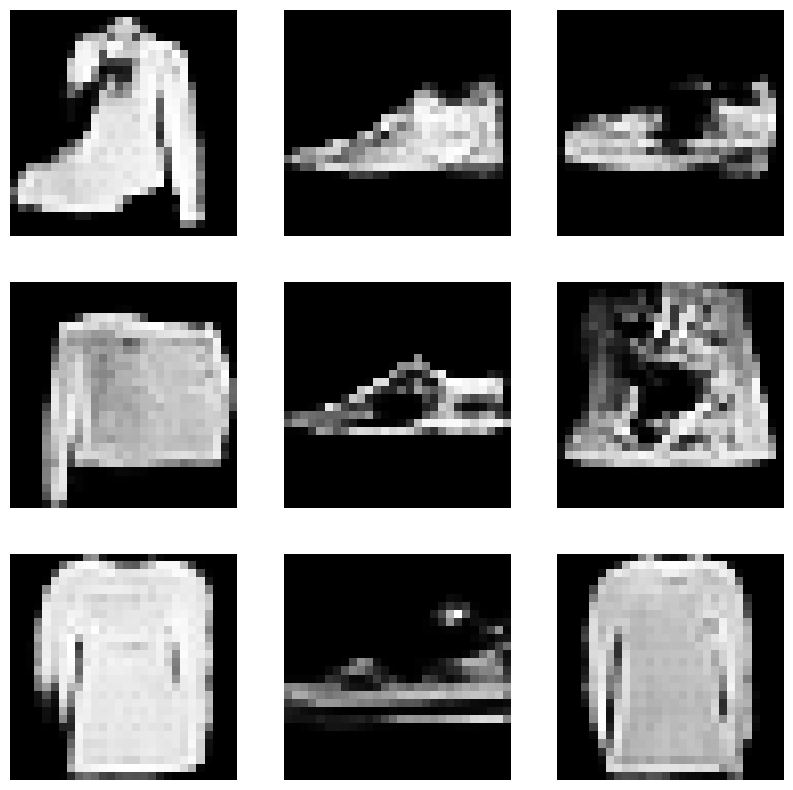

Epoch [20/100], Step [200/938], d_loss: 1.0500, g_loss: 1.0342, D(x): 0.61, D(G(z)): 0.33
Epoch [20/100], Step [400/938], d_loss: 0.9238, g_loss: 1.2396, D(x): 0.76, D(G(z)): 0.42
Epoch [20/100], Step [600/938], d_loss: 0.8571, g_loss: 1.6139, D(x): 0.81, D(G(z)): 0.42
Epoch [20/100], Step [800/938], d_loss: 0.9891, g_loss: 0.9696, D(x): 0.79, D(G(z)): 0.47


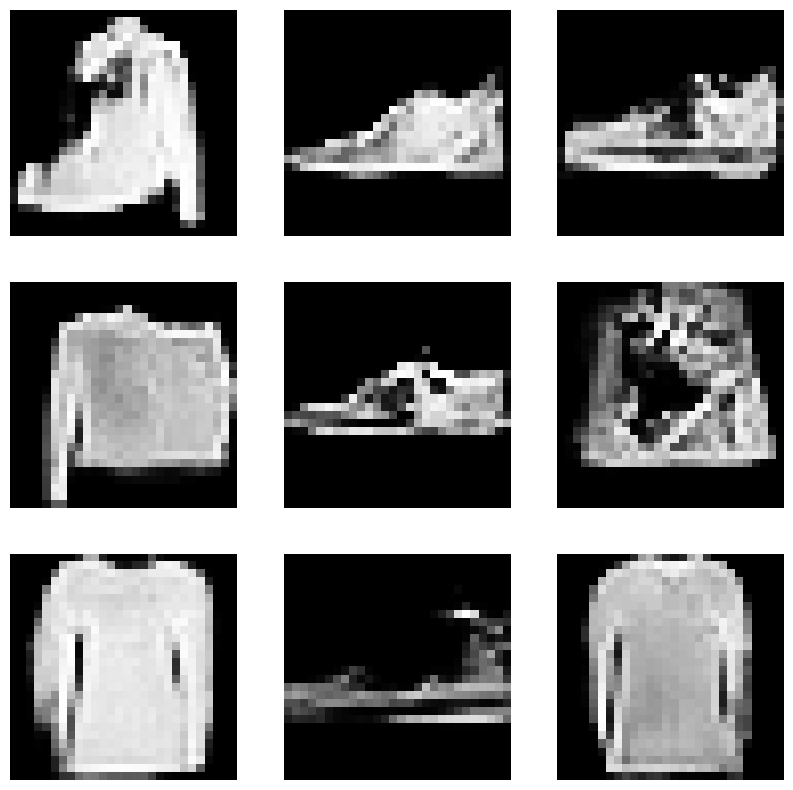

Epoch [21/100], Step [200/938], d_loss: 0.9674, g_loss: 1.7399, D(x): 0.55, D(G(z)): 0.23
Epoch [21/100], Step [400/938], d_loss: 0.9795, g_loss: 0.9102, D(x): 0.76, D(G(z)): 0.44
Epoch [21/100], Step [600/938], d_loss: 1.1230, g_loss: 1.1945, D(x): 0.55, D(G(z)): 0.28
Epoch [21/100], Step [800/938], d_loss: 1.0928, g_loss: 1.3181, D(x): 0.60, D(G(z)): 0.38


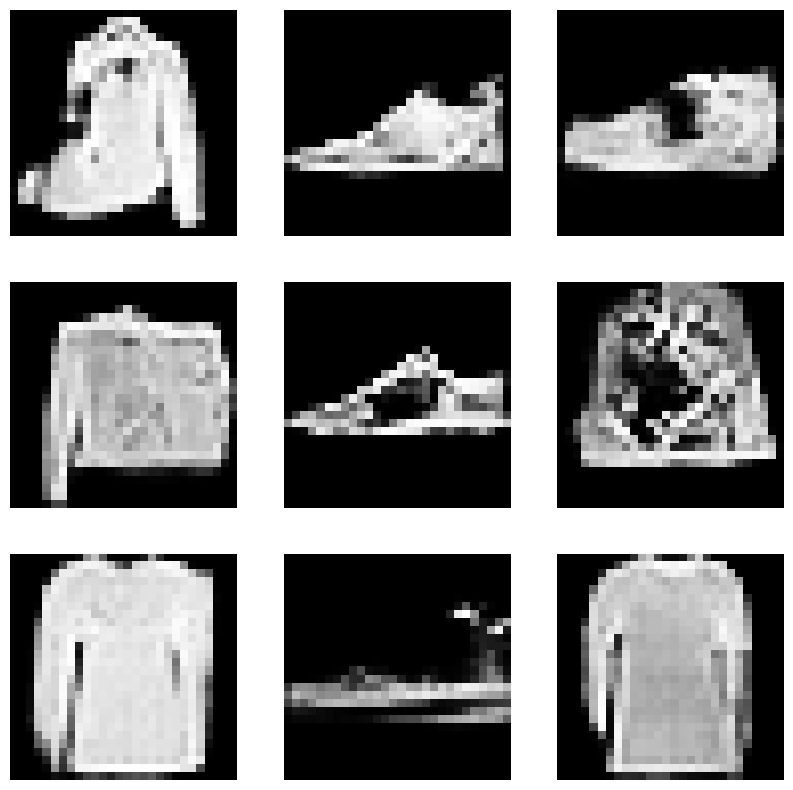

Epoch [22/100], Step [200/938], d_loss: 0.7814, g_loss: 1.0952, D(x): 0.75, D(G(z)): 0.34
Epoch [22/100], Step [400/938], d_loss: 1.1380, g_loss: 1.3474, D(x): 0.79, D(G(z)): 0.51
Epoch [22/100], Step [600/938], d_loss: 0.7101, g_loss: 1.4360, D(x): 0.73, D(G(z)): 0.27
Epoch [22/100], Step [800/938], d_loss: 0.9549, g_loss: 1.4734, D(x): 0.60, D(G(z)): 0.30


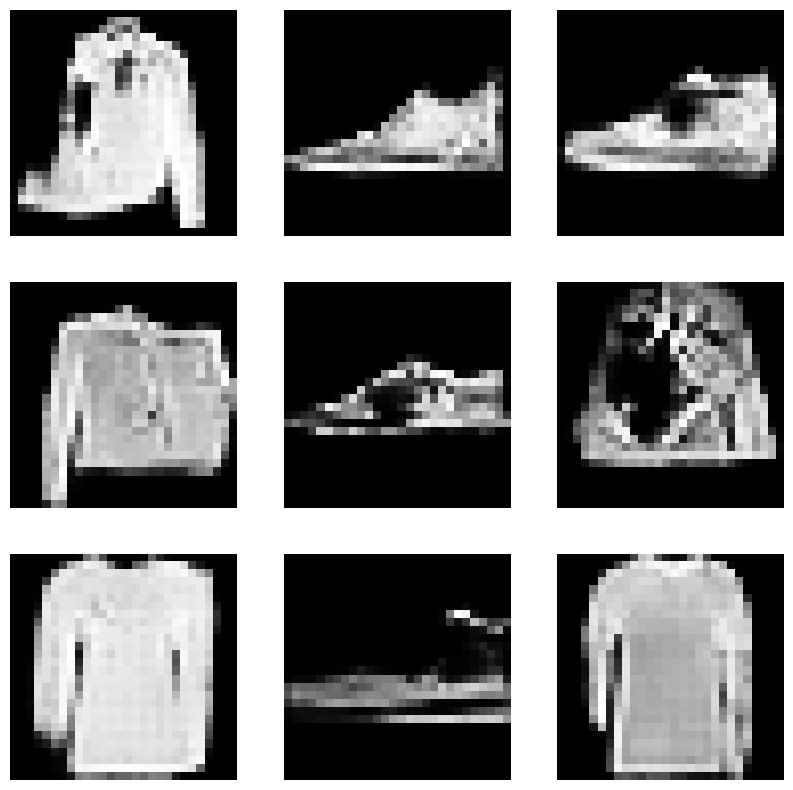

Epoch [23/100], Step [200/938], d_loss: 0.7438, g_loss: 1.3010, D(x): 0.74, D(G(z)): 0.28
Epoch [23/100], Step [400/938], d_loss: 1.1736, g_loss: 1.3979, D(x): 0.55, D(G(z)): 0.30
Epoch [23/100], Step [600/938], d_loss: 1.1190, g_loss: 1.2509, D(x): 0.65, D(G(z)): 0.42
Epoch [23/100], Step [800/938], d_loss: 1.2006, g_loss: 1.3807, D(x): 0.54, D(G(z)): 0.33


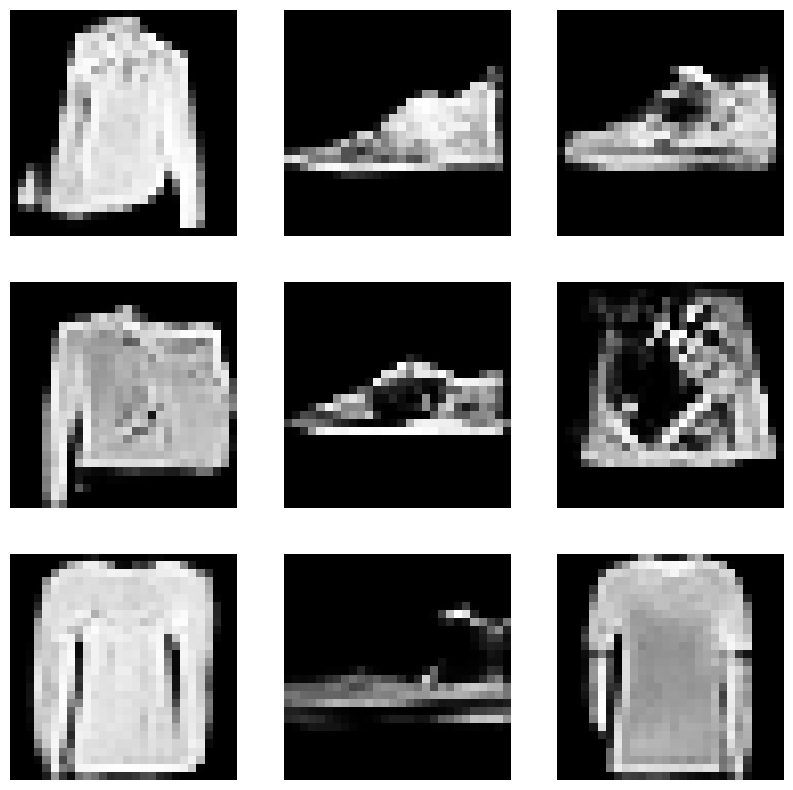

Epoch [24/100], Step [200/938], d_loss: 1.1904, g_loss: 1.2654, D(x): 0.56, D(G(z)): 0.37
Epoch [24/100], Step [400/938], d_loss: 1.1396, g_loss: 1.1293, D(x): 0.68, D(G(z)): 0.45
Epoch [24/100], Step [600/938], d_loss: 1.1708, g_loss: 1.4035, D(x): 0.72, D(G(z)): 0.49
Epoch [24/100], Step [800/938], d_loss: 1.1151, g_loss: 0.6256, D(x): 0.71, D(G(z)): 0.47


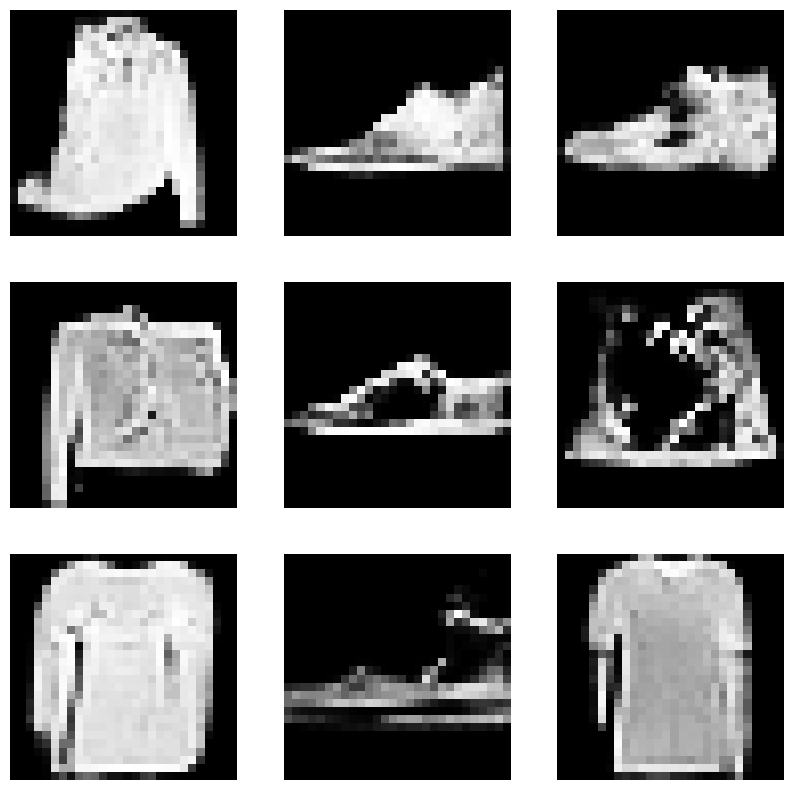

Epoch [25/100], Step [200/938], d_loss: 0.9147, g_loss: 1.6190, D(x): 0.68, D(G(z)): 0.33
Epoch [25/100], Step [400/938], d_loss: 0.9319, g_loss: 1.7623, D(x): 0.60, D(G(z)): 0.28
Epoch [25/100], Step [600/938], d_loss: 0.9240, g_loss: 1.2642, D(x): 0.63, D(G(z)): 0.30
Epoch [25/100], Step [800/938], d_loss: 0.7675, g_loss: 1.3564, D(x): 0.69, D(G(z)): 0.28


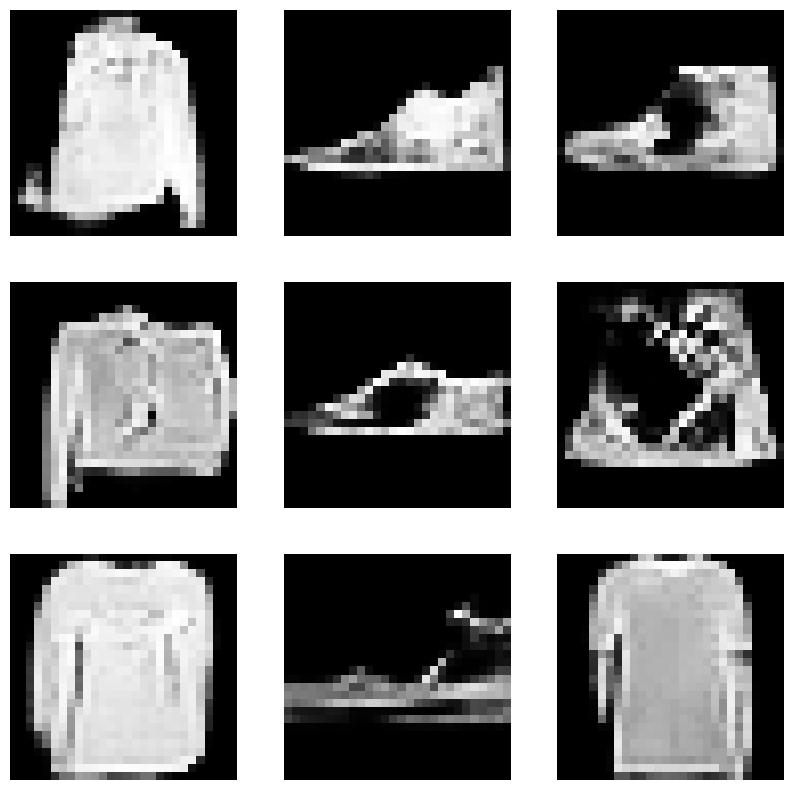

Epoch [26/100], Step [200/938], d_loss: 1.0305, g_loss: 1.4302, D(x): 0.65, D(G(z)): 0.36
Epoch [26/100], Step [400/938], d_loss: 1.0225, g_loss: 1.4861, D(x): 0.56, D(G(z)): 0.25
Epoch [26/100], Step [600/938], d_loss: 0.9031, g_loss: 2.0323, D(x): 0.57, D(G(z)): 0.21
Epoch [26/100], Step [800/938], d_loss: 1.0461, g_loss: 2.0261, D(x): 0.56, D(G(z)): 0.29


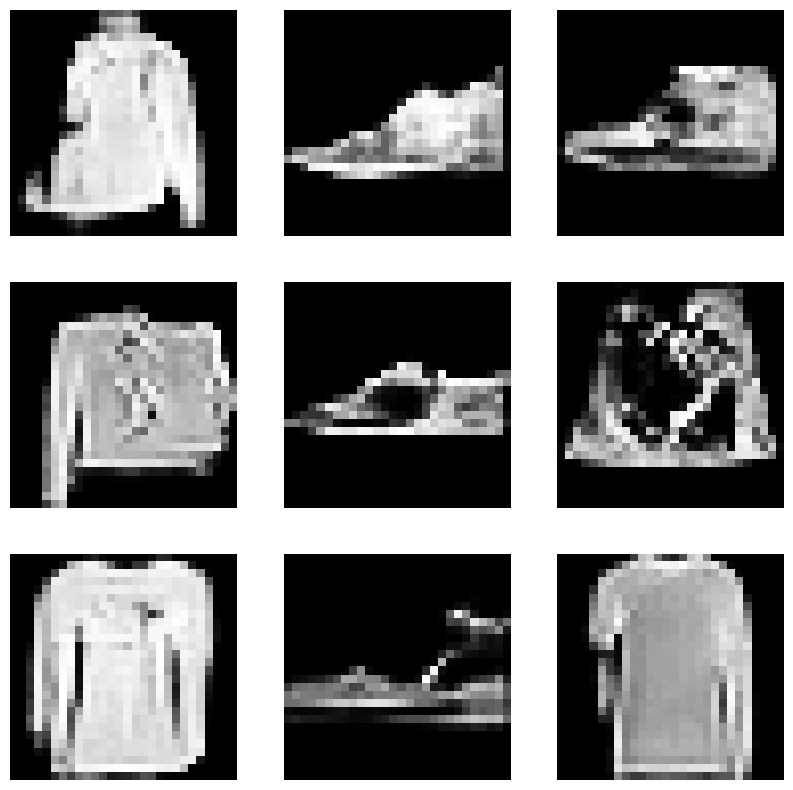

Epoch [27/100], Step [200/938], d_loss: 0.9860, g_loss: 1.4263, D(x): 0.65, D(G(z)): 0.36
Epoch [27/100], Step [400/938], d_loss: 1.1878, g_loss: 1.1526, D(x): 0.63, D(G(z)): 0.44
Epoch [27/100], Step [600/938], d_loss: 0.8720, g_loss: 1.2346, D(x): 0.67, D(G(z)): 0.31
Epoch [27/100], Step [800/938], d_loss: 0.8039, g_loss: 1.5012, D(x): 0.64, D(G(z)): 0.19


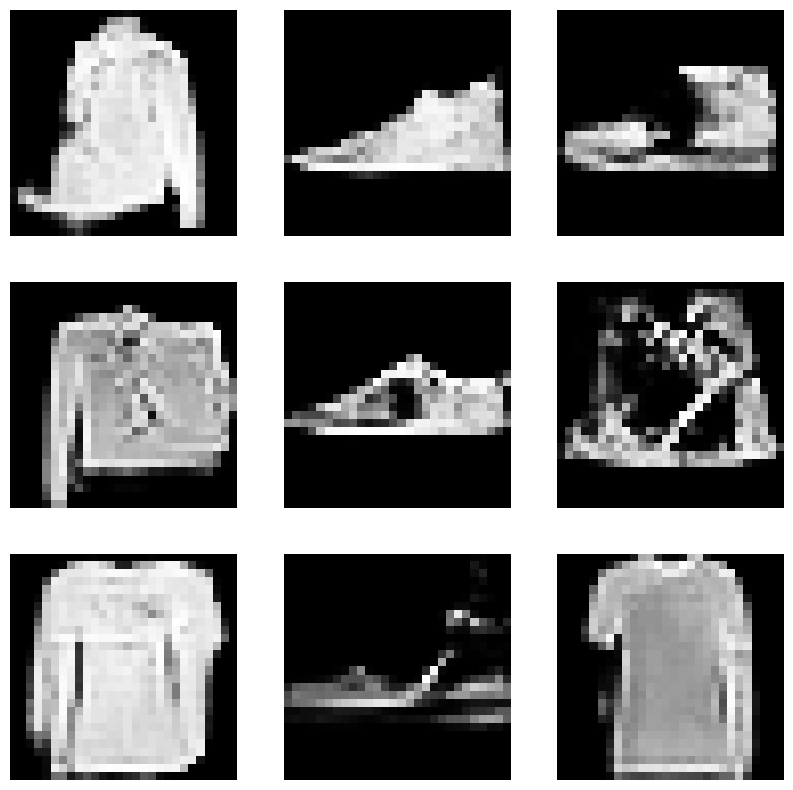

Epoch [28/100], Step [200/938], d_loss: 1.2490, g_loss: 1.0483, D(x): 0.68, D(G(z)): 0.47
Epoch [28/100], Step [400/938], d_loss: 0.9803, g_loss: 1.3759, D(x): 0.70, D(G(z)): 0.38
Epoch [28/100], Step [600/938], d_loss: 1.0554, g_loss: 1.3462, D(x): 0.51, D(G(z)): 0.19
Epoch [28/100], Step [800/938], d_loss: 0.9198, g_loss: 1.1093, D(x): 0.72, D(G(z)): 0.38


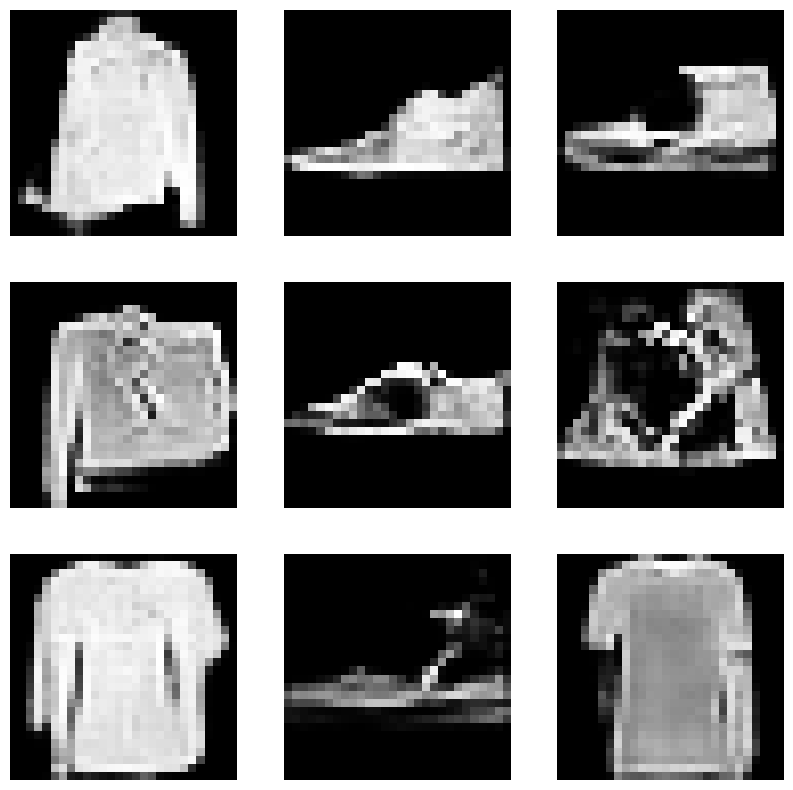

Epoch [29/100], Step [200/938], d_loss: 0.9411, g_loss: 1.6182, D(x): 0.63, D(G(z)): 0.31
Epoch [29/100], Step [400/938], d_loss: 0.8475, g_loss: 1.6444, D(x): 0.62, D(G(z)): 0.24
Epoch [29/100], Step [600/938], d_loss: 1.0511, g_loss: 1.0230, D(x): 0.70, D(G(z)): 0.42
Epoch [29/100], Step [800/938], d_loss: 0.6780, g_loss: 1.2169, D(x): 0.67, D(G(z)): 0.18


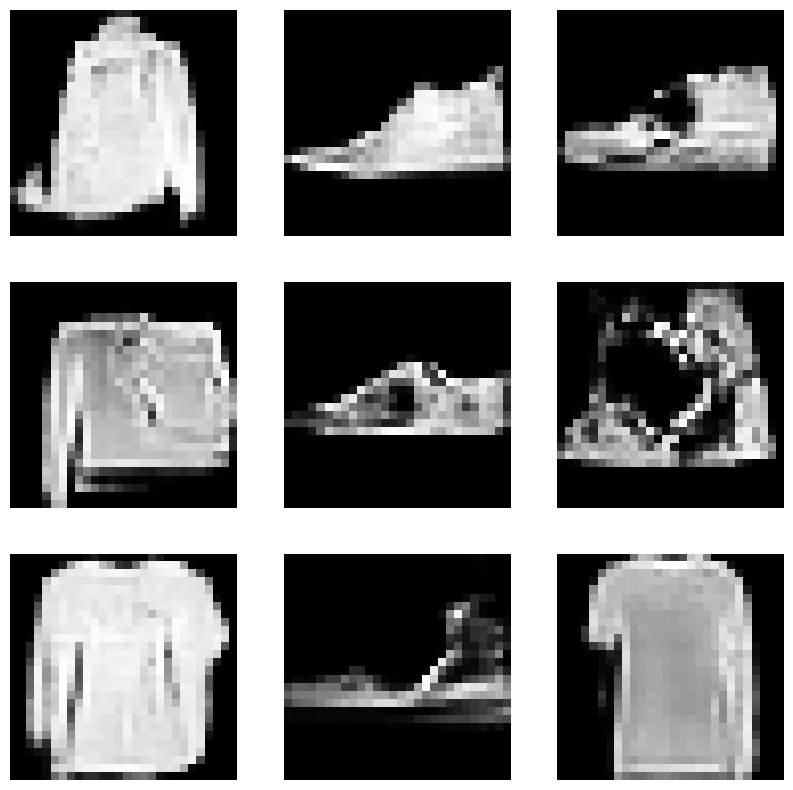

Epoch [30/100], Step [200/938], d_loss: 0.8461, g_loss: 1.1556, D(x): 0.65, D(G(z)): 0.27
Epoch [30/100], Step [400/938], d_loss: 0.9786, g_loss: 1.1644, D(x): 0.69, D(G(z)): 0.37
Epoch [30/100], Step [600/938], d_loss: 0.9390, g_loss: 0.9303, D(x): 0.72, D(G(z)): 0.38
Epoch [30/100], Step [800/938], d_loss: 0.9706, g_loss: 1.2008, D(x): 0.71, D(G(z)): 0.39


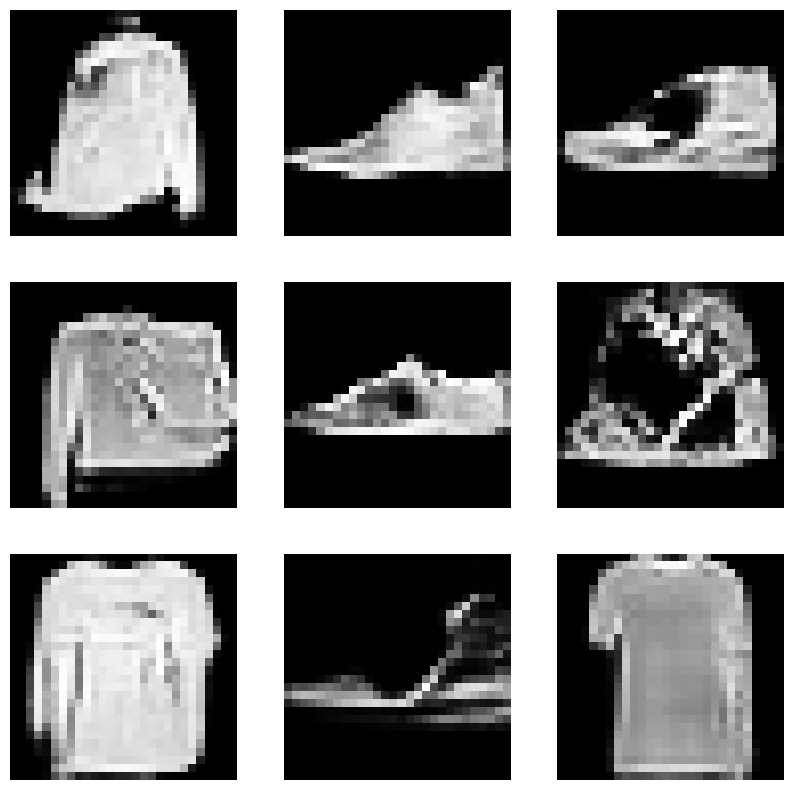

Epoch [31/100], Step [200/938], d_loss: 0.8430, g_loss: 1.4868, D(x): 0.72, D(G(z)): 0.33
Epoch [31/100], Step [400/938], d_loss: 0.7709, g_loss: 1.6591, D(x): 0.67, D(G(z)): 0.25
Epoch [31/100], Step [600/938], d_loss: 0.8427, g_loss: 1.2237, D(x): 0.65, D(G(z)): 0.27
Epoch [31/100], Step [800/938], d_loss: 0.9496, g_loss: 1.4807, D(x): 0.61, D(G(z)): 0.26


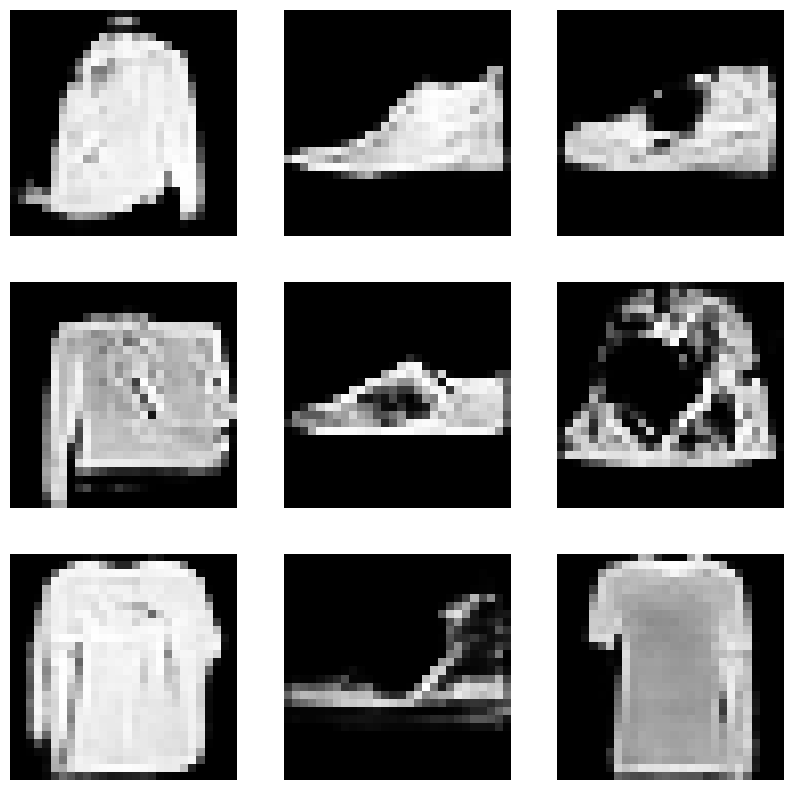

Epoch [32/100], Step [200/938], d_loss: 0.8550, g_loss: 1.4727, D(x): 0.70, D(G(z)): 0.33
Epoch [32/100], Step [400/938], d_loss: 0.9543, g_loss: 1.4560, D(x): 0.58, D(G(z)): 0.27
Epoch [32/100], Step [600/938], d_loss: 1.0993, g_loss: 1.5226, D(x): 0.56, D(G(z)): 0.30
Epoch [32/100], Step [800/938], d_loss: 1.0499, g_loss: 1.0799, D(x): 0.60, D(G(z)): 0.33


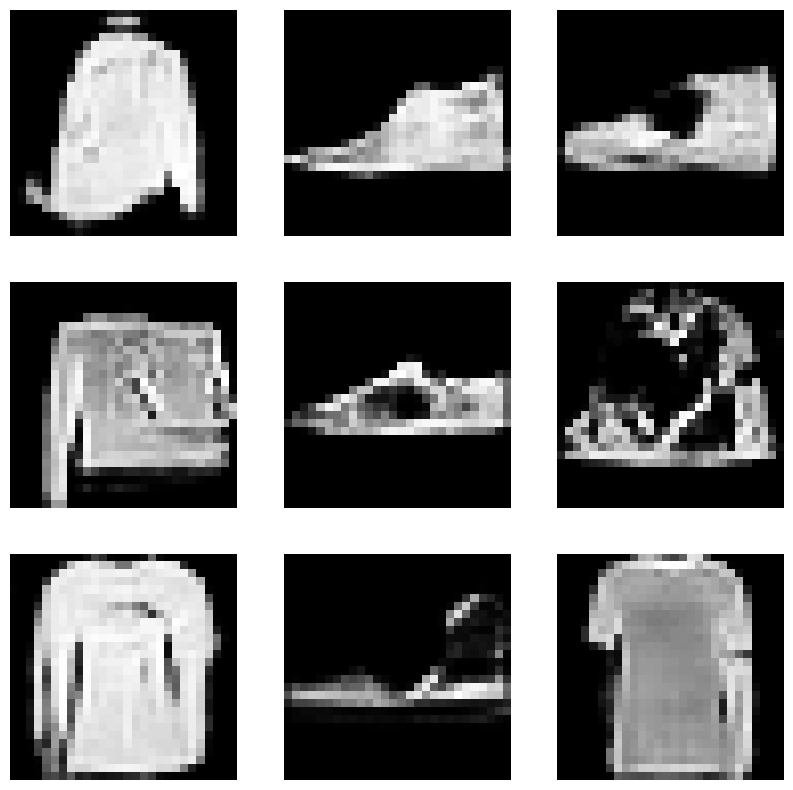

Epoch [33/100], Step [200/938], d_loss: 0.9327, g_loss: 1.1985, D(x): 0.66, D(G(z)): 0.32
Epoch [33/100], Step [400/938], d_loss: 0.7936, g_loss: 1.5401, D(x): 0.72, D(G(z)): 0.31
Epoch [33/100], Step [600/938], d_loss: 0.7565, g_loss: 1.4808, D(x): 0.69, D(G(z)): 0.26
Epoch [33/100], Step [800/938], d_loss: 0.9550, g_loss: 1.2947, D(x): 0.63, D(G(z)): 0.30


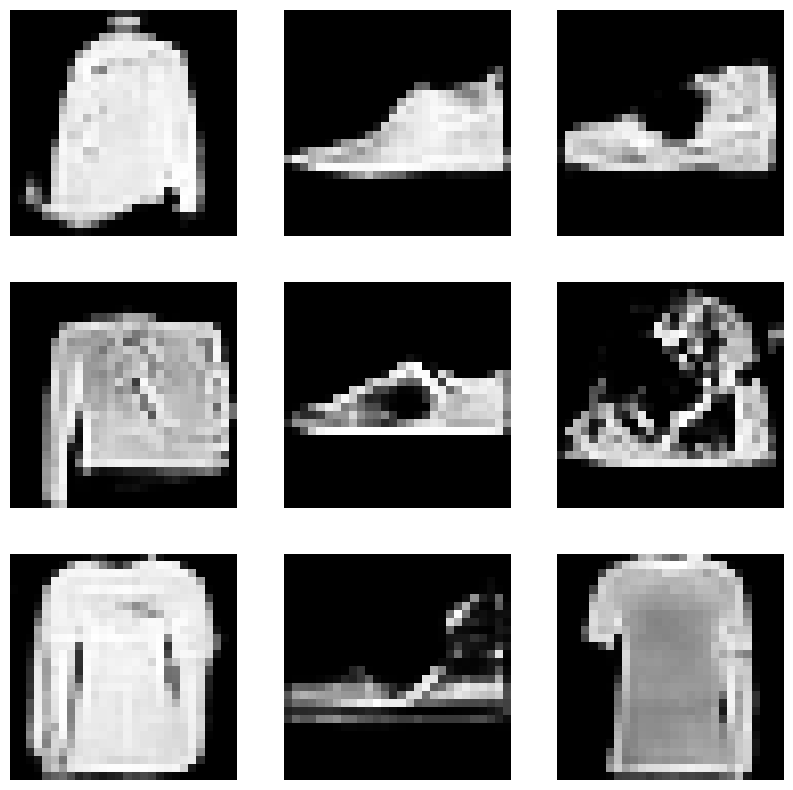

Epoch [34/100], Step [200/938], d_loss: 0.9470, g_loss: 1.5532, D(x): 0.61, D(G(z)): 0.27
Epoch [34/100], Step [400/938], d_loss: 0.8764, g_loss: 1.1455, D(x): 0.69, D(G(z)): 0.33
Epoch [34/100], Step [600/938], d_loss: 1.0936, g_loss: 1.2056, D(x): 0.70, D(G(z)): 0.45
Epoch [34/100], Step [800/938], d_loss: 1.0172, g_loss: 1.3595, D(x): 0.74, D(G(z)): 0.43


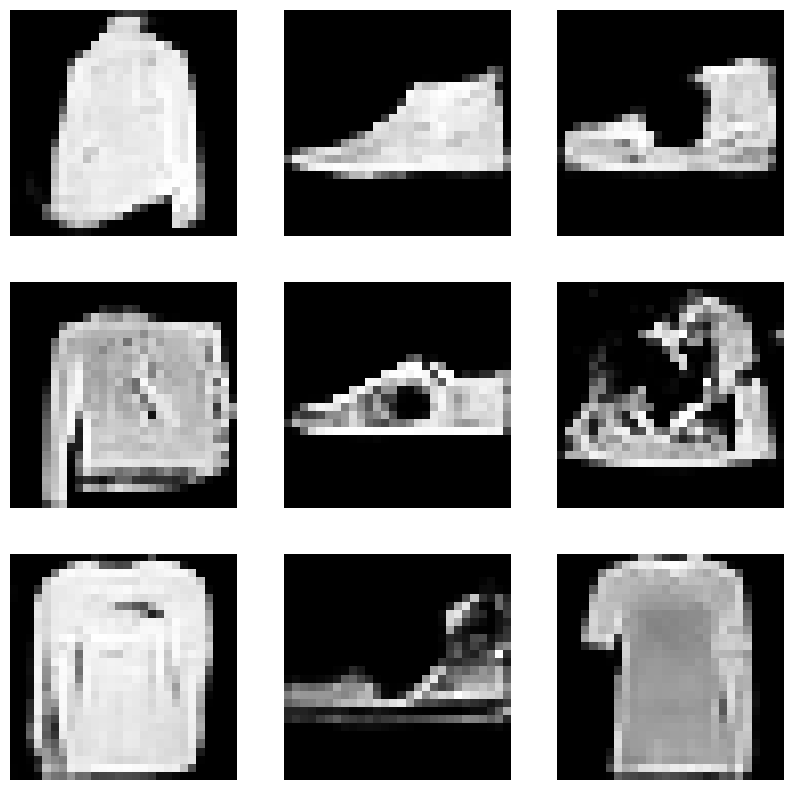

Epoch [35/100], Step [200/938], d_loss: 1.0370, g_loss: 1.2228, D(x): 0.58, D(G(z)): 0.30
Epoch [35/100], Step [400/938], d_loss: 1.0523, g_loss: 0.9736, D(x): 0.75, D(G(z)): 0.47
Epoch [35/100], Step [600/938], d_loss: 1.1345, g_loss: 1.2570, D(x): 0.68, D(G(z)): 0.42
Epoch [35/100], Step [800/938], d_loss: 0.8340, g_loss: 1.8452, D(x): 0.67, D(G(z)): 0.28


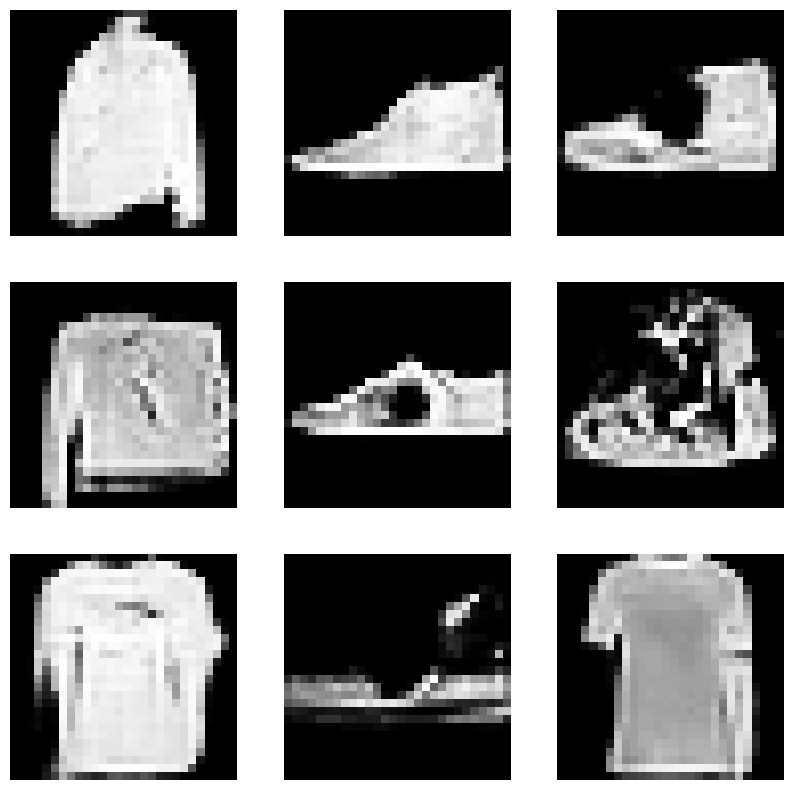

Epoch [36/100], Step [200/938], d_loss: 0.8663, g_loss: 2.0803, D(x): 0.69, D(G(z)): 0.31
Epoch [36/100], Step [400/938], d_loss: 1.1262, g_loss: 1.6190, D(x): 0.54, D(G(z)): 0.28
Epoch [36/100], Step [600/938], d_loss: 0.9174, g_loss: 1.6857, D(x): 0.74, D(G(z)): 0.38
Epoch [36/100], Step [800/938], d_loss: 1.9436, g_loss: 0.9656, D(x): 0.33, D(G(z)): 0.35


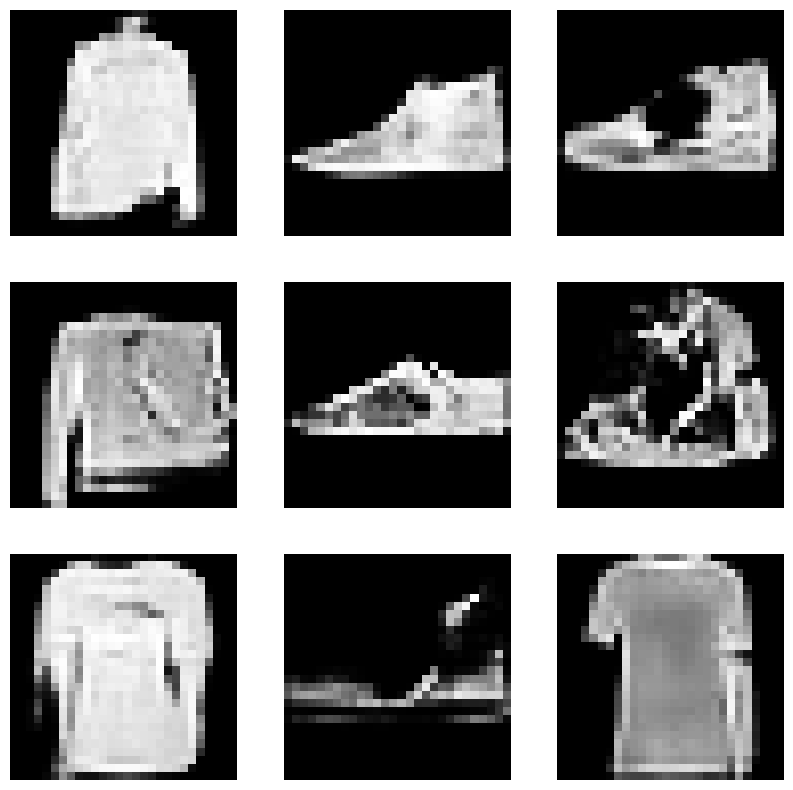

Epoch [37/100], Step [200/938], d_loss: 0.8767, g_loss: 1.7509, D(x): 0.75, D(G(z)): 0.35
Epoch [37/100], Step [400/938], d_loss: 0.9121, g_loss: 1.1179, D(x): 0.61, D(G(z)): 0.26
Epoch [37/100], Step [600/938], d_loss: 0.9021, g_loss: 1.4544, D(x): 0.77, D(G(z)): 0.40
Epoch [37/100], Step [800/938], d_loss: 1.1292, g_loss: 1.8072, D(x): 0.52, D(G(z)): 0.27


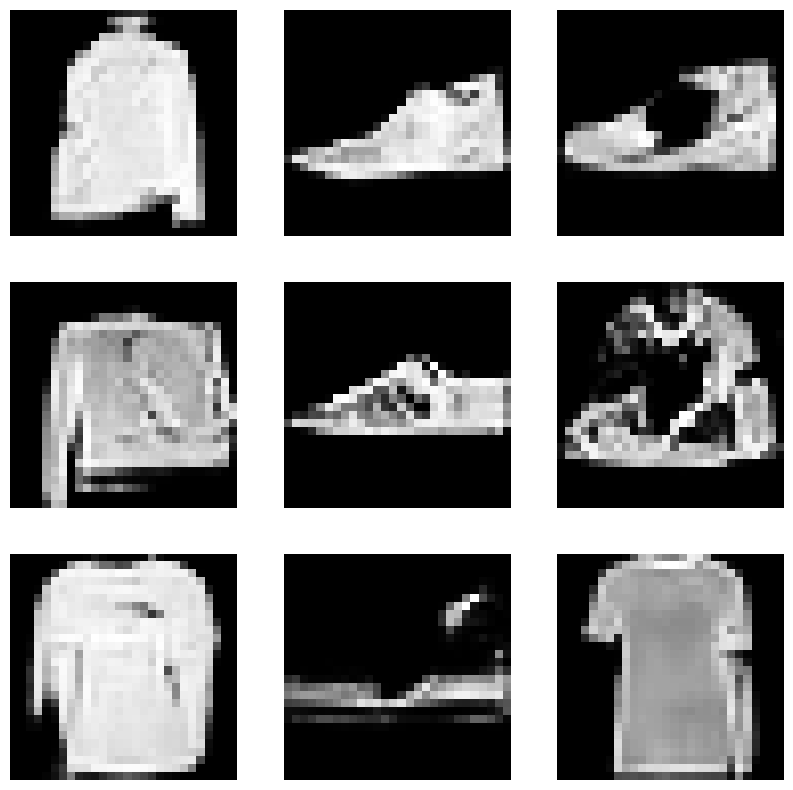

Epoch [38/100], Step [200/938], d_loss: 1.0428, g_loss: 1.5570, D(x): 0.54, D(G(z)): 0.23
Epoch [38/100], Step [400/938], d_loss: 0.7306, g_loss: 1.3339, D(x): 0.70, D(G(z)): 0.24
Epoch [38/100], Step [600/938], d_loss: 1.0039, g_loss: 1.1000, D(x): 0.61, D(G(z)): 0.30
Epoch [38/100], Step [800/938], d_loss: 0.9776, g_loss: 1.4312, D(x): 0.81, D(G(z)): 0.48


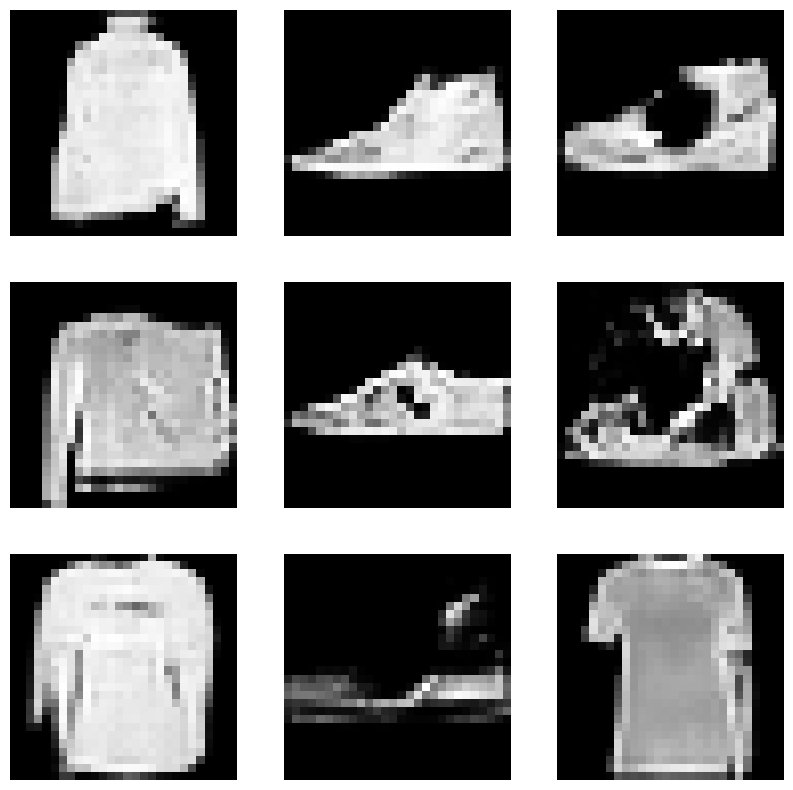

Epoch [39/100], Step [200/938], d_loss: 0.8706, g_loss: 1.6563, D(x): 0.80, D(G(z)): 0.41
Epoch [39/100], Step [400/938], d_loss: 0.9044, g_loss: 1.8133, D(x): 0.75, D(G(z)): 0.39
Epoch [39/100], Step [600/938], d_loss: 0.9679, g_loss: 1.2015, D(x): 0.63, D(G(z)): 0.32
Epoch [39/100], Step [800/938], d_loss: 0.7339, g_loss: 1.7560, D(x): 0.67, D(G(z)): 0.23


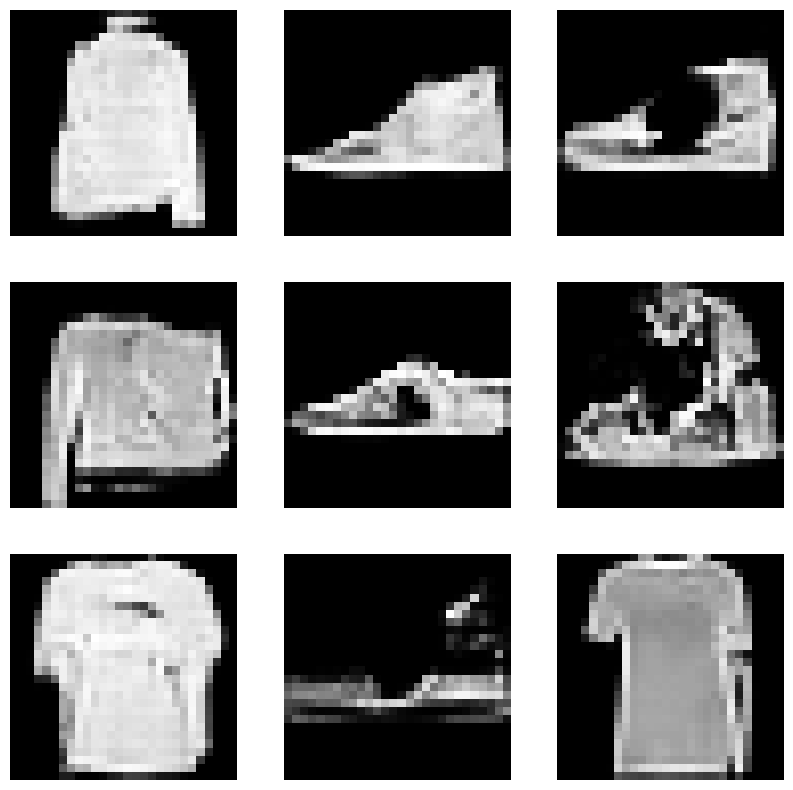

Epoch [40/100], Step [200/938], d_loss: 1.0121, g_loss: 1.2720, D(x): 0.63, D(G(z)): 0.36
Epoch [40/100], Step [400/938], d_loss: 0.9712, g_loss: 1.4900, D(x): 0.68, D(G(z)): 0.37
Epoch [40/100], Step [600/938], d_loss: 0.5994, g_loss: 1.8026, D(x): 0.79, D(G(z)): 0.28
Epoch [40/100], Step [800/938], d_loss: 0.7802, g_loss: 1.2139, D(x): 0.72, D(G(z)): 0.31


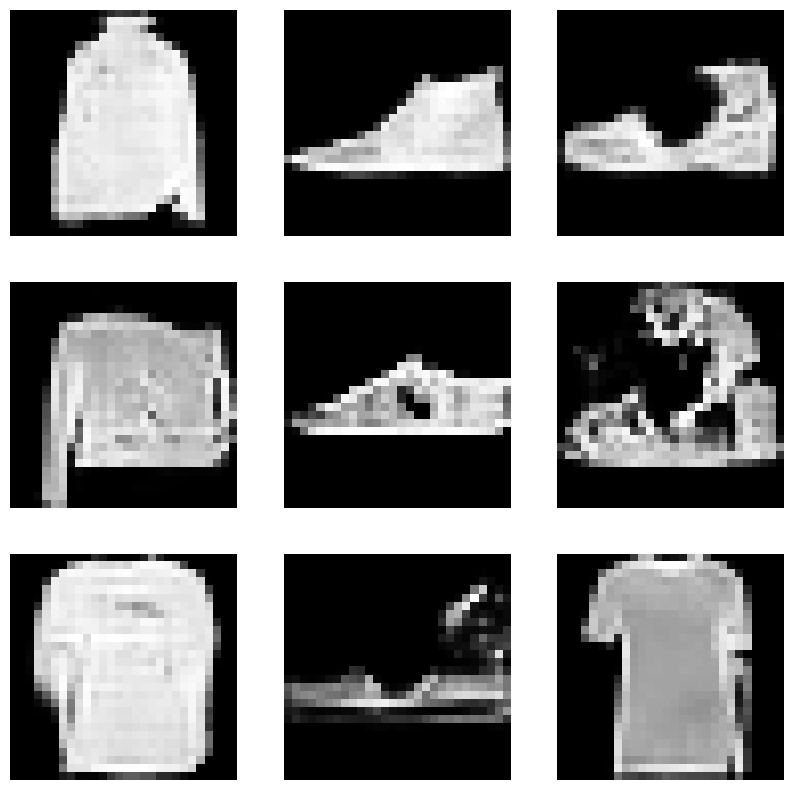

Epoch [41/100], Step [200/938], d_loss: 0.9531, g_loss: 1.2004, D(x): 0.67, D(G(z)): 0.34
Epoch [41/100], Step [400/938], d_loss: 1.1121, g_loss: 1.5604, D(x): 0.56, D(G(z)): 0.29
Epoch [41/100], Step [600/938], d_loss: 0.6460, g_loss: 1.5558, D(x): 0.75, D(G(z)): 0.25
Epoch [41/100], Step [800/938], d_loss: 0.8546, g_loss: 2.0852, D(x): 0.68, D(G(z)): 0.30


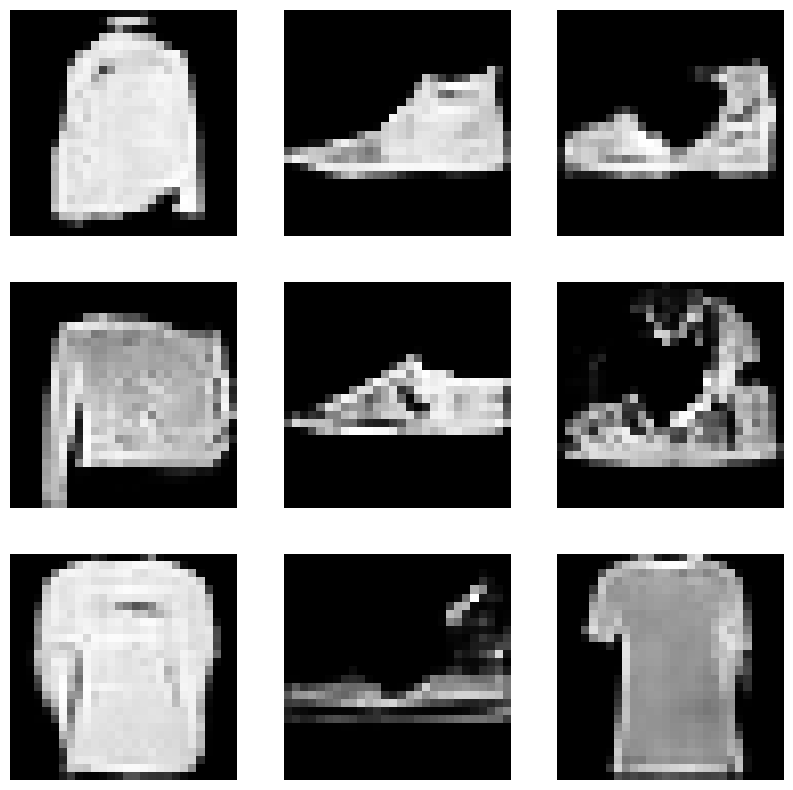

Epoch [42/100], Step [200/938], d_loss: 0.8242, g_loss: 1.7477, D(x): 0.63, D(G(z)): 0.21
Epoch [42/100], Step [400/938], d_loss: 0.5941, g_loss: 1.5493, D(x): 0.70, D(G(z)): 0.16
Epoch [42/100], Step [600/938], d_loss: 1.0835, g_loss: 0.9481, D(x): 0.68, D(G(z)): 0.41
Epoch [42/100], Step [800/938], d_loss: 1.0037, g_loss: 1.8043, D(x): 0.59, D(G(z)): 0.27


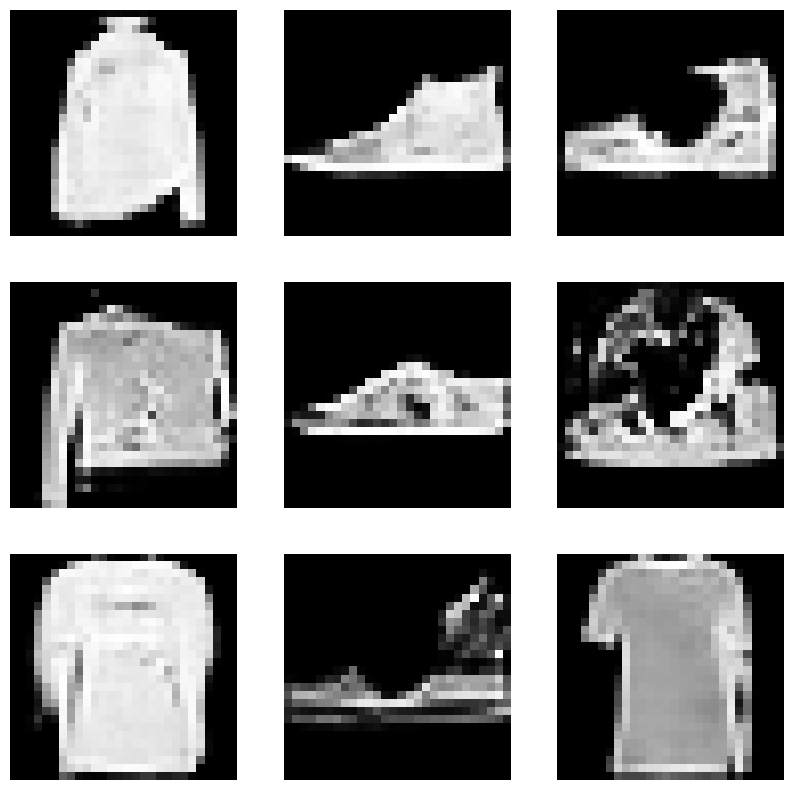

Epoch [43/100], Step [200/938], d_loss: 0.7078, g_loss: 1.6445, D(x): 0.69, D(G(z)): 0.20
Epoch [43/100], Step [400/938], d_loss: 1.0853, g_loss: 0.7999, D(x): 0.63, D(G(z)): 0.39
Epoch [43/100], Step [600/938], d_loss: 0.7492, g_loss: 1.5391, D(x): 0.71, D(G(z)): 0.25
Epoch [43/100], Step [800/938], d_loss: 0.9664, g_loss: 1.3607, D(x): 0.76, D(G(z)): 0.43


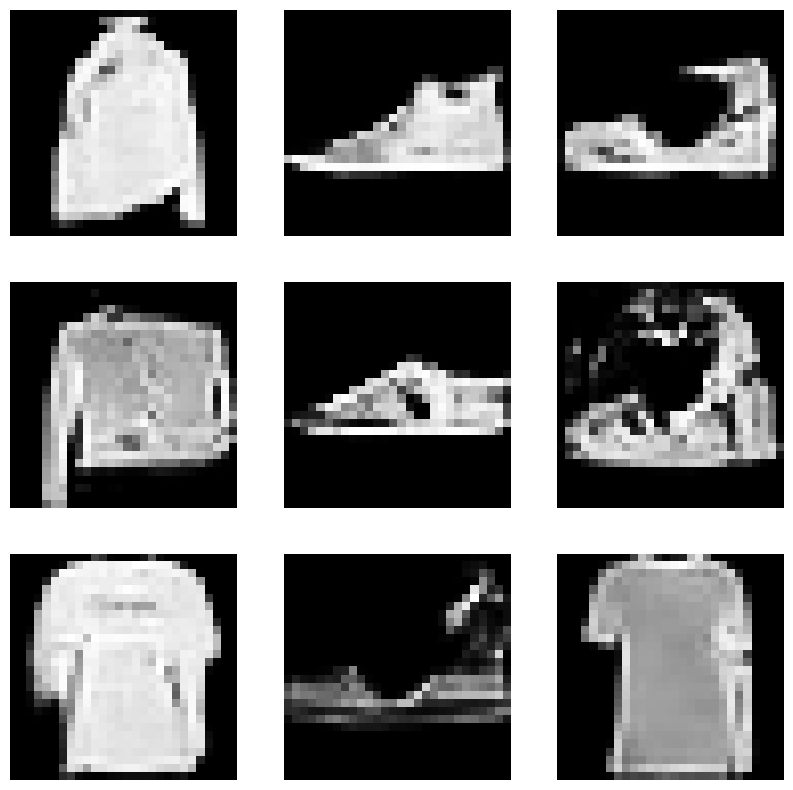

Epoch [44/100], Step [200/938], d_loss: 0.7225, g_loss: 1.5466, D(x): 0.82, D(G(z)): 0.35
Epoch [44/100], Step [400/938], d_loss: 0.8211, g_loss: 1.2244, D(x): 0.81, D(G(z)): 0.39
Epoch [44/100], Step [600/938], d_loss: 0.7161, g_loss: 1.0001, D(x): 0.85, D(G(z)): 0.33
Epoch [44/100], Step [800/938], d_loss: 0.8355, g_loss: 0.9403, D(x): 0.77, D(G(z)): 0.37


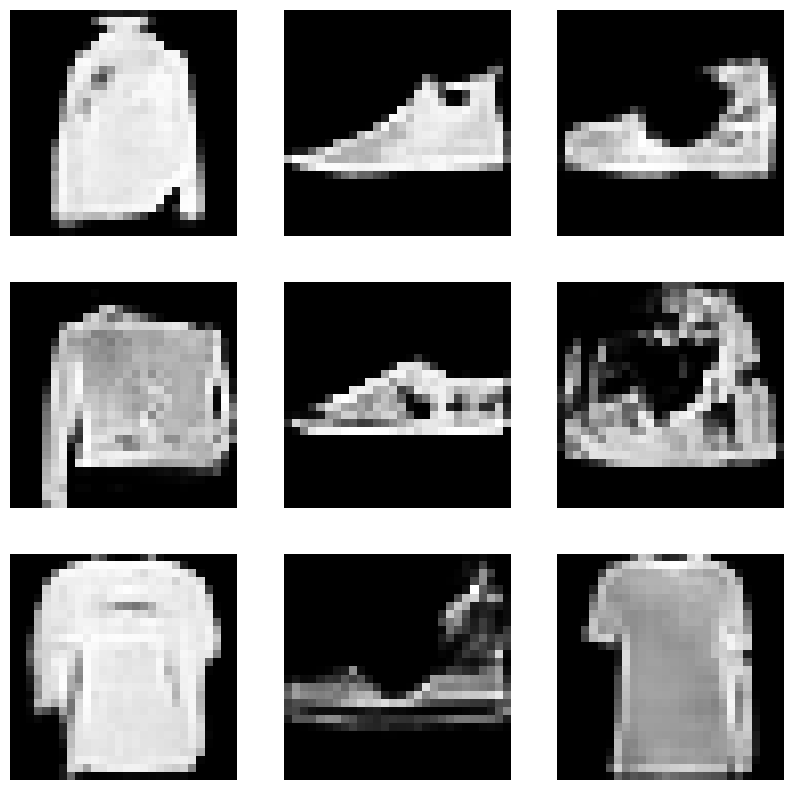

Epoch [45/100], Step [200/938], d_loss: 0.8260, g_loss: 1.7176, D(x): 0.70, D(G(z)): 0.31
Epoch [45/100], Step [400/938], d_loss: 0.8860, g_loss: 1.3279, D(x): 0.70, D(G(z)): 0.34
Epoch [45/100], Step [600/938], d_loss: 0.8345, g_loss: 1.8255, D(x): 0.68, D(G(z)): 0.29
Epoch [45/100], Step [800/938], d_loss: 0.7794, g_loss: 1.3812, D(x): 0.65, D(G(z)): 0.23


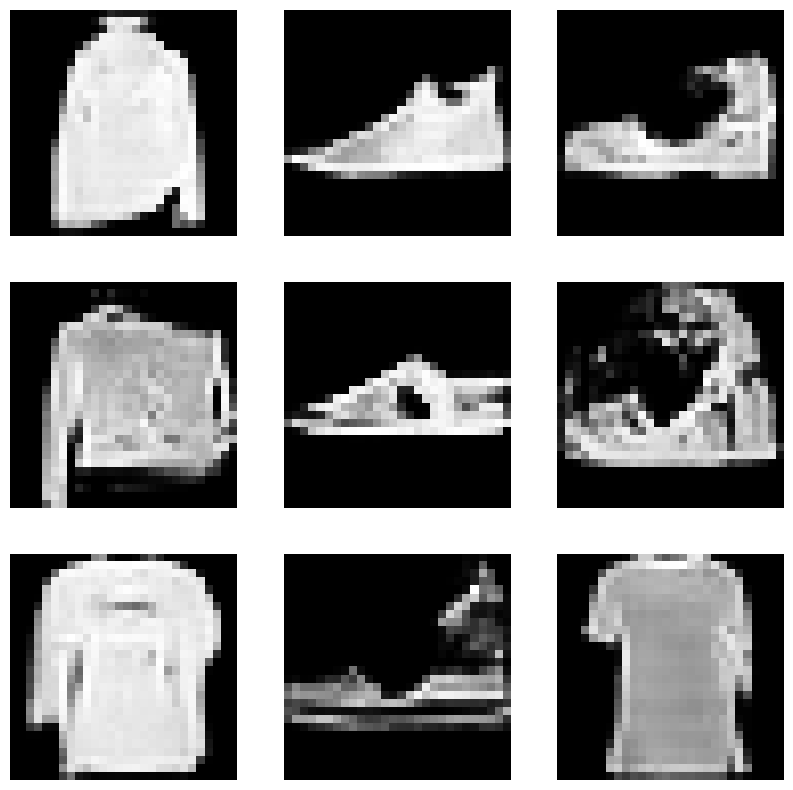

Epoch [46/100], Step [200/938], d_loss: 1.0028, g_loss: 1.0026, D(x): 0.79, D(G(z)): 0.45
Epoch [46/100], Step [400/938], d_loss: 0.8388, g_loss: 1.2564, D(x): 0.81, D(G(z)): 0.39
Epoch [46/100], Step [600/938], d_loss: 0.9632, g_loss: 1.1390, D(x): 0.57, D(G(z)): 0.23
Epoch [46/100], Step [800/938], d_loss: 0.8411, g_loss: 1.3694, D(x): 0.78, D(G(z)): 0.39


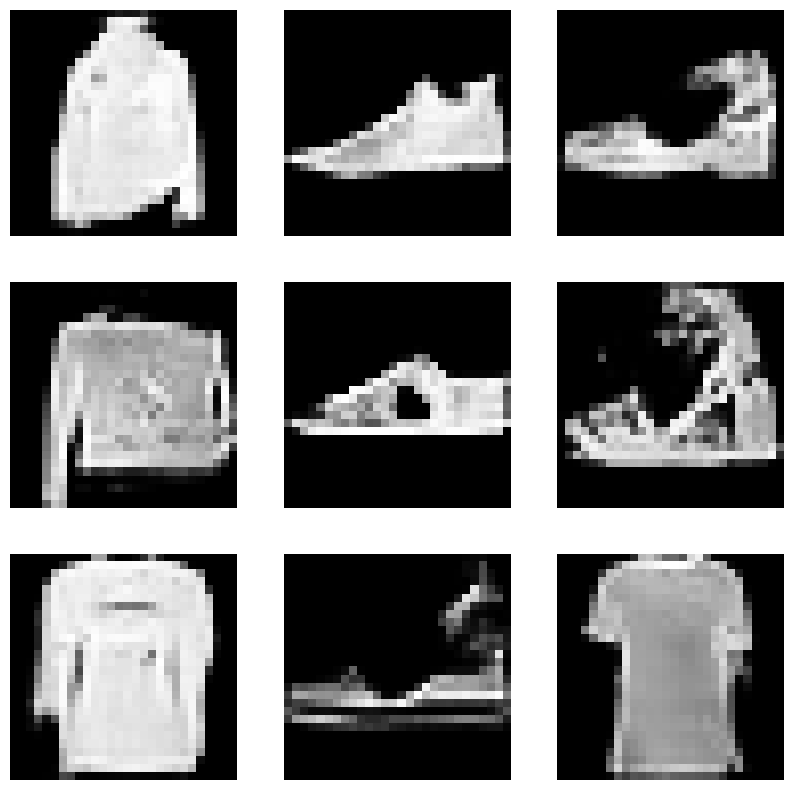

Epoch [47/100], Step [200/938], d_loss: 0.9704, g_loss: 1.3077, D(x): 0.63, D(G(z)): 0.31
Epoch [47/100], Step [400/938], d_loss: 0.7877, g_loss: 2.2262, D(x): 0.61, D(G(z)): 0.16
Epoch [47/100], Step [600/938], d_loss: 0.6080, g_loss: 1.6786, D(x): 0.74, D(G(z)): 0.21
Epoch [47/100], Step [800/938], d_loss: 0.7430, g_loss: 1.4376, D(x): 0.74, D(G(z)): 0.28


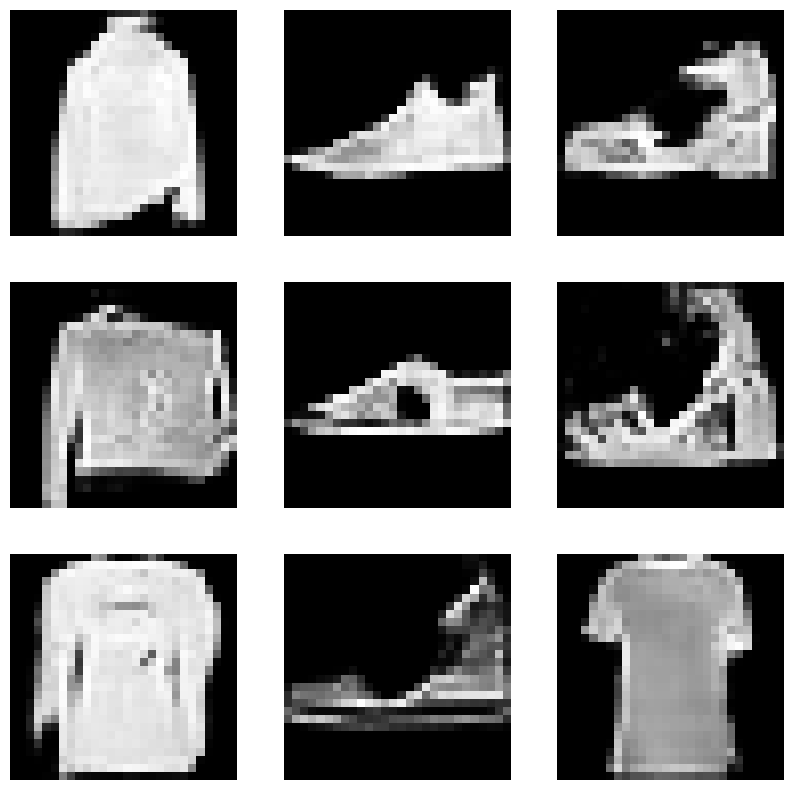

Epoch [48/100], Step [200/938], d_loss: 0.9959, g_loss: 0.7598, D(x): 0.73, D(G(z)): 0.45
Epoch [48/100], Step [400/938], d_loss: 0.7084, g_loss: 1.8406, D(x): 0.78, D(G(z)): 0.29
Epoch [48/100], Step [600/938], d_loss: 1.1239, g_loss: 1.5141, D(x): 0.60, D(G(z)): 0.36
Epoch [48/100], Step [800/938], d_loss: 0.8310, g_loss: 1.3267, D(x): 0.66, D(G(z)): 0.24


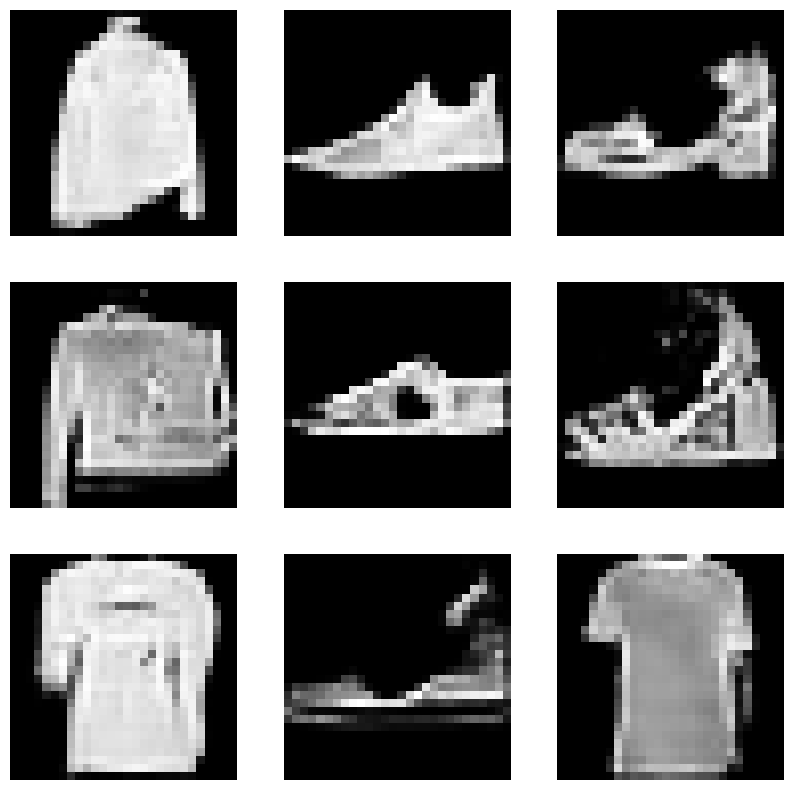

Epoch [49/100], Step [200/938], d_loss: 0.9665, g_loss: 2.0623, D(x): 0.66, D(G(z)): 0.35
Epoch [49/100], Step [400/938], d_loss: 0.8624, g_loss: 1.4792, D(x): 0.75, D(G(z)): 0.37
Epoch [49/100], Step [600/938], d_loss: 0.7880, g_loss: 1.1197, D(x): 0.69, D(G(z)): 0.26
Epoch [49/100], Step [800/938], d_loss: 0.8794, g_loss: 1.1034, D(x): 0.62, D(G(z)): 0.21


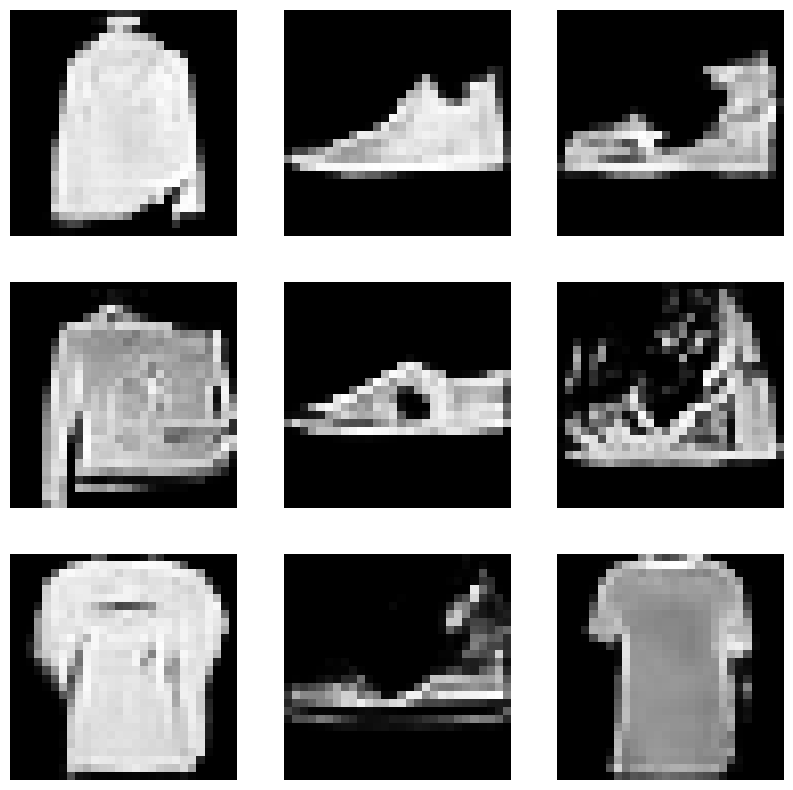

Epoch [50/100], Step [200/938], d_loss: 0.8270, g_loss: 1.4686, D(x): 0.66, D(G(z)): 0.25
Epoch [50/100], Step [400/938], d_loss: 0.8713, g_loss: 1.2473, D(x): 0.75, D(G(z)): 0.36
Epoch [50/100], Step [600/938], d_loss: 0.8412, g_loss: 1.3797, D(x): 0.76, D(G(z)): 0.36
Epoch [50/100], Step [800/938], d_loss: 1.1657, g_loss: 1.3784, D(x): 0.75, D(G(z)): 0.51


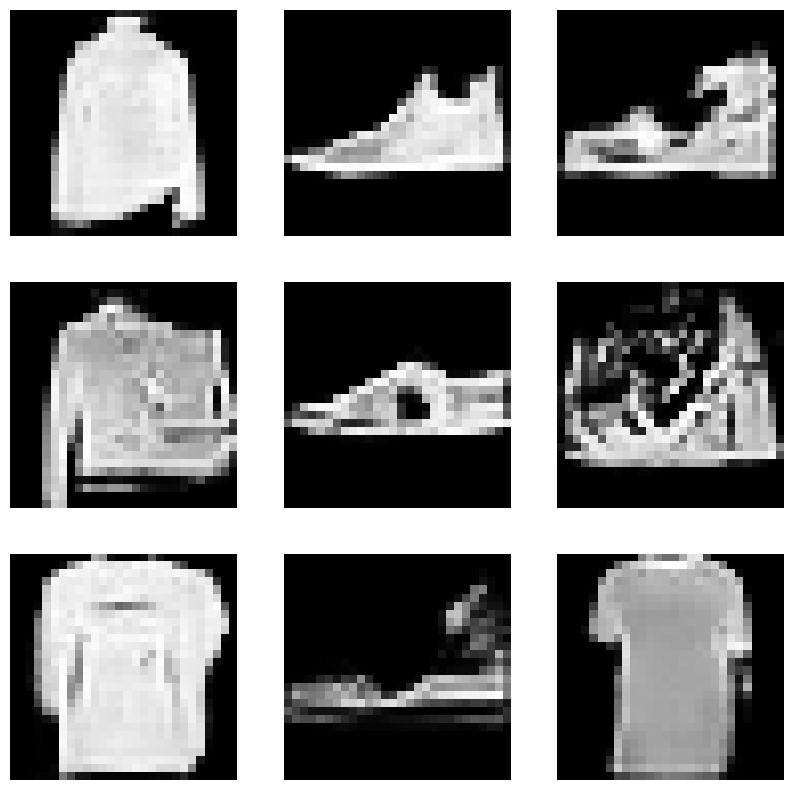

Epoch [51/100], Step [200/938], d_loss: 0.7241, g_loss: 1.7861, D(x): 0.71, D(G(z)): 0.25
Epoch [51/100], Step [400/938], d_loss: 0.8312, g_loss: 1.6877, D(x): 0.60, D(G(z)): 0.17
Epoch [51/100], Step [600/938], d_loss: 1.0590, g_loss: 1.4886, D(x): 0.73, D(G(z)): 0.46
Epoch [51/100], Step [800/938], d_loss: 0.9189, g_loss: 1.7695, D(x): 0.69, D(G(z)): 0.35


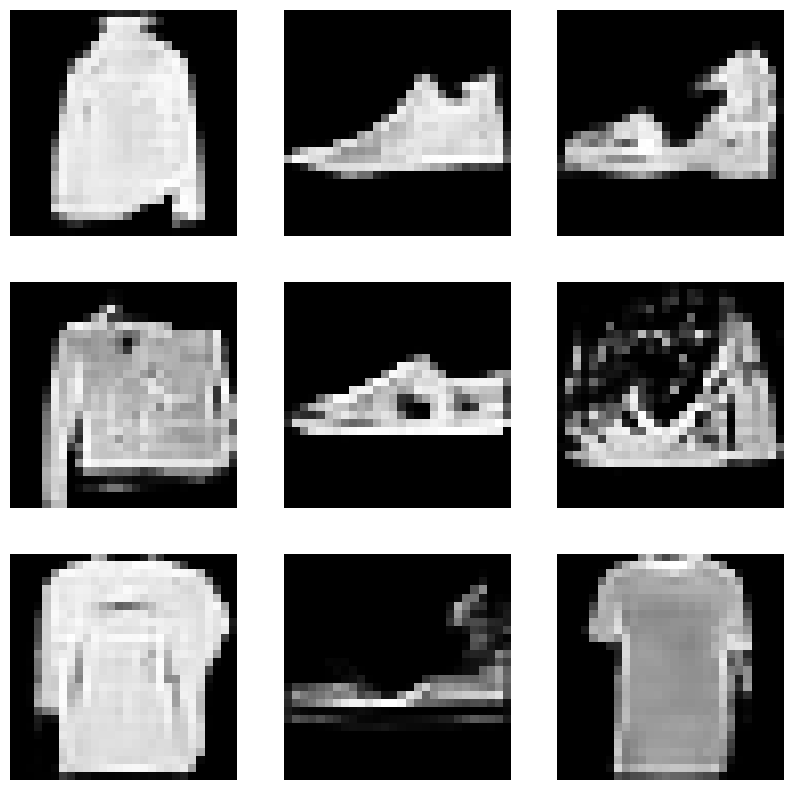

Epoch [52/100], Step [200/938], d_loss: 0.7490, g_loss: 1.5876, D(x): 0.72, D(G(z)): 0.28
Epoch [52/100], Step [400/938], d_loss: 0.7805, g_loss: 1.5671, D(x): 0.83, D(G(z)): 0.40
Epoch [52/100], Step [600/938], d_loss: 0.8921, g_loss: 1.4432, D(x): 0.74, D(G(z)): 0.37
Epoch [52/100], Step [800/938], d_loss: 1.1761, g_loss: 2.5025, D(x): 0.43, D(G(z)): 0.07


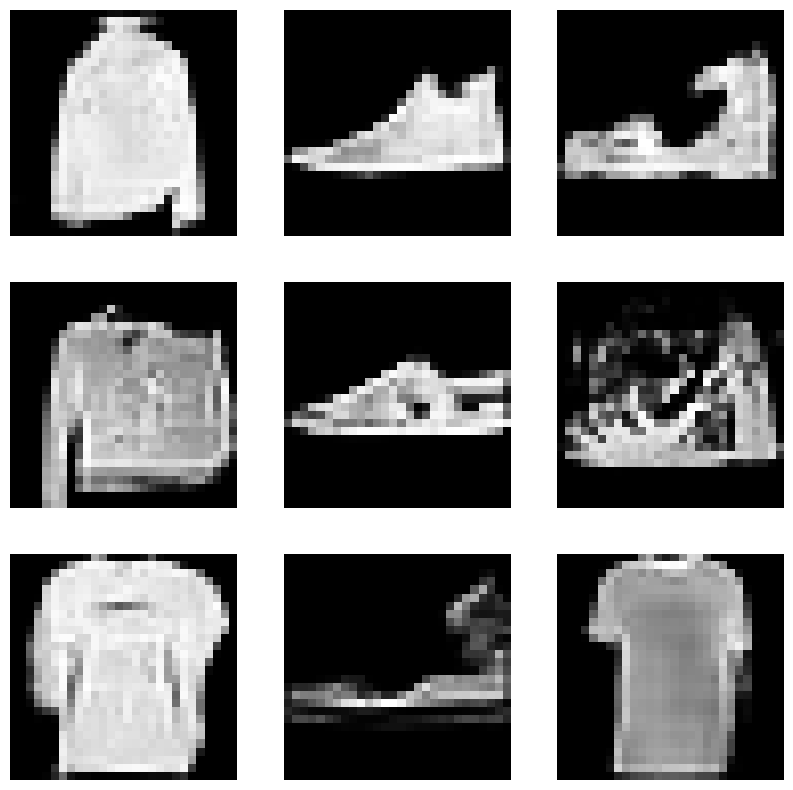

Epoch [53/100], Step [200/938], d_loss: 1.1034, g_loss: 1.2395, D(x): 0.60, D(G(z)): 0.33
Epoch [53/100], Step [400/938], d_loss: 0.9182, g_loss: 2.2966, D(x): 0.55, D(G(z)): 0.16
Epoch [53/100], Step [600/938], d_loss: 0.8968, g_loss: 2.1562, D(x): 0.61, D(G(z)): 0.22
Epoch [53/100], Step [800/938], d_loss: 0.7372, g_loss: 1.5883, D(x): 0.80, D(G(z)): 0.35


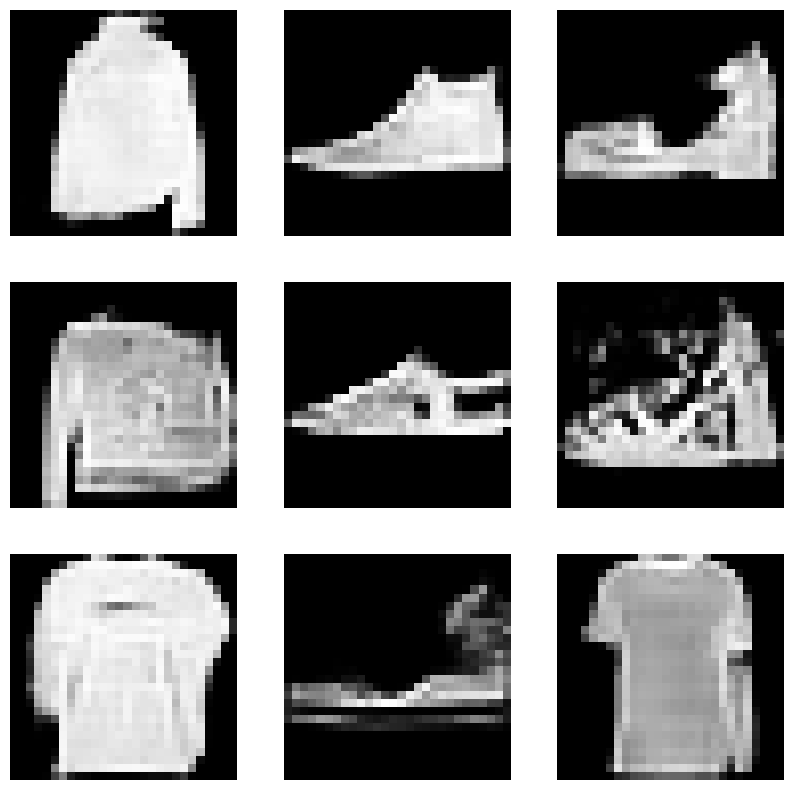

Epoch [54/100], Step [200/938], d_loss: 0.9292, g_loss: 1.3369, D(x): 0.64, D(G(z)): 0.26
Epoch [54/100], Step [400/938], d_loss: 0.9326, g_loss: 1.5330, D(x): 0.68, D(G(z)): 0.33
Epoch [54/100], Step [600/938], d_loss: 0.7732, g_loss: 1.9380, D(x): 0.63, D(G(z)): 0.16
Epoch [54/100], Step [800/938], d_loss: 0.9673, g_loss: 1.0438, D(x): 0.62, D(G(z)): 0.31


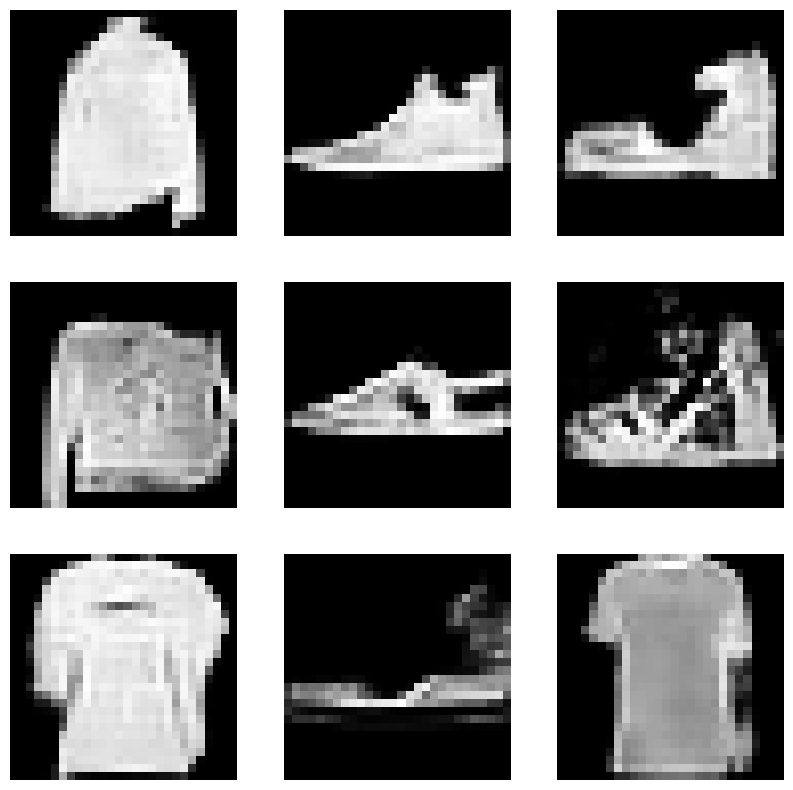

Epoch [55/100], Step [200/938], d_loss: 0.6993, g_loss: 1.2575, D(x): 0.65, D(G(z)): 0.14
Epoch [55/100], Step [400/938], d_loss: 0.9948, g_loss: 1.5914, D(x): 0.57, D(G(z)): 0.18
Epoch [55/100], Step [600/938], d_loss: 0.9874, g_loss: 1.1273, D(x): 0.74, D(G(z)): 0.41
Epoch [55/100], Step [800/938], d_loss: 1.0087, g_loss: 1.4965, D(x): 0.59, D(G(z)): 0.28


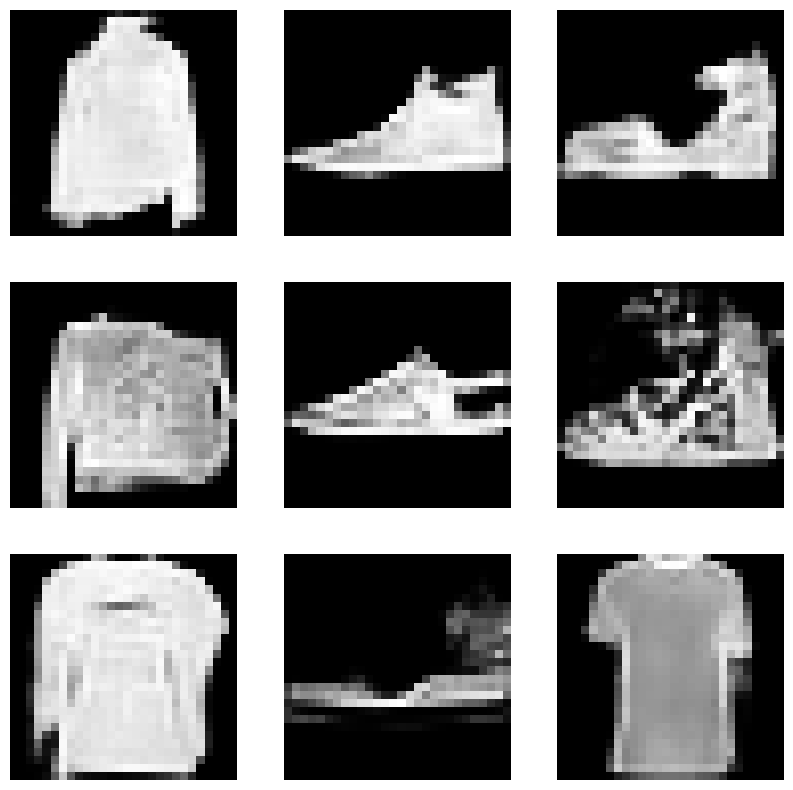

Epoch [56/100], Step [200/938], d_loss: 0.8123, g_loss: 1.5575, D(x): 0.83, D(G(z)): 0.40
Epoch [56/100], Step [400/938], d_loss: 0.8845, g_loss: 1.7241, D(x): 0.67, D(G(z)): 0.29
Epoch [56/100], Step [600/938], d_loss: 0.8582, g_loss: 1.4283, D(x): 0.66, D(G(z)): 0.27
Epoch [56/100], Step [800/938], d_loss: 0.9186, g_loss: 1.7851, D(x): 0.67, D(G(z)): 0.31


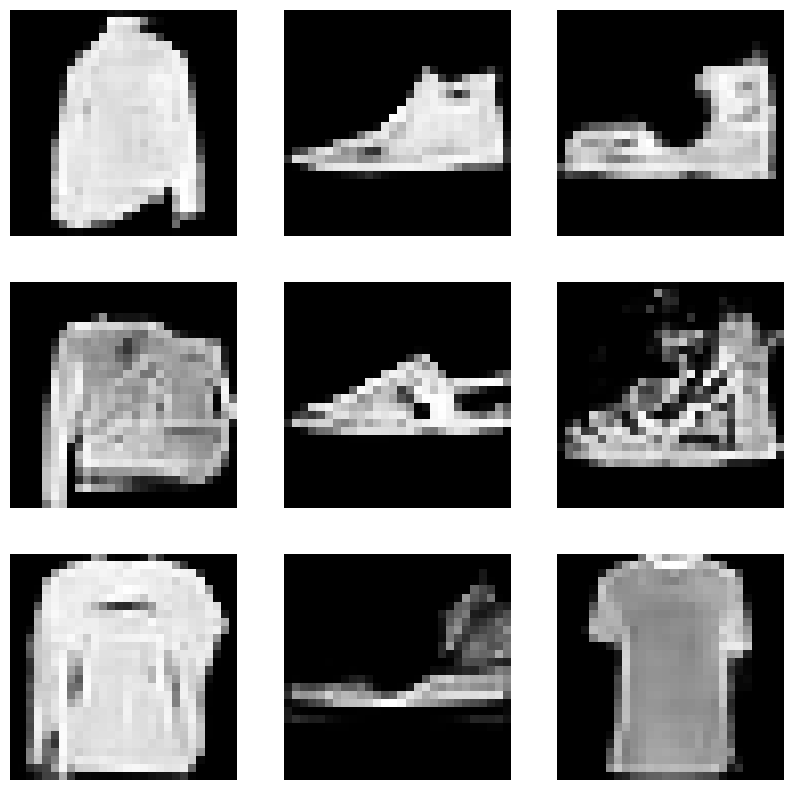

Epoch [57/100], Step [200/938], d_loss: 0.8872, g_loss: 1.8718, D(x): 0.73, D(G(z)): 0.38
Epoch [57/100], Step [400/938], d_loss: 0.9621, g_loss: 1.6871, D(x): 0.62, D(G(z)): 0.29
Epoch [57/100], Step [600/938], d_loss: 0.8156, g_loss: 1.4435, D(x): 0.69, D(G(z)): 0.27
Epoch [57/100], Step [800/938], d_loss: 0.9798, g_loss: 1.8205, D(x): 0.57, D(G(z)): 0.22


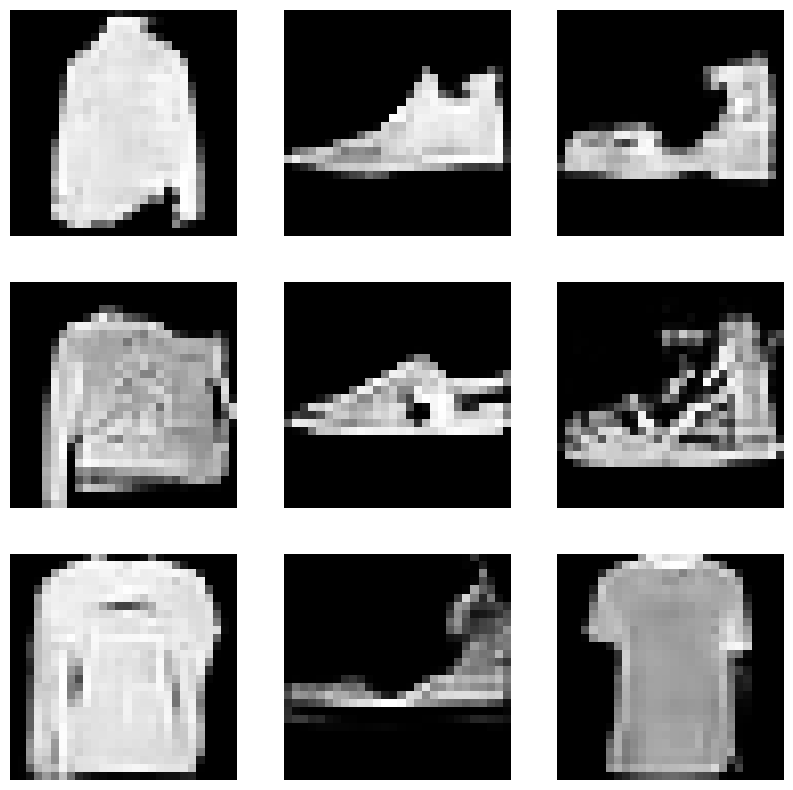

Epoch [58/100], Step [200/938], d_loss: 0.6744, g_loss: 2.2878, D(x): 0.66, D(G(z)): 0.13
Epoch [58/100], Step [400/938], d_loss: 0.8539, g_loss: 1.6875, D(x): 0.79, D(G(z)): 0.39
Epoch [58/100], Step [600/938], d_loss: 0.7316, g_loss: 1.4645, D(x): 0.80, D(G(z)): 0.31
Epoch [58/100], Step [800/938], d_loss: 0.9591, g_loss: 1.3915, D(x): 0.74, D(G(z)): 0.39


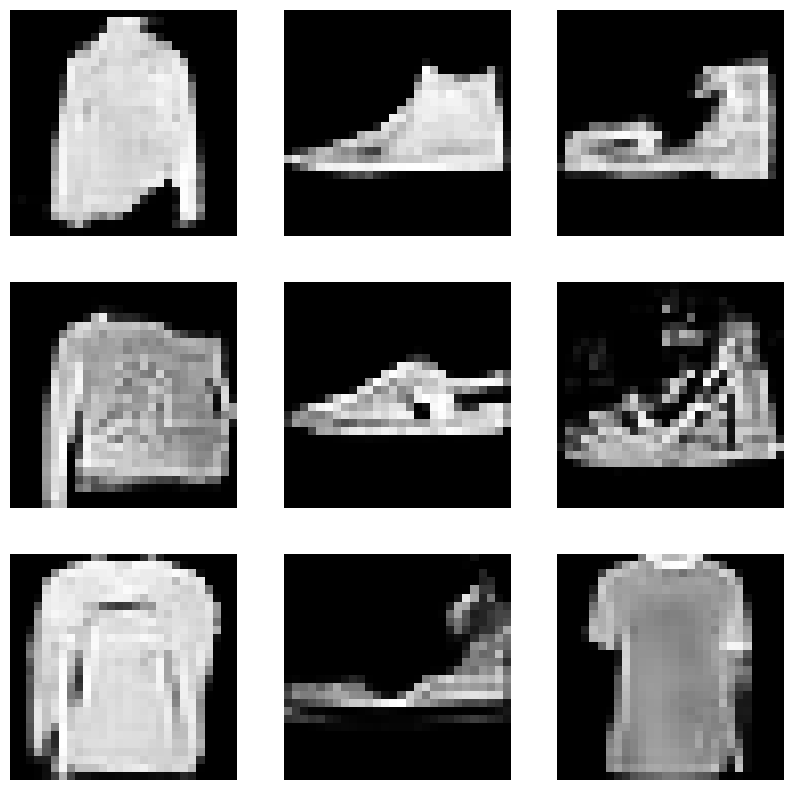

Epoch [59/100], Step [200/938], d_loss: 1.2499, g_loss: 1.0510, D(x): 0.64, D(G(z)): 0.43
Epoch [59/100], Step [400/938], d_loss: 0.7786, g_loss: 1.1858, D(x): 0.93, D(G(z)): 0.43
Epoch [59/100], Step [600/938], d_loss: 1.0387, g_loss: 2.0631, D(x): 0.55, D(G(z)): 0.22
Epoch [59/100], Step [800/938], d_loss: 1.0209, g_loss: 1.4723, D(x): 0.59, D(G(z)): 0.28


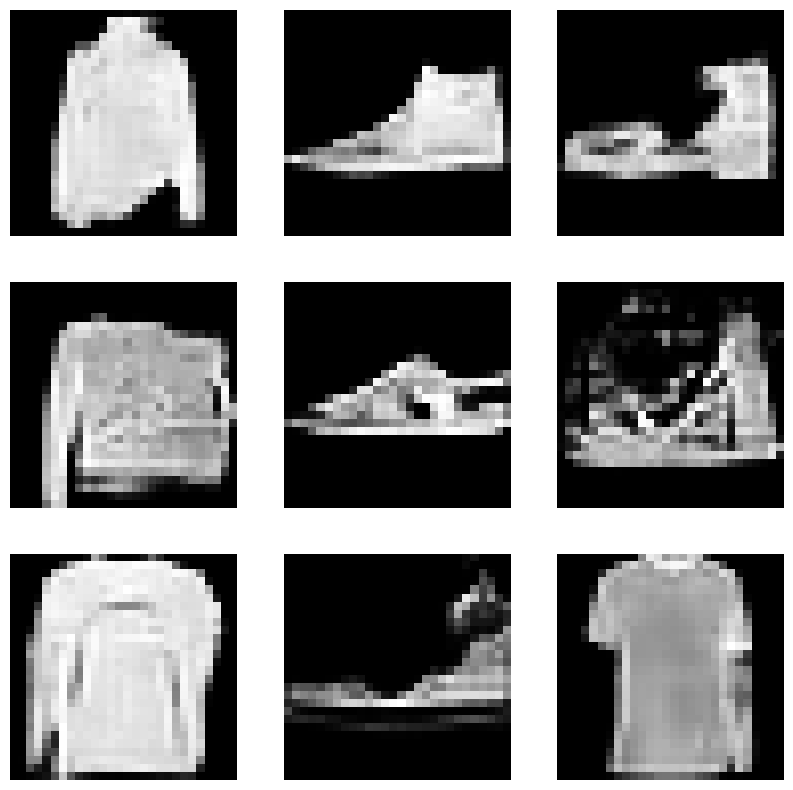

Epoch [60/100], Step [200/938], d_loss: 0.8211, g_loss: 2.4061, D(x): 0.69, D(G(z)): 0.30
Epoch [60/100], Step [400/938], d_loss: 0.7008, g_loss: 1.4846, D(x): 0.73, D(G(z)): 0.25
Epoch [60/100], Step [600/938], d_loss: 0.5932, g_loss: 1.6652, D(x): 0.74, D(G(z)): 0.21
Epoch [60/100], Step [800/938], d_loss: 1.0499, g_loss: 0.8466, D(x): 0.59, D(G(z)): 0.30


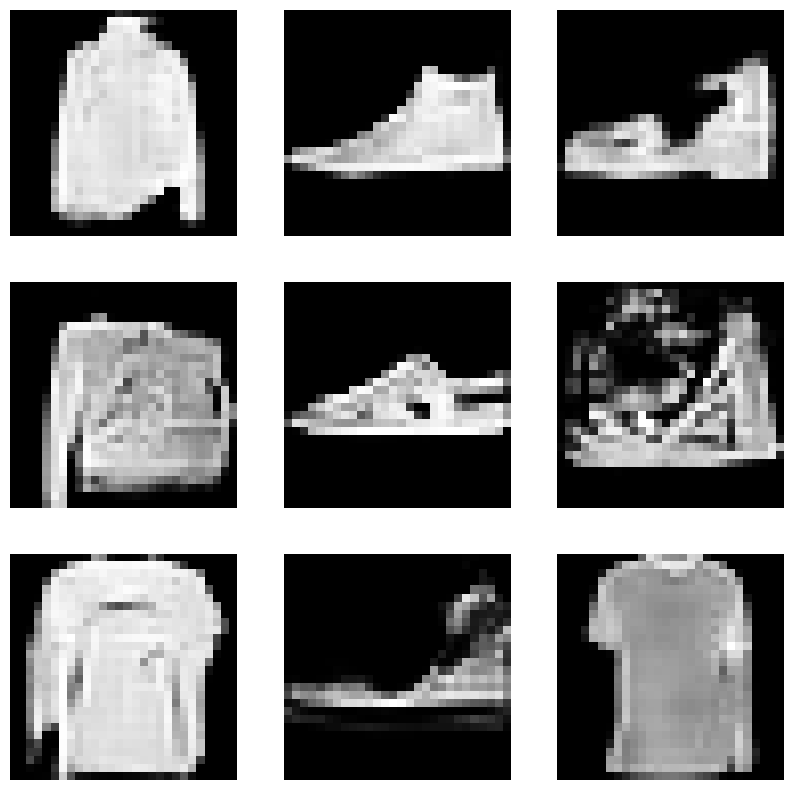

Epoch [61/100], Step [200/938], d_loss: 1.1842, g_loss: 1.1933, D(x): 0.68, D(G(z)): 0.42
Epoch [61/100], Step [400/938], d_loss: 0.6811, g_loss: 1.2318, D(x): 0.84, D(G(z)): 0.34
Epoch [61/100], Step [600/938], d_loss: 0.9730, g_loss: 1.8720, D(x): 0.62, D(G(z)): 0.27
Epoch [61/100], Step [800/938], d_loss: 0.7917, g_loss: 1.5350, D(x): 0.69, D(G(z)): 0.24


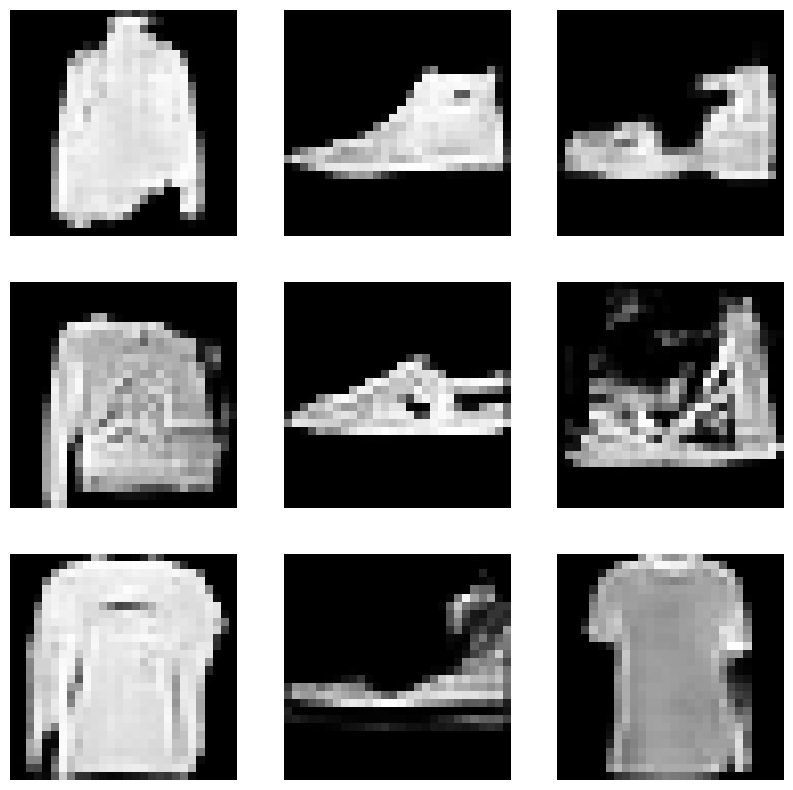

Epoch [62/100], Step [200/938], d_loss: 0.6173, g_loss: 2.3283, D(x): 0.80, D(G(z)): 0.27
Epoch [62/100], Step [400/938], d_loss: 0.7358, g_loss: 1.2213, D(x): 0.81, D(G(z)): 0.34
Epoch [62/100], Step [600/938], d_loss: 0.6187, g_loss: 1.2414, D(x): 0.79, D(G(z)): 0.26
Epoch [62/100], Step [800/938], d_loss: 0.5912, g_loss: 1.6016, D(x): 0.74, D(G(z)): 0.19


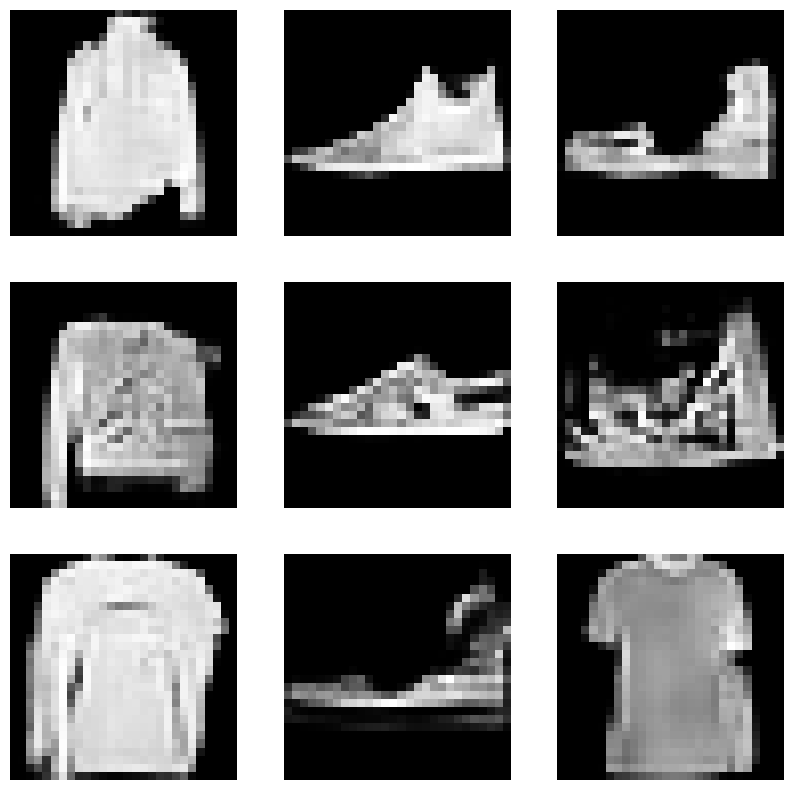

Epoch [63/100], Step [200/938], d_loss: 0.6919, g_loss: 1.9964, D(x): 0.74, D(G(z)): 0.26
Epoch [63/100], Step [400/938], d_loss: 0.8075, g_loss: 1.6395, D(x): 0.87, D(G(z)): 0.40
Epoch [63/100], Step [600/938], d_loss: 0.8717, g_loss: 1.4968, D(x): 0.68, D(G(z)): 0.31
Epoch [63/100], Step [800/938], d_loss: 0.6745, g_loss: 3.0117, D(x): 0.81, D(G(z)): 0.32


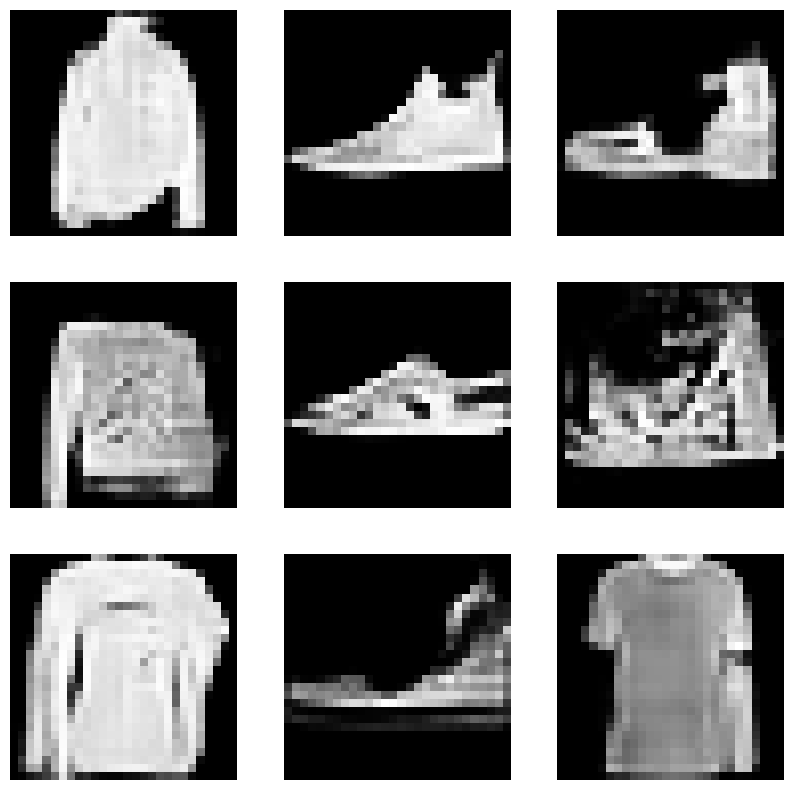

Epoch [64/100], Step [200/938], d_loss: 0.8469, g_loss: 1.7861, D(x): 0.72, D(G(z)): 0.33
Epoch [64/100], Step [400/938], d_loss: 0.6564, g_loss: 1.7661, D(x): 0.74, D(G(z)): 0.23
Epoch [64/100], Step [600/938], d_loss: 0.6890, g_loss: 1.7433, D(x): 0.75, D(G(z)): 0.26
Epoch [64/100], Step [800/938], d_loss: 0.6986, g_loss: 2.3057, D(x): 0.70, D(G(z)): 0.20


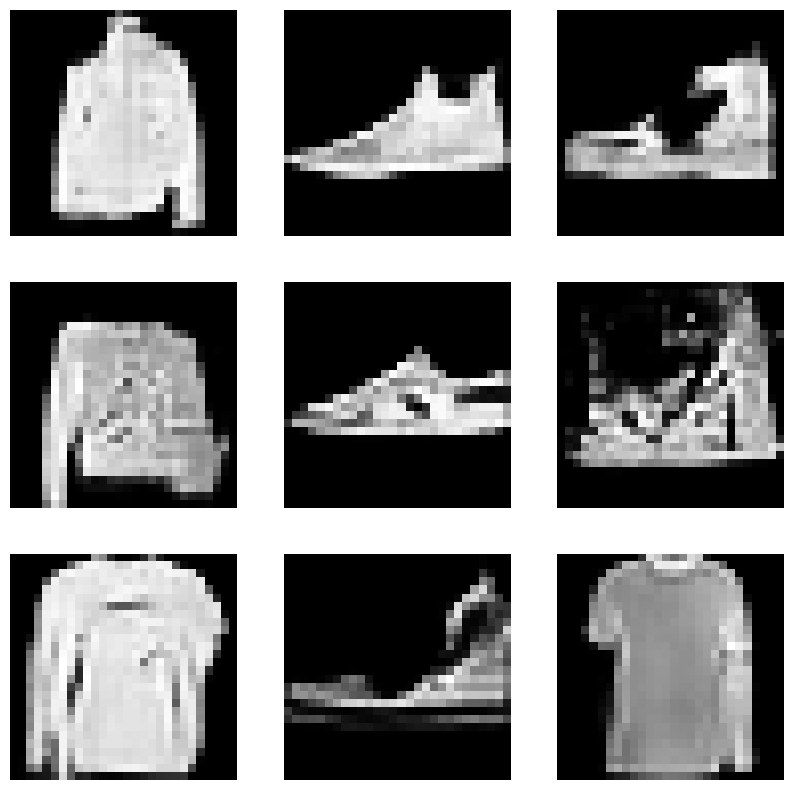

Epoch [65/100], Step [200/938], d_loss: 0.8661, g_loss: 1.7377, D(x): 0.69, D(G(z)): 0.29
Epoch [65/100], Step [400/938], d_loss: 0.7127, g_loss: 2.4780, D(x): 0.66, D(G(z)): 0.16
Epoch [65/100], Step [600/938], d_loss: 0.5181, g_loss: 1.9633, D(x): 0.74, D(G(z)): 0.14
Epoch [65/100], Step [800/938], d_loss: 1.1622, g_loss: 1.4441, D(x): 0.79, D(G(z)): 0.51


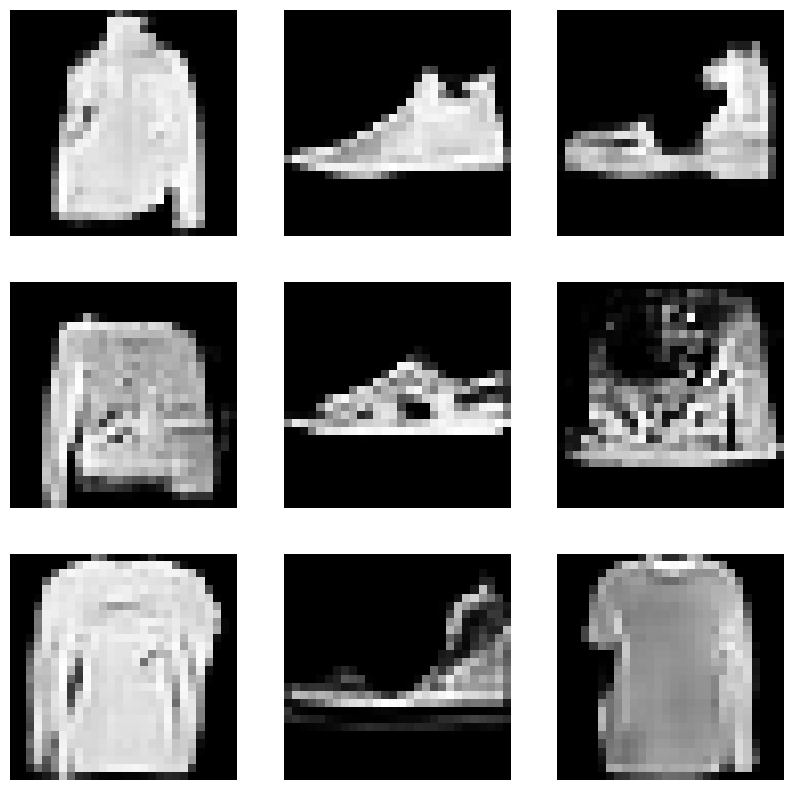

Epoch [66/100], Step [200/938], d_loss: 0.6442, g_loss: 1.7888, D(x): 0.78, D(G(z)): 0.25
Epoch [66/100], Step [400/938], d_loss: 0.8328, g_loss: 1.9702, D(x): 0.73, D(G(z)): 0.33
Epoch [66/100], Step [600/938], d_loss: 0.7261, g_loss: 1.9369, D(x): 0.83, D(G(z)): 0.35
Epoch [66/100], Step [800/938], d_loss: 0.8213, g_loss: 1.1063, D(x): 0.76, D(G(z)): 0.34


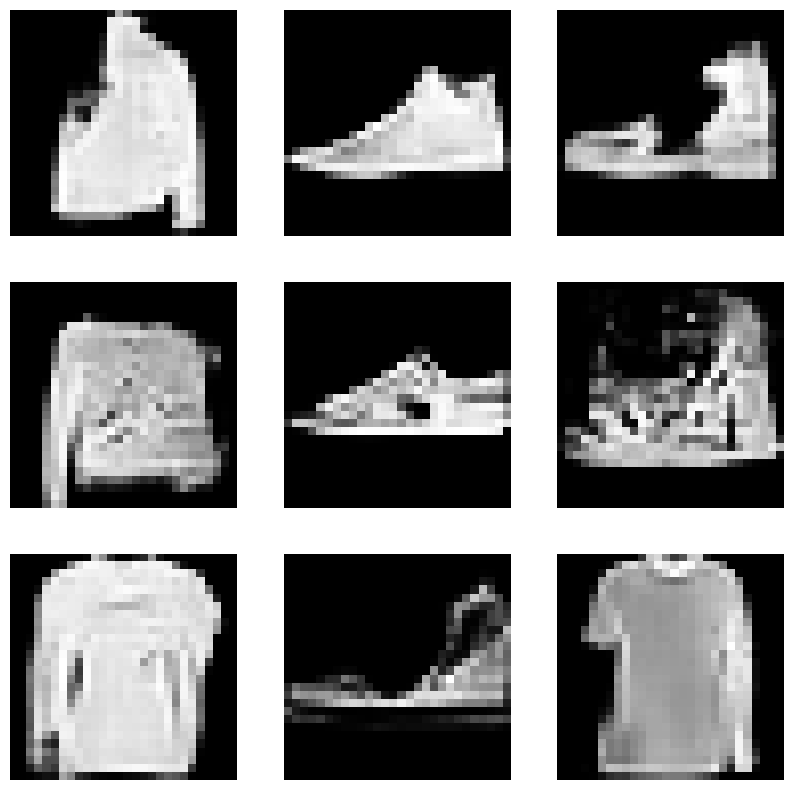

Epoch [67/100], Step [200/938], d_loss: 0.5060, g_loss: 2.1792, D(x): 0.81, D(G(z)): 0.21
Epoch [67/100], Step [400/938], d_loss: 0.8532, g_loss: 1.3064, D(x): 0.83, D(G(z)): 0.40
Epoch [67/100], Step [600/938], d_loss: 0.8323, g_loss: 1.9279, D(x): 0.57, D(G(z)): 0.13
Epoch [67/100], Step [800/938], d_loss: 0.7006, g_loss: 2.3302, D(x): 0.76, D(G(z)): 0.27


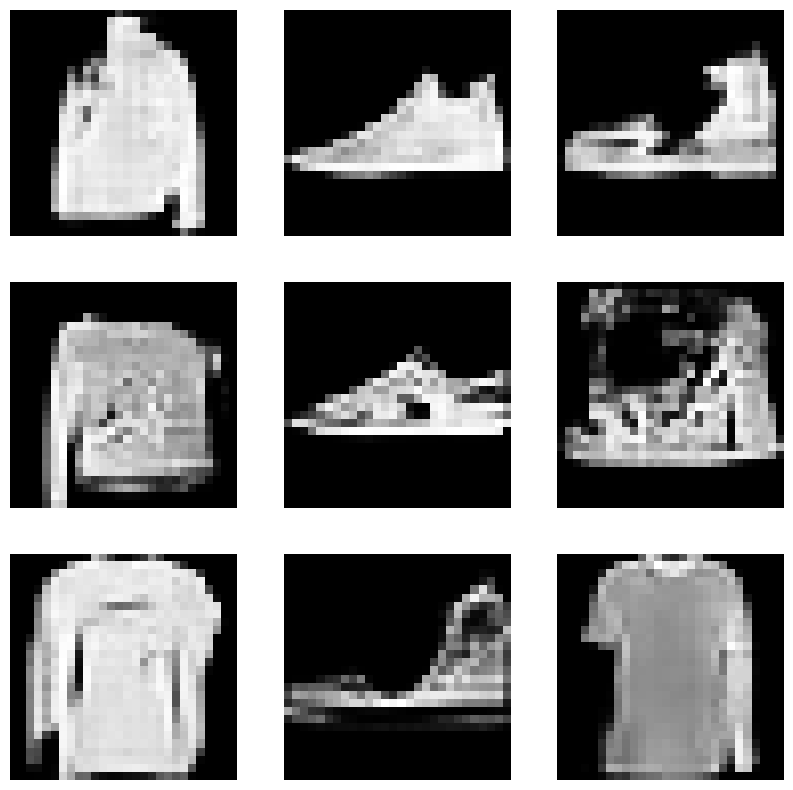

Epoch [68/100], Step [200/938], d_loss: 0.7690, g_loss: 1.8365, D(x): 0.78, D(G(z)): 0.35
Epoch [68/100], Step [400/938], d_loss: 0.7954, g_loss: 1.4131, D(x): 0.58, D(G(z)): 0.14
Epoch [68/100], Step [600/938], d_loss: 0.8396, g_loss: 1.4681, D(x): 0.75, D(G(z)): 0.34
Epoch [68/100], Step [800/938], d_loss: 0.8919, g_loss: 1.8604, D(x): 0.62, D(G(z)): 0.25


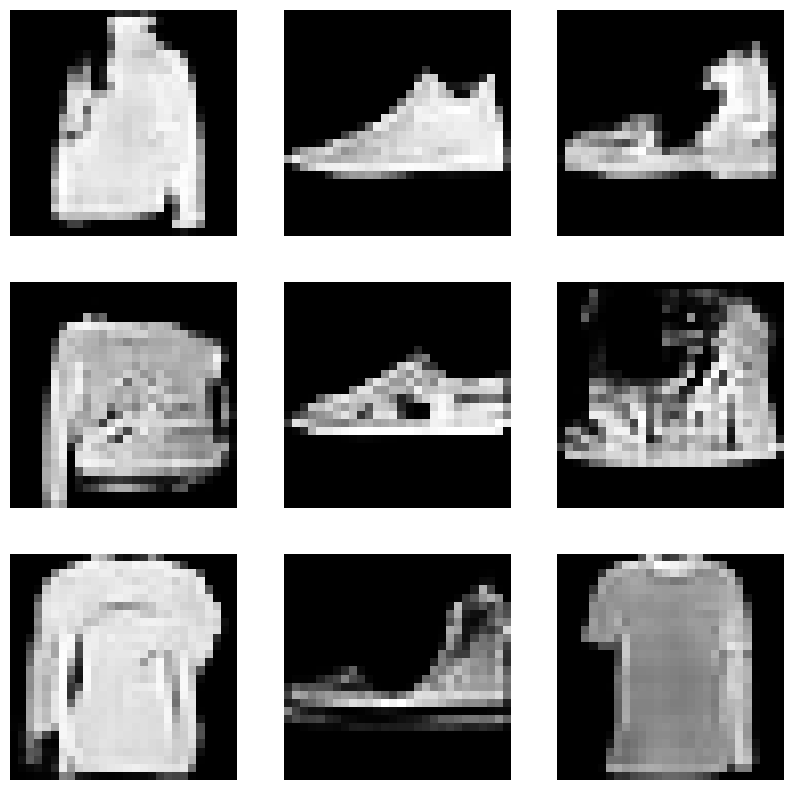

Epoch [69/100], Step [200/938], d_loss: 1.1437, g_loss: 1.7732, D(x): 0.48, D(G(z)): 0.16
Epoch [69/100], Step [400/938], d_loss: 1.1104, g_loss: 2.5875, D(x): 0.59, D(G(z)): 0.32
Epoch [69/100], Step [600/938], d_loss: 0.7600, g_loss: 2.6531, D(x): 0.74, D(G(z)): 0.28
Epoch [69/100], Step [800/938], d_loss: 0.7716, g_loss: 1.4034, D(x): 0.80, D(G(z)): 0.36


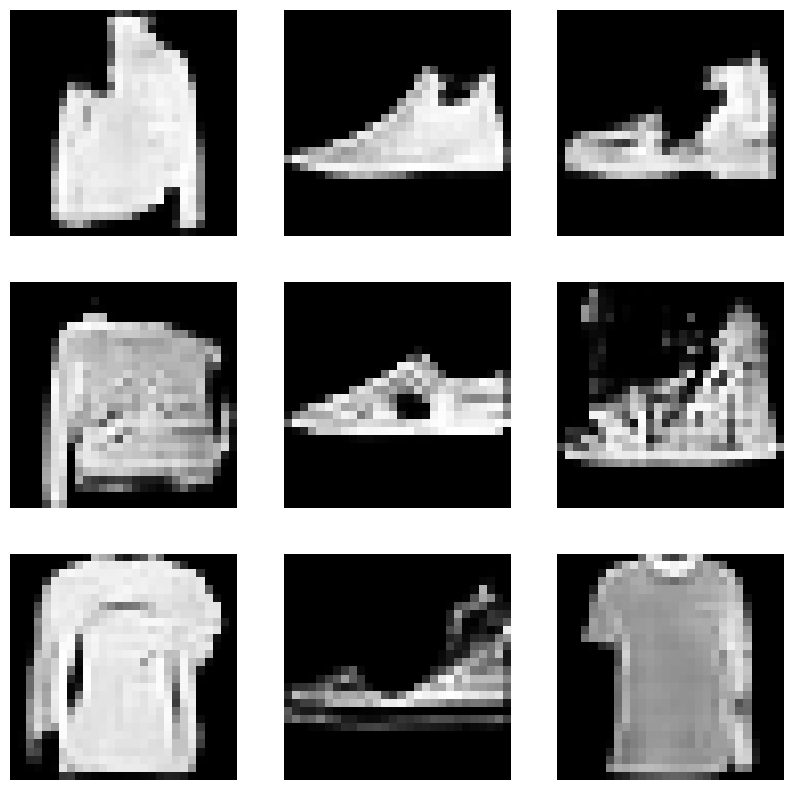

Epoch [70/100], Step [200/938], d_loss: 0.8410, g_loss: 1.7639, D(x): 0.71, D(G(z)): 0.30
Epoch [70/100], Step [400/938], d_loss: 0.7058, g_loss: 2.1858, D(x): 0.76, D(G(z)): 0.24
Epoch [70/100], Step [600/938], d_loss: 0.8055, g_loss: 2.4639, D(x): 0.70, D(G(z)): 0.28
Epoch [70/100], Step [800/938], d_loss: 0.6715, g_loss: 1.9251, D(x): 0.74, D(G(z)): 0.24


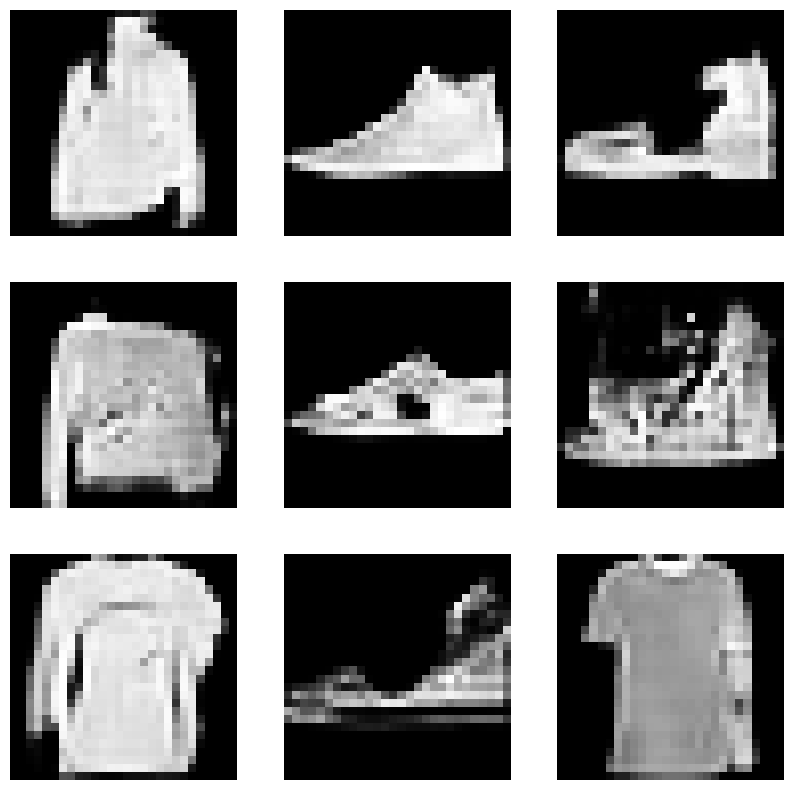

Epoch [71/100], Step [200/938], d_loss: 0.7535, g_loss: 1.8046, D(x): 0.66, D(G(z)): 0.19
Epoch [71/100], Step [400/938], d_loss: 0.9537, g_loss: 1.6135, D(x): 0.76, D(G(z)): 0.40
Epoch [71/100], Step [600/938], d_loss: 0.7746, g_loss: 1.0612, D(x): 0.76, D(G(z)): 0.31
Epoch [71/100], Step [800/938], d_loss: 0.7065, g_loss: 1.6586, D(x): 0.68, D(G(z)): 0.18


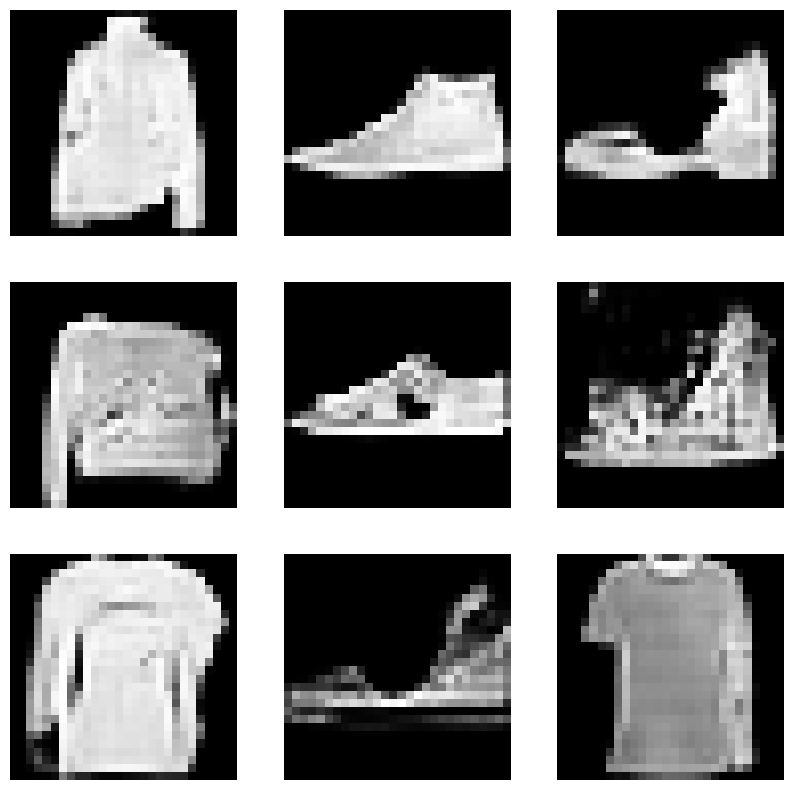

Epoch [72/100], Step [200/938], d_loss: 0.7163, g_loss: 1.6847, D(x): 0.69, D(G(z)): 0.17
Epoch [72/100], Step [400/938], d_loss: 1.0194, g_loss: 1.7956, D(x): 0.81, D(G(z)): 0.47
Epoch [72/100], Step [600/938], d_loss: 0.7063, g_loss: 2.6276, D(x): 0.66, D(G(z)): 0.16
Epoch [72/100], Step [800/938], d_loss: 0.6732, g_loss: 2.2173, D(x): 0.62, D(G(z)): 0.10


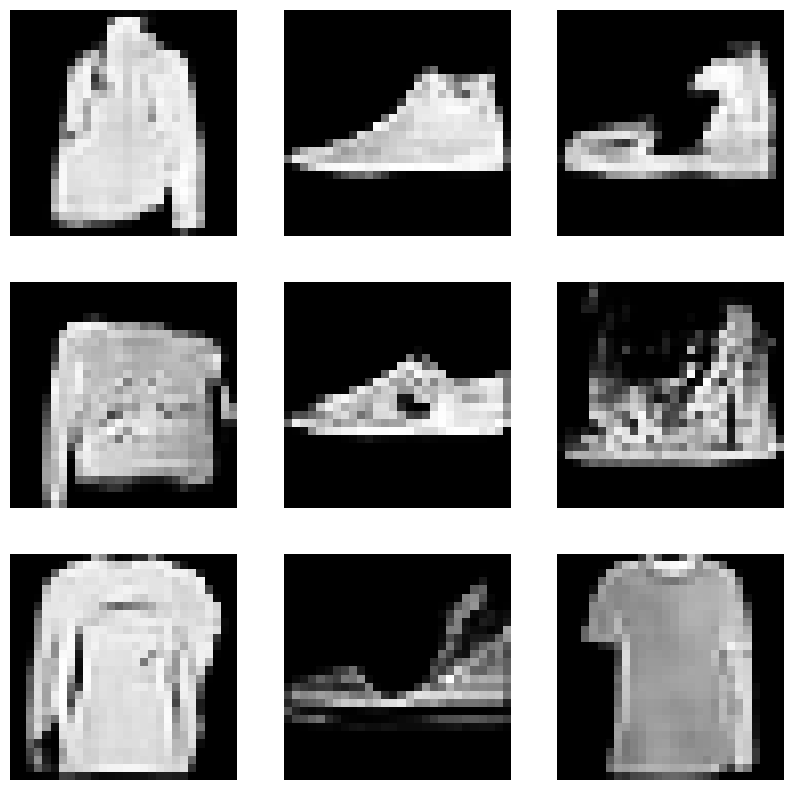

Epoch [73/100], Step [200/938], d_loss: 0.6994, g_loss: 2.2842, D(x): 0.68, D(G(z)): 0.20
Epoch [73/100], Step [400/938], d_loss: 0.9186, g_loss: 1.3238, D(x): 0.73, D(G(z)): 0.35
Epoch [73/100], Step [600/938], d_loss: 0.8629, g_loss: 1.6249, D(x): 0.71, D(G(z)): 0.31
Epoch [73/100], Step [800/938], d_loss: 0.6363, g_loss: 1.4274, D(x): 0.85, D(G(z)): 0.28


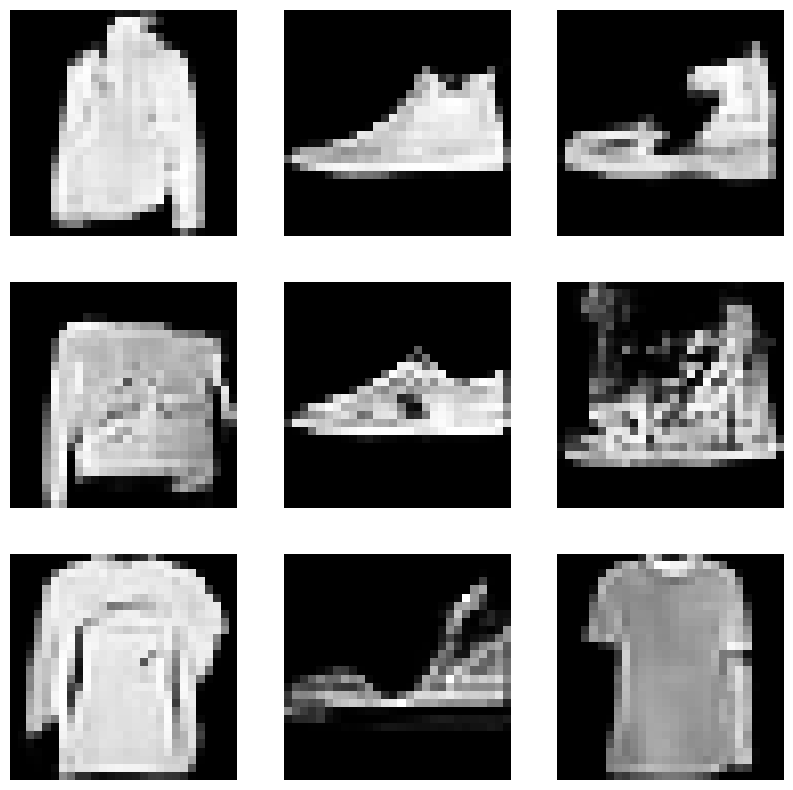

Epoch [74/100], Step [200/938], d_loss: 0.6379, g_loss: 2.4383, D(x): 0.71, D(G(z)): 0.16
Epoch [74/100], Step [400/938], d_loss: 0.7407, g_loss: 1.7611, D(x): 0.68, D(G(z)): 0.23
Epoch [74/100], Step [600/938], d_loss: 0.7850, g_loss: 2.3242, D(x): 0.60, D(G(z)): 0.14
Epoch [74/100], Step [800/938], d_loss: 1.0896, g_loss: 2.3177, D(x): 0.50, D(G(z)): 0.19


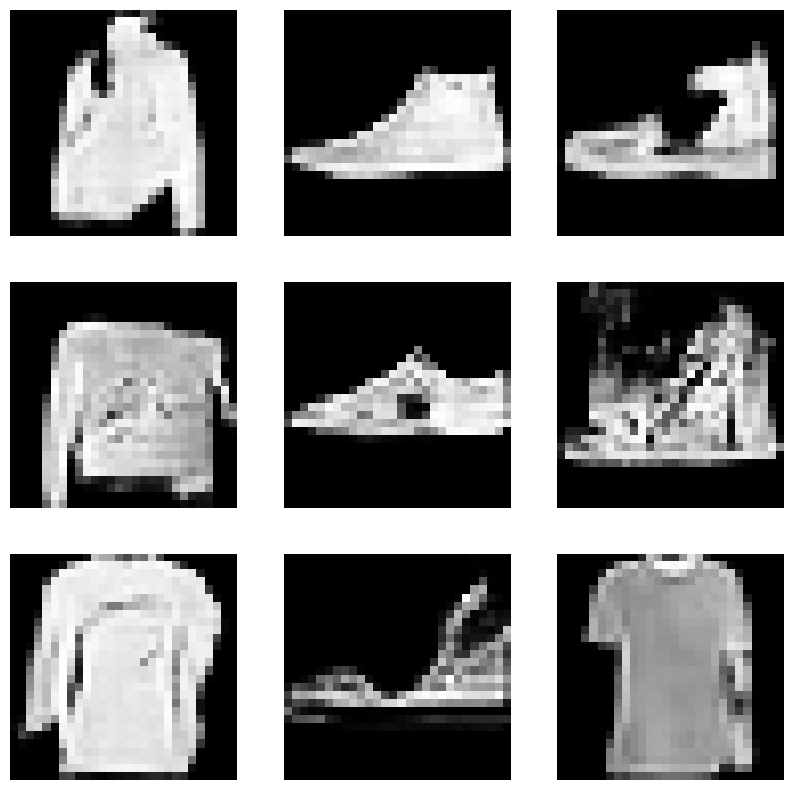

Epoch [75/100], Step [200/938], d_loss: 0.9153, g_loss: 2.0912, D(x): 0.65, D(G(z)): 0.28
Epoch [75/100], Step [400/938], d_loss: 0.8205, g_loss: 1.6811, D(x): 0.75, D(G(z)): 0.33
Epoch [75/100], Step [600/938], d_loss: 0.7603, g_loss: 1.6677, D(x): 0.80, D(G(z)): 0.33
Epoch [75/100], Step [800/938], d_loss: 0.9690, g_loss: 1.8955, D(x): 0.85, D(G(z)): 0.44


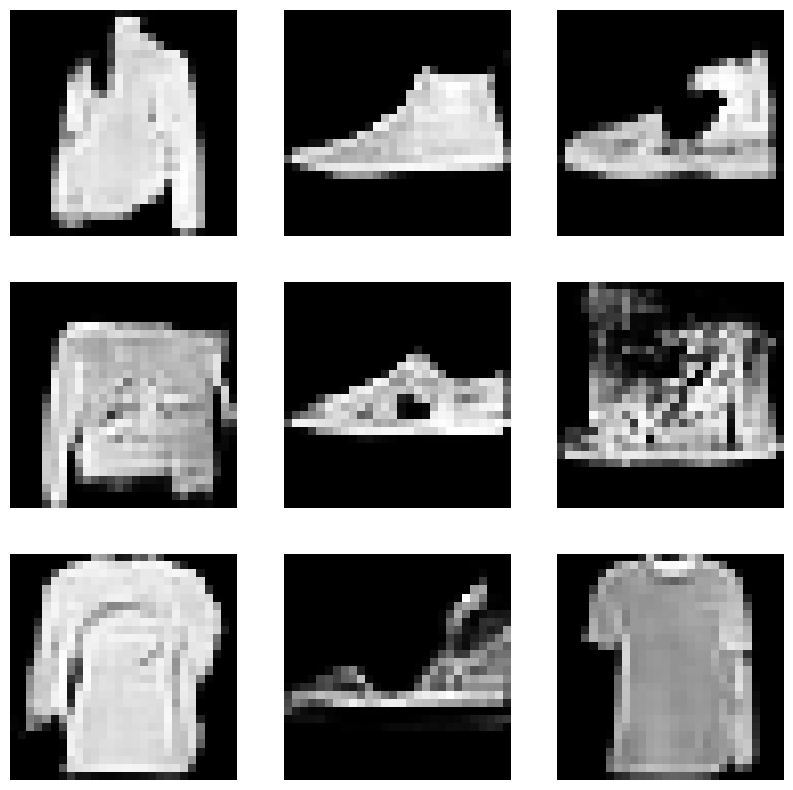

Epoch [76/100], Step [200/938], d_loss: 0.5854, g_loss: 1.0927, D(x): 0.86, D(G(z)): 0.28
Epoch [76/100], Step [400/938], d_loss: 0.8856, g_loss: 1.5924, D(x): 0.73, D(G(z)): 0.34
Epoch [76/100], Step [600/938], d_loss: 0.7572, g_loss: 1.4689, D(x): 0.72, D(G(z)): 0.28
Epoch [76/100], Step [800/938], d_loss: 0.4748, g_loss: 1.4586, D(x): 0.85, D(G(z)): 0.24


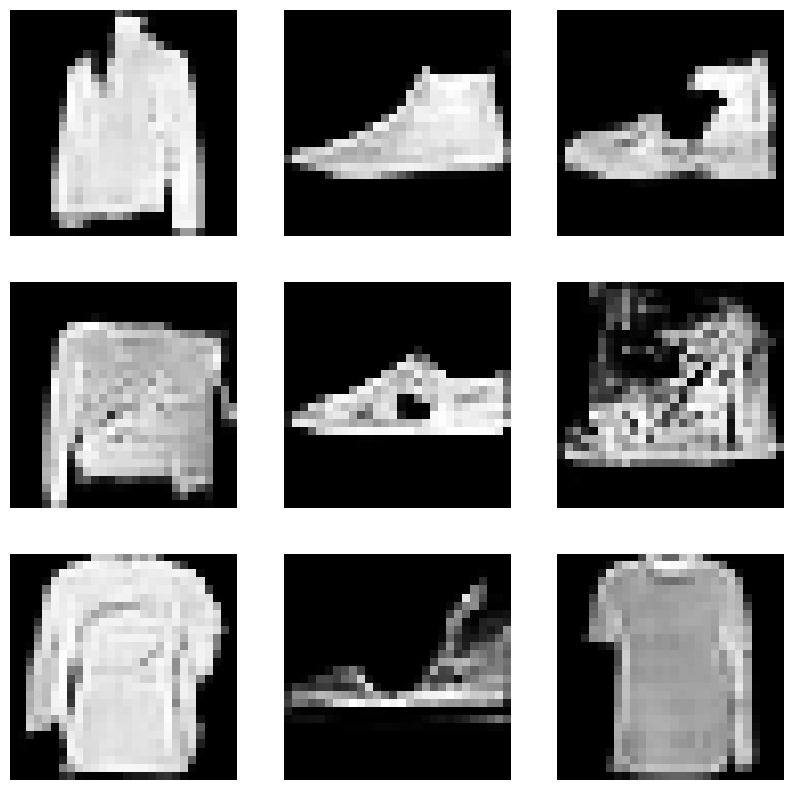

Epoch [77/100], Step [200/938], d_loss: 0.9257, g_loss: 1.8037, D(x): 0.88, D(G(z)): 0.46
Epoch [77/100], Step [400/938], d_loss: 0.5103, g_loss: 2.0708, D(x): 0.82, D(G(z)): 0.18
Epoch [77/100], Step [600/938], d_loss: 0.8161, g_loss: 1.5828, D(x): 0.73, D(G(z)): 0.29
Epoch [77/100], Step [800/938], d_loss: 0.7602, g_loss: 2.6080, D(x): 0.63, D(G(z)): 0.16


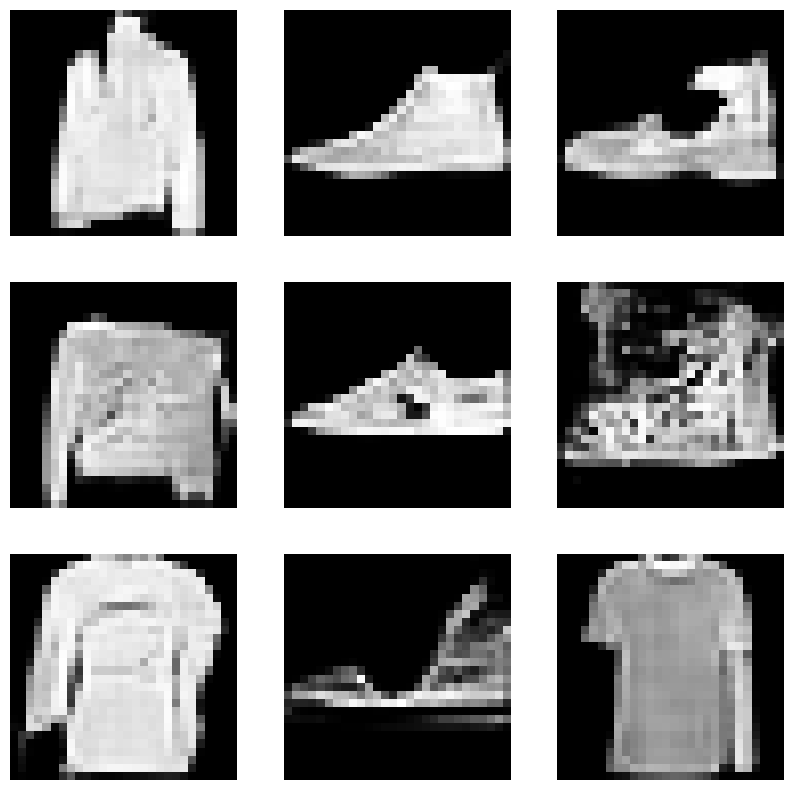

Epoch [78/100], Step [200/938], d_loss: 0.8447, g_loss: 1.7453, D(x): 0.72, D(G(z)): 0.28
Epoch [78/100], Step [400/938], d_loss: 0.6842, g_loss: 1.3515, D(x): 0.85, D(G(z)): 0.34
Epoch [78/100], Step [600/938], d_loss: 0.7339, g_loss: 2.0082, D(x): 0.65, D(G(z)): 0.17
Epoch [78/100], Step [800/938], d_loss: 0.6775, g_loss: 1.0551, D(x): 0.83, D(G(z)): 0.30


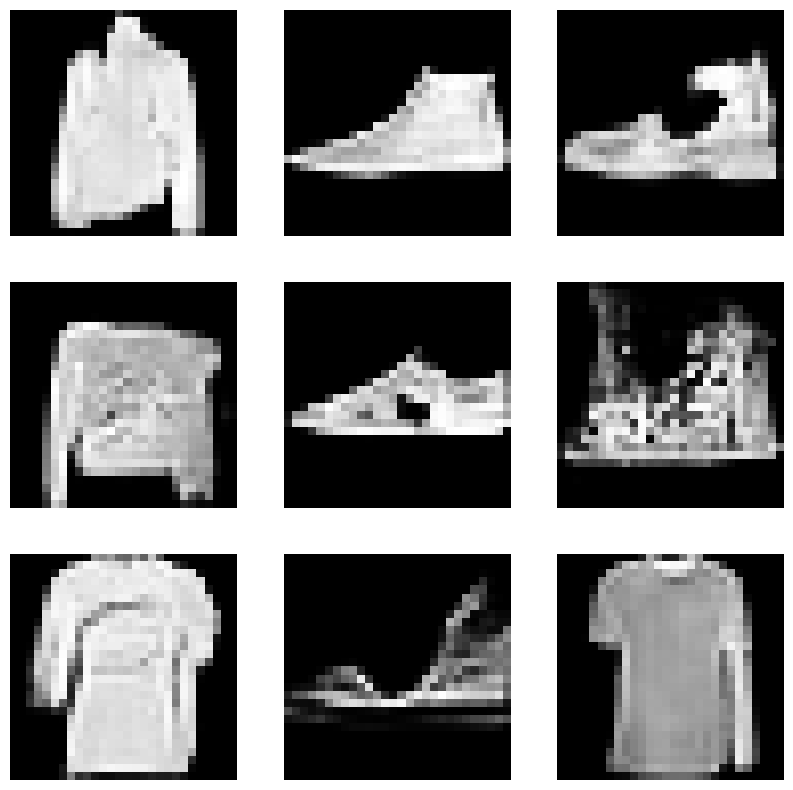

Epoch [79/100], Step [200/938], d_loss: 0.6339, g_loss: 1.1082, D(x): 0.83, D(G(z)): 0.30
Epoch [79/100], Step [400/938], d_loss: 0.6686, g_loss: 1.1748, D(x): 0.89, D(G(z)): 0.37
Epoch [79/100], Step [600/938], d_loss: 0.6624, g_loss: 1.5691, D(x): 0.79, D(G(z)): 0.28
Epoch [79/100], Step [800/938], d_loss: 0.6036, g_loss: 2.2546, D(x): 0.77, D(G(z)): 0.21


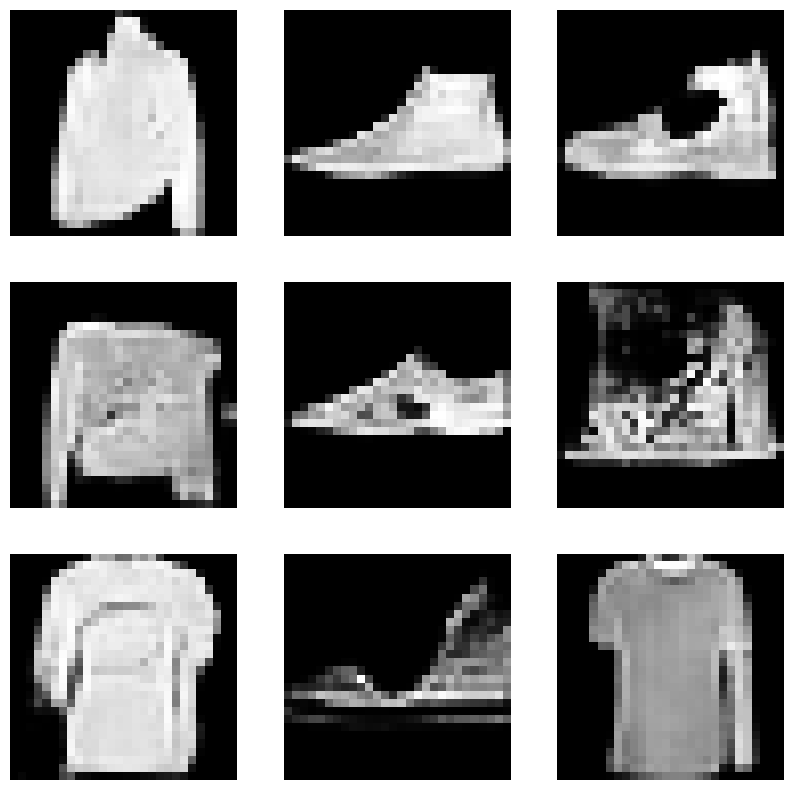

Epoch [80/100], Step [200/938], d_loss: 1.0001, g_loss: 2.0876, D(x): 0.71, D(G(z)): 0.37
Epoch [80/100], Step [400/938], d_loss: 0.6537, g_loss: 2.2523, D(x): 0.70, D(G(z)): 0.17
Epoch [80/100], Step [600/938], d_loss: 0.7897, g_loss: 1.6190, D(x): 0.62, D(G(z)): 0.14
Epoch [80/100], Step [800/938], d_loss: 1.0737, g_loss: 1.4081, D(x): 0.80, D(G(z)): 0.43


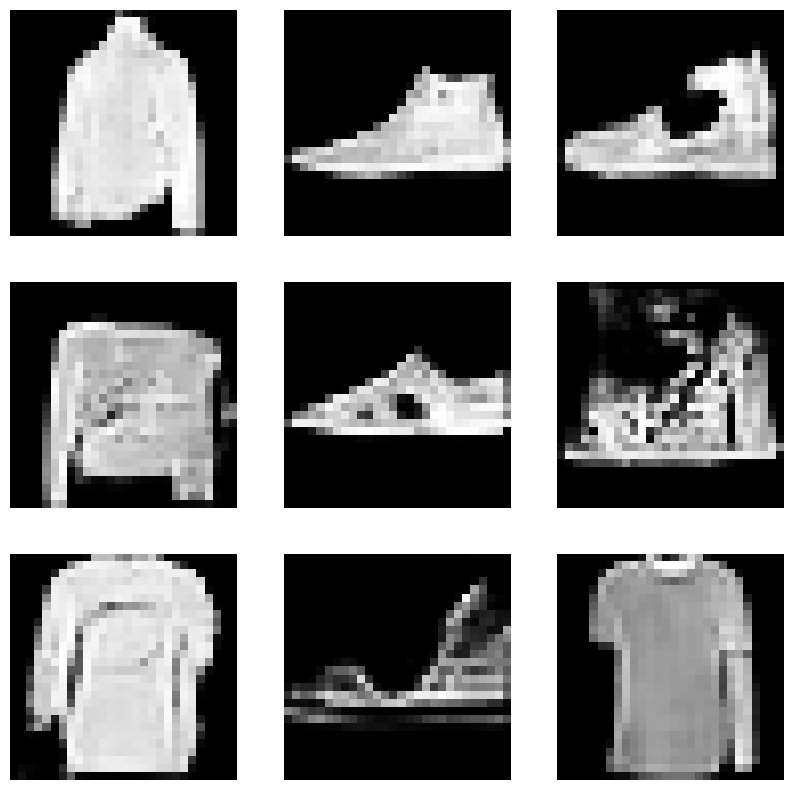

Epoch [81/100], Step [200/938], d_loss: 0.6451, g_loss: 1.6498, D(x): 0.89, D(G(z)): 0.34
Epoch [81/100], Step [400/938], d_loss: 0.8088, g_loss: 1.6642, D(x): 0.69, D(G(z)): 0.26
Epoch [81/100], Step [600/938], d_loss: 0.9923, g_loss: 1.6489, D(x): 0.61, D(G(z)): 0.27
Epoch [81/100], Step [800/938], d_loss: 0.6120, g_loss: 1.4551, D(x): 0.79, D(G(z)): 0.27


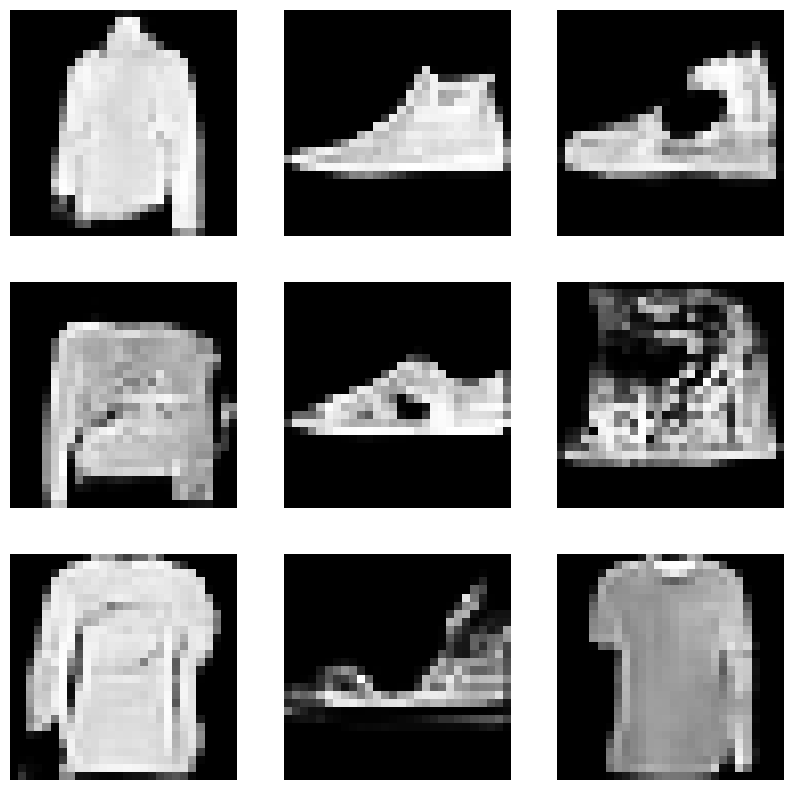

Epoch [82/100], Step [200/938], d_loss: 0.7358, g_loss: 1.0669, D(x): 0.68, D(G(z)): 0.21
Epoch [82/100], Step [400/938], d_loss: 0.8678, g_loss: 1.8948, D(x): 0.67, D(G(z)): 0.26
Epoch [82/100], Step [600/938], d_loss: 0.8868, g_loss: 1.3484, D(x): 0.61, D(G(z)): 0.23
Epoch [82/100], Step [800/938], d_loss: 1.1080, g_loss: 1.0790, D(x): 0.54, D(G(z)): 0.22


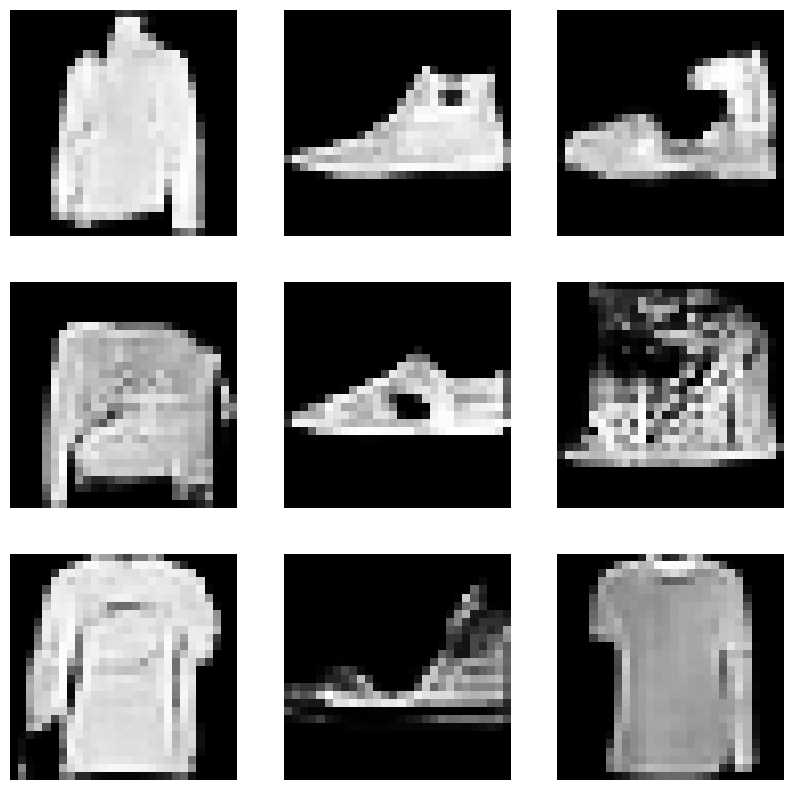

Epoch [83/100], Step [200/938], d_loss: 0.7376, g_loss: 2.3535, D(x): 0.80, D(G(z)): 0.34
Epoch [83/100], Step [400/938], d_loss: 0.6843, g_loss: 2.4598, D(x): 0.73, D(G(z)): 0.23
Epoch [83/100], Step [600/938], d_loss: 0.8546, g_loss: 2.5591, D(x): 0.56, D(G(z)): 0.13
Epoch [83/100], Step [800/938], d_loss: 0.7431, g_loss: 1.1925, D(x): 0.66, D(G(z)): 0.19


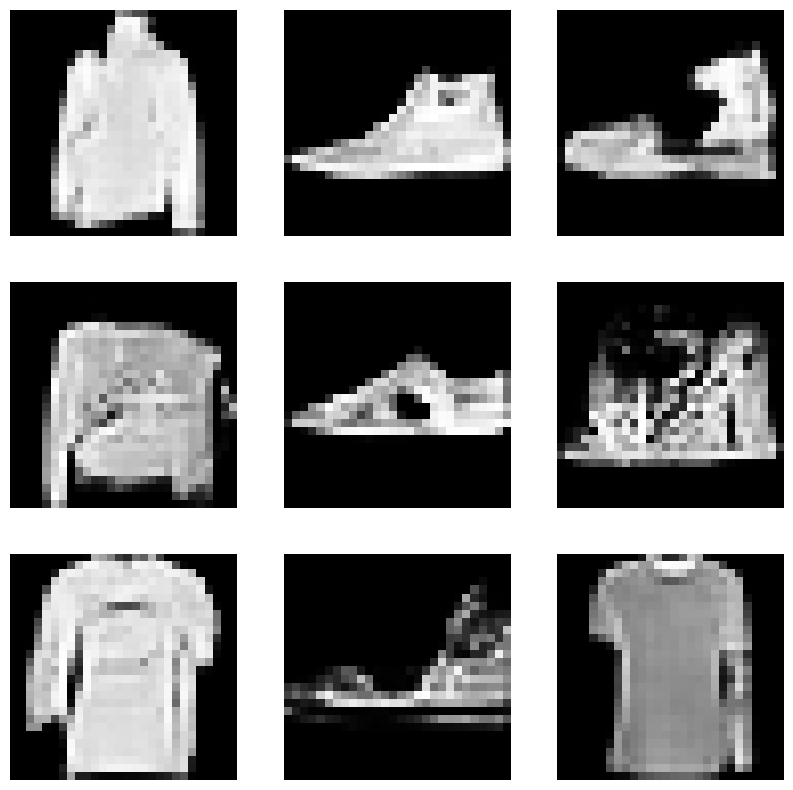

Epoch [84/100], Step [200/938], d_loss: 0.4291, g_loss: 1.6598, D(x): 0.85, D(G(z)): 0.20
Epoch [84/100], Step [400/938], d_loss: 0.6474, g_loss: 2.4325, D(x): 0.72, D(G(z)): 0.19
Epoch [84/100], Step [600/938], d_loss: 0.5919, g_loss: 3.0481, D(x): 0.69, D(G(z)): 0.11
Epoch [84/100], Step [800/938], d_loss: 0.6436, g_loss: 1.5712, D(x): 0.73, D(G(z)): 0.23


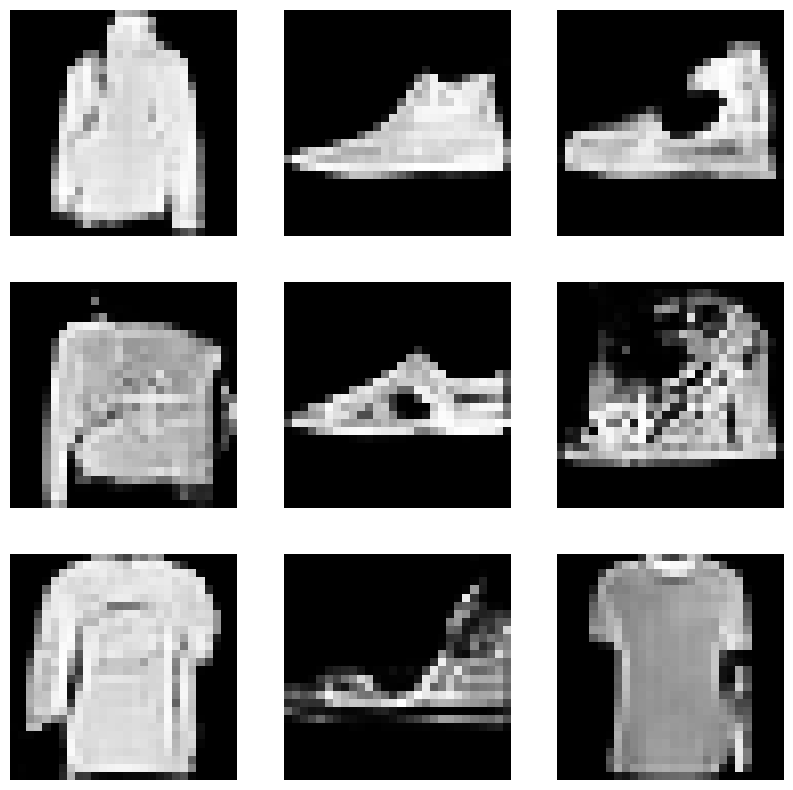

Epoch [85/100], Step [200/938], d_loss: 0.7161, g_loss: 1.9749, D(x): 0.80, D(G(z)): 0.33
Epoch [85/100], Step [400/938], d_loss: 0.8009, g_loss: 3.5522, D(x): 0.61, D(G(z)): 0.11
Epoch [85/100], Step [600/938], d_loss: 0.8483, g_loss: 2.8251, D(x): 0.66, D(G(z)): 0.22
Epoch [85/100], Step [800/938], d_loss: 0.6941, g_loss: 1.6988, D(x): 0.85, D(G(z)): 0.32


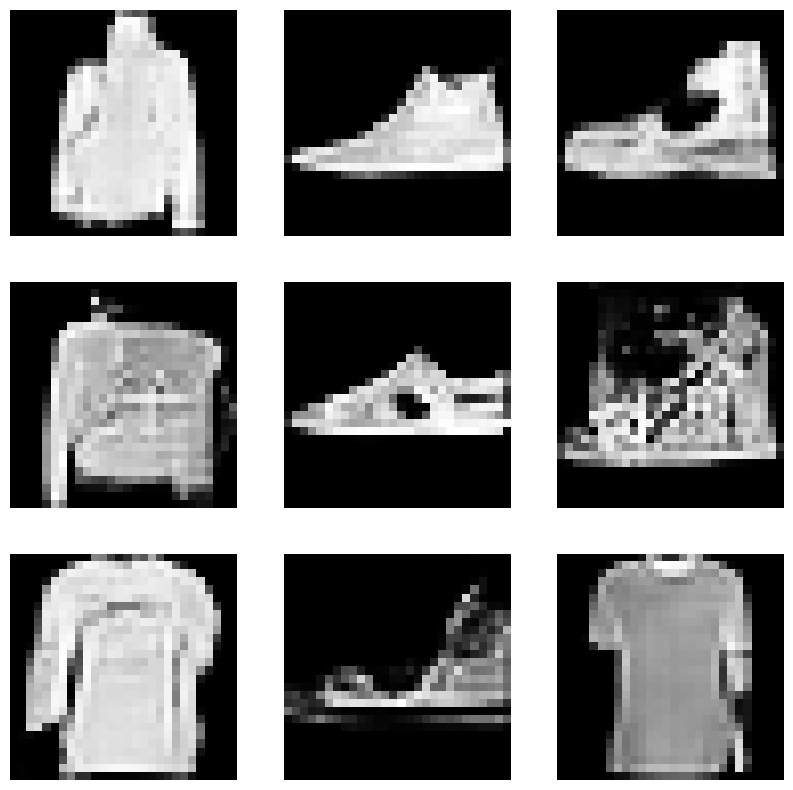

Epoch [86/100], Step [200/938], d_loss: 0.7968, g_loss: 1.7681, D(x): 0.82, D(G(z)): 0.38
Epoch [86/100], Step [400/938], d_loss: 0.7194, g_loss: 1.4143, D(x): 0.82, D(G(z)): 0.32
Epoch [86/100], Step [600/938], d_loss: 0.5831, g_loss: 1.2379, D(x): 0.81, D(G(z)): 0.26
Epoch [86/100], Step [800/938], d_loss: 0.6688, g_loss: 1.3638, D(x): 0.80, D(G(z)): 0.27


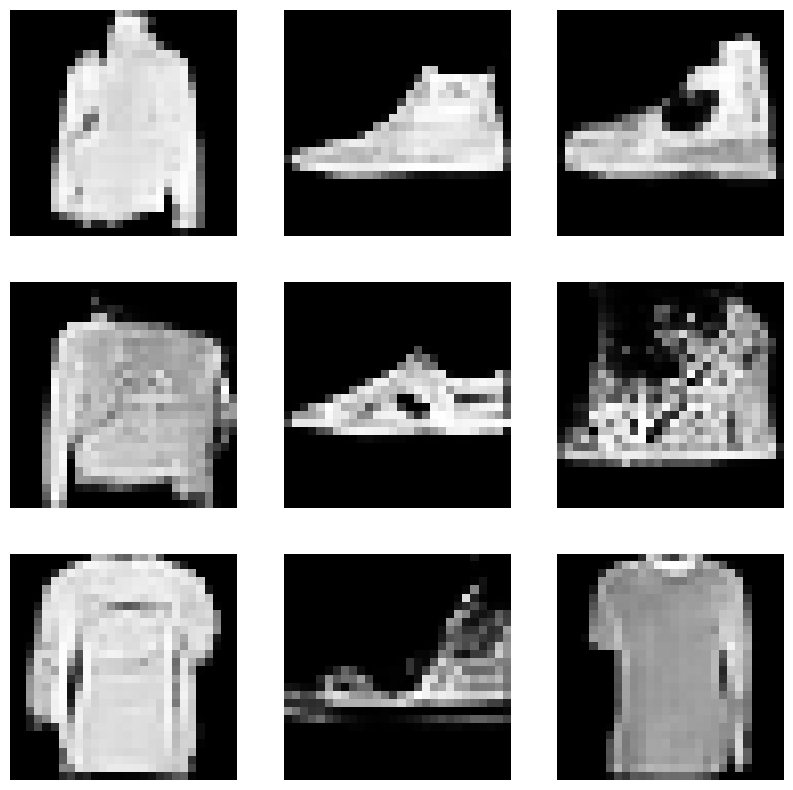

Epoch [87/100], Step [200/938], d_loss: 0.6831, g_loss: 1.5643, D(x): 0.84, D(G(z)): 0.33
Epoch [87/100], Step [400/938], d_loss: 0.4332, g_loss: 2.4018, D(x): 0.85, D(G(z)): 0.19
Epoch [87/100], Step [600/938], d_loss: 0.6656, g_loss: 1.3821, D(x): 0.77, D(G(z)): 0.26
Epoch [87/100], Step [800/938], d_loss: 0.8740, g_loss: 2.4674, D(x): 0.90, D(G(z)): 0.46


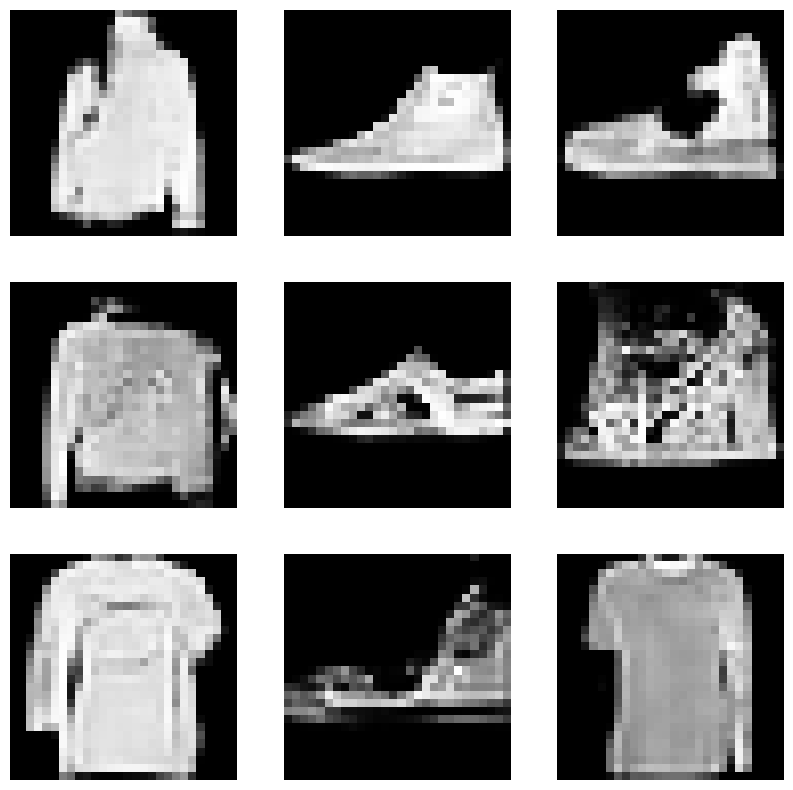

Epoch [88/100], Step [200/938], d_loss: 0.9873, g_loss: 1.7965, D(x): 0.59, D(G(z)): 0.21
Epoch [88/100], Step [400/938], d_loss: 0.5488, g_loss: 2.0157, D(x): 0.87, D(G(z)): 0.27
Epoch [88/100], Step [600/938], d_loss: 0.8730, g_loss: 1.7659, D(x): 0.57, D(G(z)): 0.17
Epoch [88/100], Step [800/938], d_loss: 0.5303, g_loss: 2.5968, D(x): 0.91, D(G(z)): 0.31


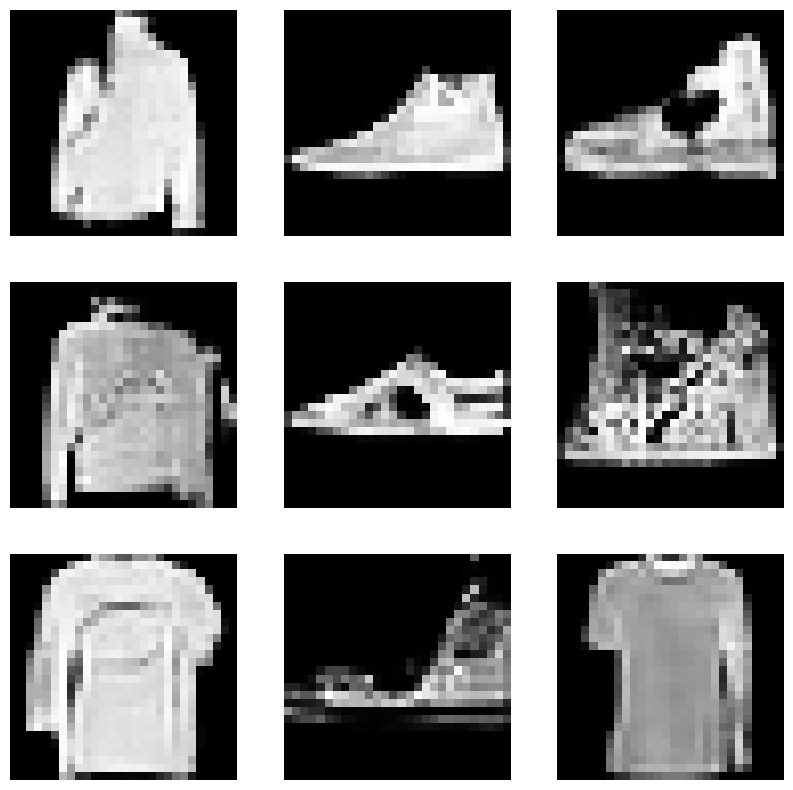

Epoch [89/100], Step [200/938], d_loss: 0.7844, g_loss: 1.6068, D(x): 0.80, D(G(z)): 0.34
Epoch [89/100], Step [400/938], d_loss: 0.5722, g_loss: 2.0077, D(x): 0.77, D(G(z)): 0.20
Epoch [89/100], Step [600/938], d_loss: 0.5618, g_loss: 2.0706, D(x): 0.75, D(G(z)): 0.15
Epoch [89/100], Step [800/938], d_loss: 0.4959, g_loss: 2.3733, D(x): 0.81, D(G(z)): 0.19


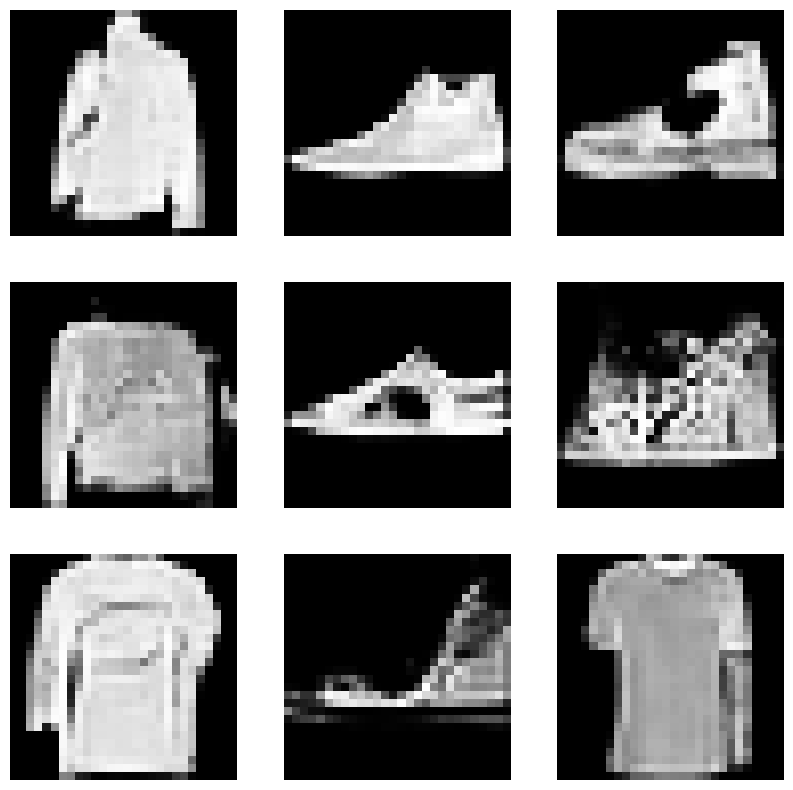

Epoch [90/100], Step [200/938], d_loss: 0.7759, g_loss: 1.7597, D(x): 0.76, D(G(z)): 0.31
Epoch [90/100], Step [400/938], d_loss: 0.5412, g_loss: 2.1507, D(x): 0.77, D(G(z)): 0.20
Epoch [90/100], Step [600/938], d_loss: 0.6119, g_loss: 1.7669, D(x): 0.80, D(G(z)): 0.25
Epoch [90/100], Step [800/938], d_loss: 0.6921, g_loss: 1.8619, D(x): 0.82, D(G(z)): 0.30


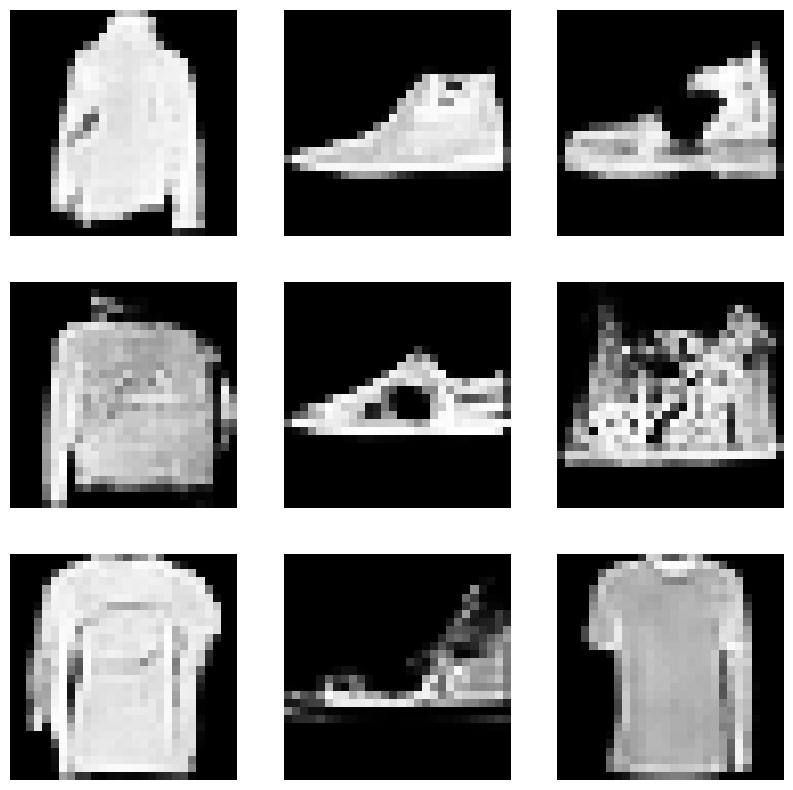

Epoch [91/100], Step [200/938], d_loss: 0.6559, g_loss: 1.7243, D(x): 0.72, D(G(z)): 0.21
Epoch [91/100], Step [400/938], d_loss: 1.1147, g_loss: 2.4588, D(x): 0.45, D(G(z)): 0.11
Epoch [91/100], Step [600/938], d_loss: 0.8880, g_loss: 2.2918, D(x): 0.69, D(G(z)): 0.30
Epoch [91/100], Step [800/938], d_loss: 0.6639, g_loss: 2.3086, D(x): 0.79, D(G(z)): 0.26


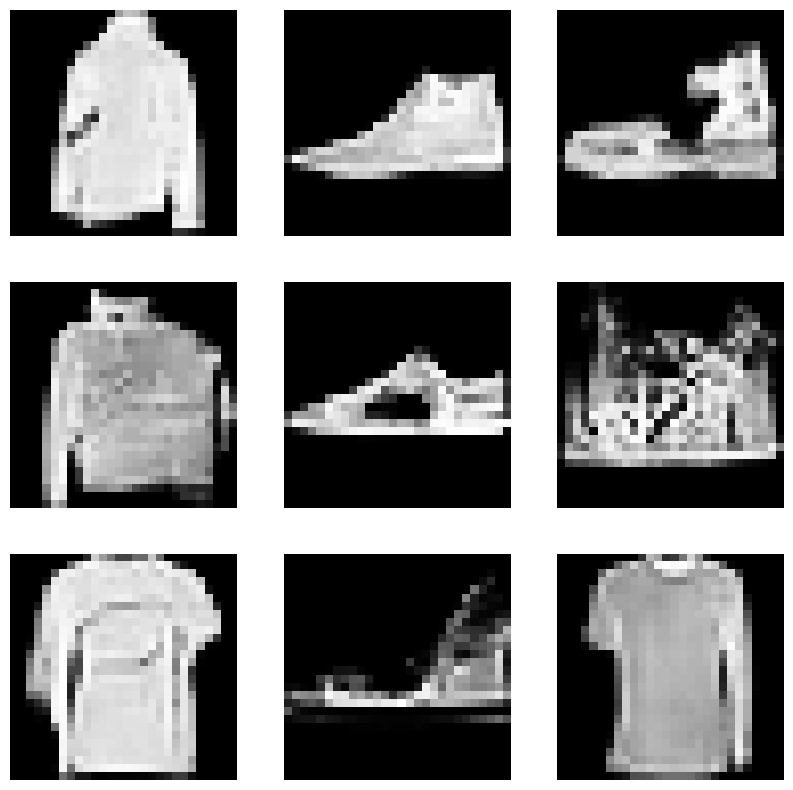

Epoch [92/100], Step [200/938], d_loss: 0.5563, g_loss: 1.7754, D(x): 0.71, D(G(z)): 0.11
Epoch [92/100], Step [400/938], d_loss: 0.6345, g_loss: 1.6271, D(x): 0.73, D(G(z)): 0.18
Epoch [92/100], Step [600/938], d_loss: 0.7498, g_loss: 1.5165, D(x): 0.69, D(G(z)): 0.21
Epoch [92/100], Step [800/938], d_loss: 0.5829, g_loss: 1.0464, D(x): 0.72, D(G(z)): 0.16


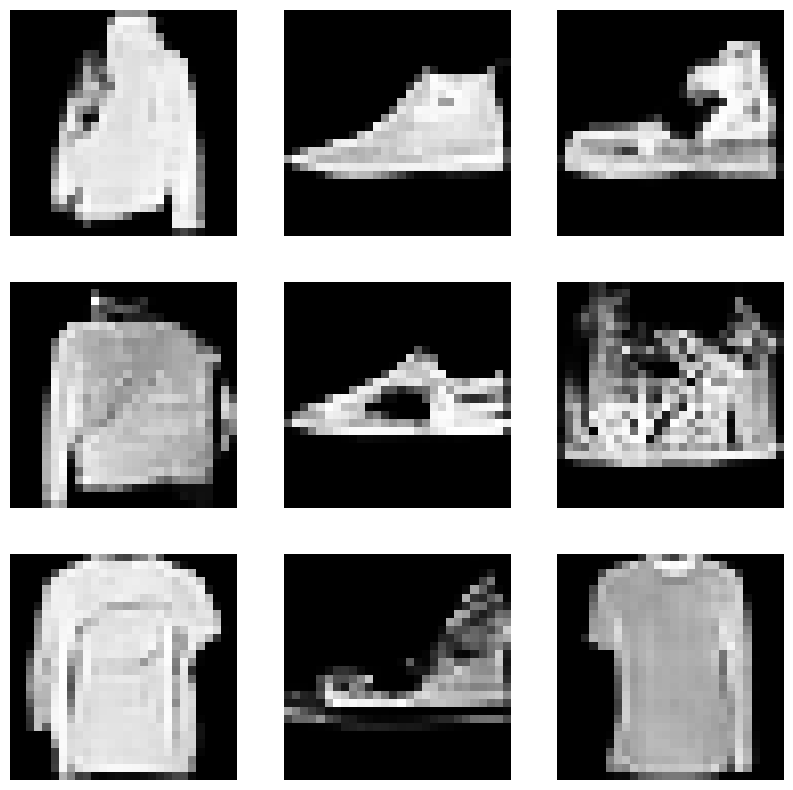

Epoch [93/100], Step [200/938], d_loss: 1.2187, g_loss: 1.7514, D(x): 0.42, D(G(z)): 0.08
Epoch [93/100], Step [400/938], d_loss: 0.9551, g_loss: 2.1603, D(x): 0.56, D(G(z)): 0.16
Epoch [93/100], Step [600/938], d_loss: 0.9259, g_loss: 2.2800, D(x): 0.55, D(G(z)): 0.15
Epoch [93/100], Step [800/938], d_loss: 0.9198, g_loss: 1.9130, D(x): 0.74, D(G(z)): 0.32


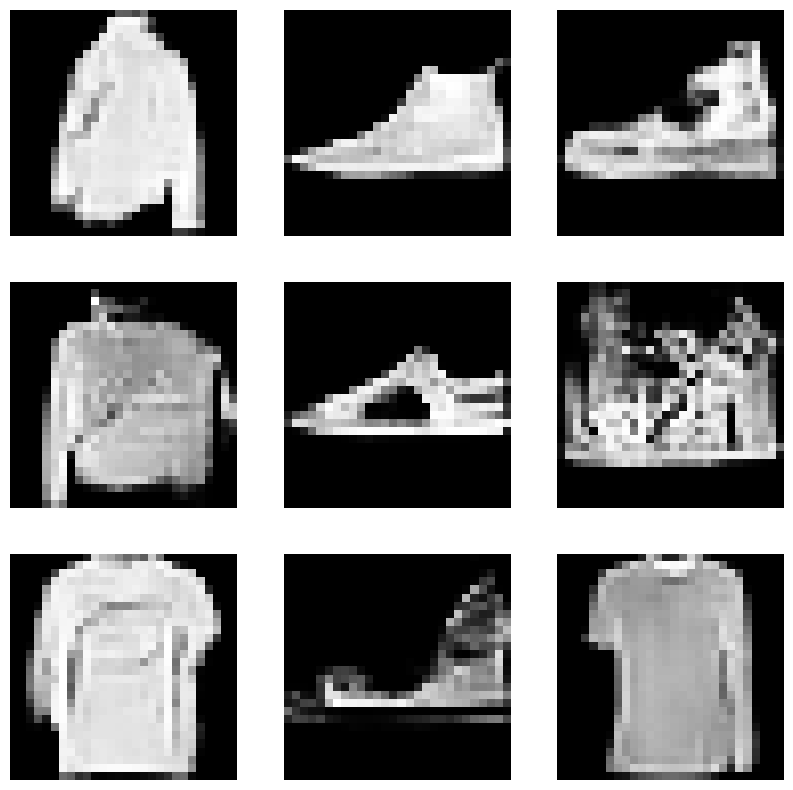

Epoch [94/100], Step [200/938], d_loss: 0.5766, g_loss: 1.6802, D(x): 0.78, D(G(z)): 0.22
Epoch [94/100], Step [400/938], d_loss: 0.9034, g_loss: 2.3971, D(x): 0.70, D(G(z)): 0.27
Epoch [94/100], Step [600/938], d_loss: 0.6806, g_loss: 2.5438, D(x): 0.65, D(G(z)): 0.12
Epoch [94/100], Step [800/938], d_loss: 0.7862, g_loss: 1.6641, D(x): 0.77, D(G(z)): 0.30


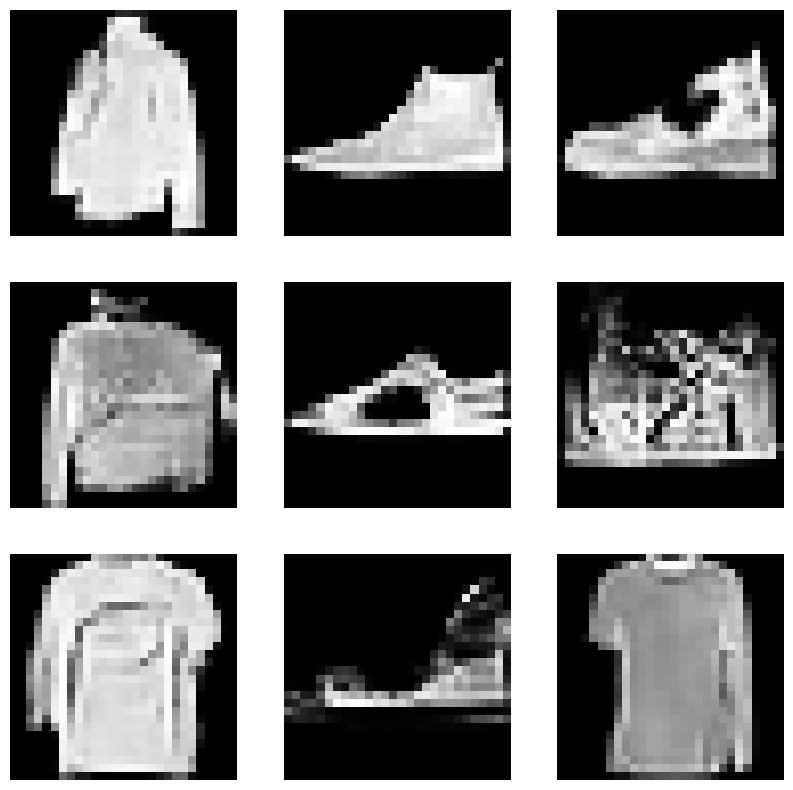

Epoch [95/100], Step [200/938], d_loss: 0.6472, g_loss: 2.1815, D(x): 0.74, D(G(z)): 0.18
Epoch [95/100], Step [400/938], d_loss: 0.6100, g_loss: 1.5222, D(x): 0.72, D(G(z)): 0.17
Epoch [95/100], Step [600/938], d_loss: 0.8051, g_loss: 2.1394, D(x): 0.66, D(G(z)): 0.20
Epoch [95/100], Step [800/938], d_loss: 0.5498, g_loss: 1.6985, D(x): 0.79, D(G(z)): 0.21


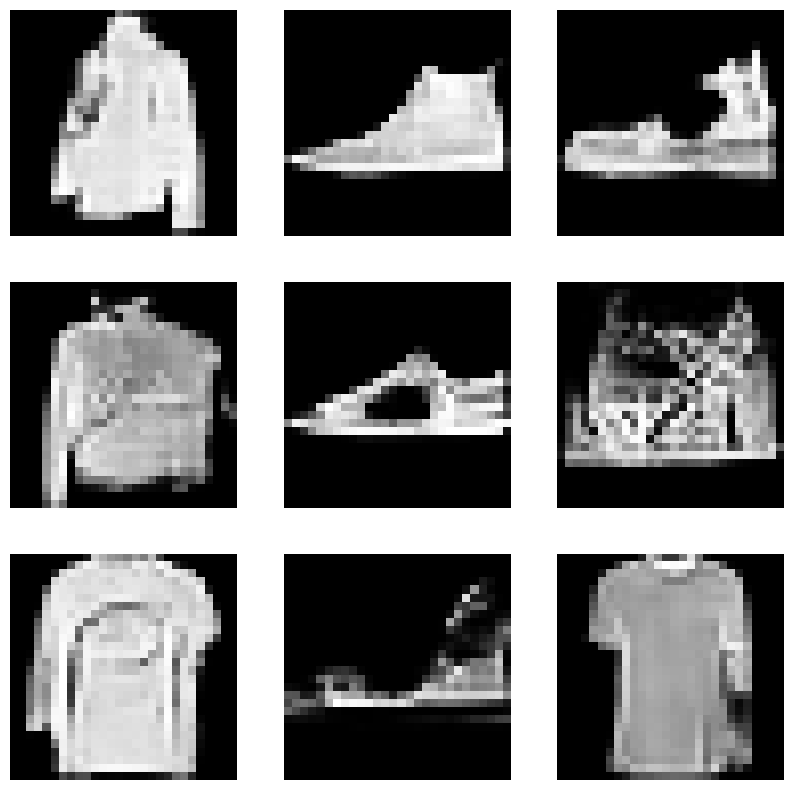

Epoch [96/100], Step [200/938], d_loss: 0.7316, g_loss: 2.2710, D(x): 0.64, D(G(z)): 0.14
Epoch [96/100], Step [400/938], d_loss: 0.5136, g_loss: 1.4019, D(x): 0.85, D(G(z)): 0.24
Epoch [96/100], Step [600/938], d_loss: 0.8574, g_loss: 2.3116, D(x): 0.57, D(G(z)): 0.10
Epoch [96/100], Step [800/938], d_loss: 0.6473, g_loss: 1.9931, D(x): 0.81, D(G(z)): 0.29


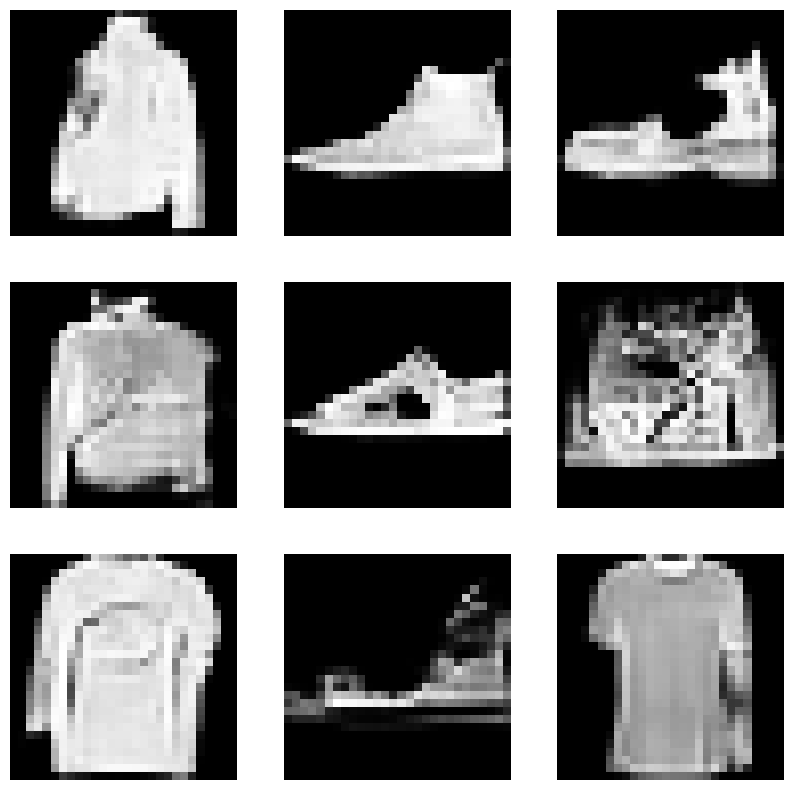

Epoch [97/100], Step [200/938], d_loss: 0.5573, g_loss: 1.7581, D(x): 0.82, D(G(z)): 0.23
Epoch [97/100], Step [400/938], d_loss: 0.7596, g_loss: 1.6092, D(x): 0.67, D(G(z)): 0.20
Epoch [97/100], Step [600/938], d_loss: 0.5298, g_loss: 2.2728, D(x): 0.80, D(G(z)): 0.22
Epoch [97/100], Step [800/938], d_loss: 0.6110, g_loss: 1.7845, D(x): 0.75, D(G(z)): 0.19


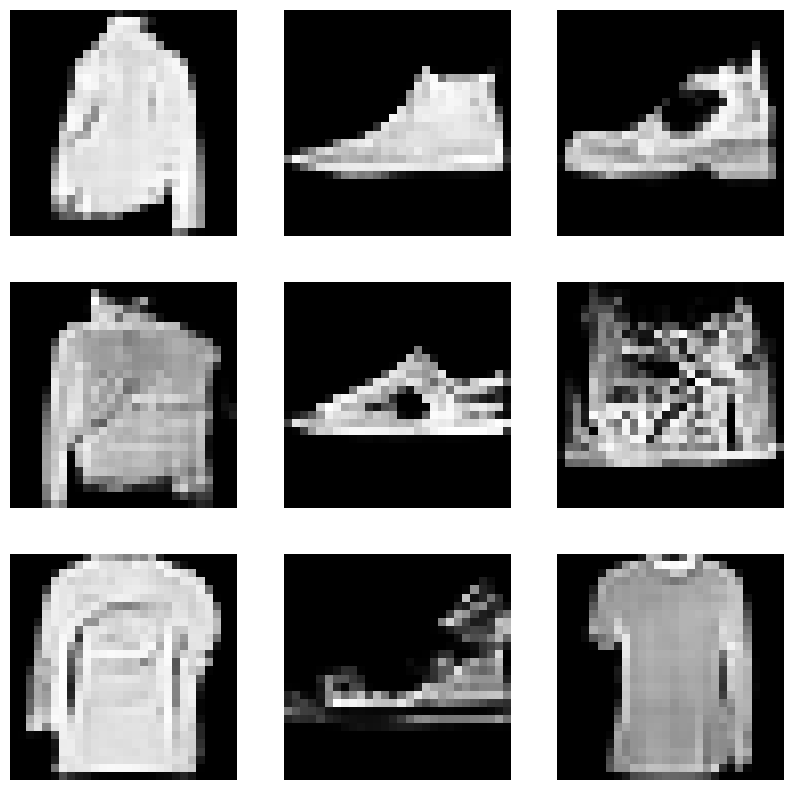

Epoch [98/100], Step [200/938], d_loss: 0.5819, g_loss: 3.3165, D(x): 0.72, D(G(z)): 0.12
Epoch [98/100], Step [400/938], d_loss: 1.0246, g_loss: 1.2808, D(x): 0.70, D(G(z)): 0.35
Epoch [98/100], Step [600/938], d_loss: 0.9351, g_loss: 2.1108, D(x): 0.51, D(G(z)): 0.09
Epoch [98/100], Step [800/938], d_loss: 0.5133, g_loss: 1.6179, D(x): 0.80, D(G(z)): 0.17


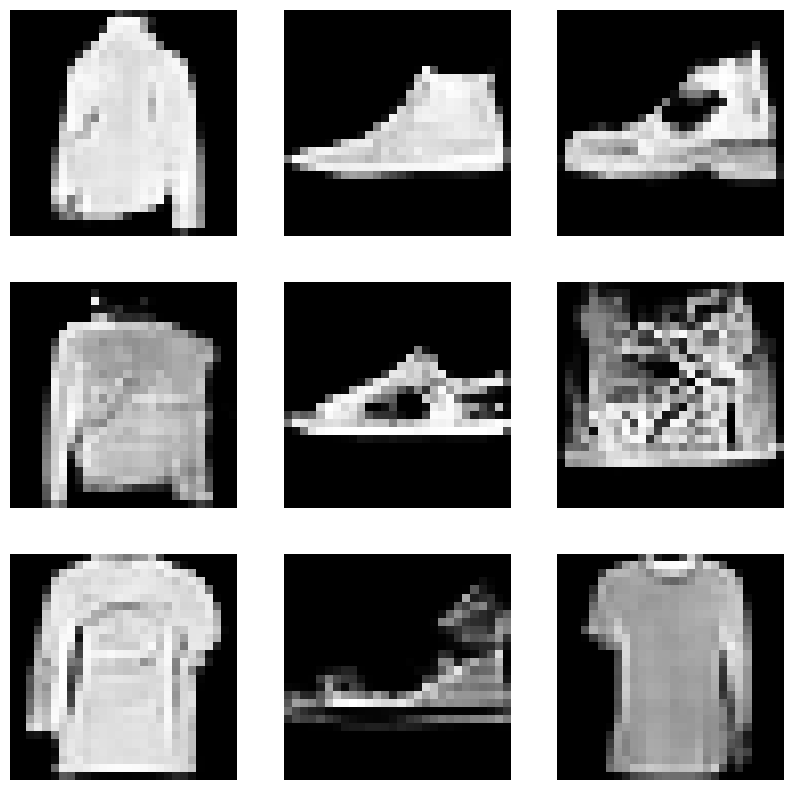

Epoch [99/100], Step [200/938], d_loss: 0.7858, g_loss: 2.7110, D(x): 0.59, D(G(z)): 0.09
Epoch [99/100], Step [400/938], d_loss: 0.6428, g_loss: 2.7793, D(x): 0.76, D(G(z)): 0.23
Epoch [99/100], Step [600/938], d_loss: 0.8240, g_loss: 1.4421, D(x): 0.61, D(G(z)): 0.14
Epoch [99/100], Step [800/938], d_loss: 0.7607, g_loss: 2.1485, D(x): 0.70, D(G(z)): 0.21


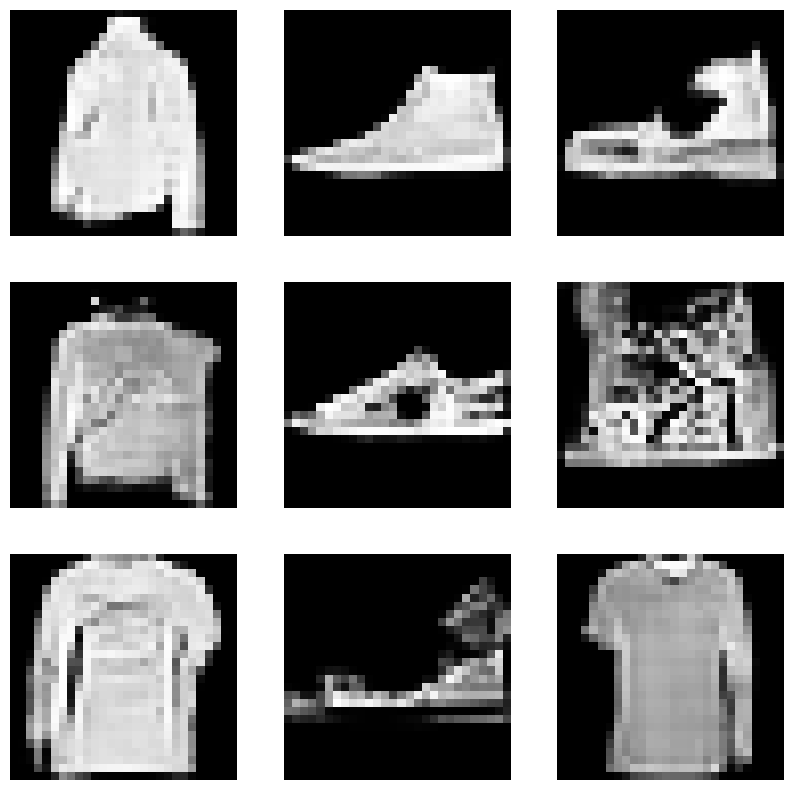

In [ ]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)
        images = images.to(device)

        # Train the discriminator
        z = torch.randn(images.size(0), latent_dim, 1, 1, device=device)
        fake_images = generator(z)
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)

        # Train the generator
        z = torch.randn(images.size(0), latent_dim, 1, 1, device=device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = train_generator(generator, outputs, real_labels)

        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i + 1}/{num_batches}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    generator.eval()
    fake_images = generator(fixed_noise)
    generator.train()

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(fake_images[i].squeeze().detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()